# Notebook pre steps

In [1]:
#@title Installations

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install dfply
!python --version
# !pip install plotly --quiet
import plotly.io as pio
pio.renderers.default = "colab"

from dfply import *
from plotnine import *
import matplotlib.pyplot as plt
import numpy as np  # RNG and vector ops
import pandas as pd  # tabular outputs
import math
import random
from IPython.display import display, Markdown
from tqdm import tqdm
from typing import Any, Optional, Dict, Hashable, List, Tuple, Callable
# import json
# from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 6.5 MB/s eta 0:00:00
Python 3.12.12


# Policy Gradient Methods

Here, we focus on directly learning a parameterized policy that can select actions without referring to a value function.

Let the policy be represented as $$\pi(a|s, \theta) = \Pr(A_t = a|S_t = s, \theta_t = \theta),$$ where $\theta \in \mathbb{R}^{d'}$ is a vector of policy parameters. That is, $\pi(a|s, \theta)$ is the probability that action $a$ is taken in state $s$ when the policy parameters have value $\theta$.

The objective is to learn the policy parameters by following the gradient of a scalar performance measure $J(\theta)$ with respect to $\theta$. The goal is to maximize performance, the parameter updates follow a stochastic gradient-ascent rule:
$$
\theta_{t+1} = \theta_t + \alpha \nabla J(\theta_t)
$$
where $\nabla J(\theta_t)$ is an estimate of the gradient of the performance measure with respect to $\theta_t$.

First, we consider the episodic setting, where performance is defined as the value of the start state under the parameterised policy. Next, the continuing case is considered, where performance is defined in terms of the long-run average reward.


## Seasonal inventory and sales planning

In the episodic setting, we address the seasonal inventory and sales planning problem in [Example 9.4.4](https://bss-osca.github.io/rl/09_mc.html#sec-mc-seasonal).

We consider seasonal products such as garden furniture. Assume that the maximum inventory level is $Q$ items, meaning we can purchase at most $Q$ items at the start of the season for a fixed price. The product can be sold for up to $T$ weeks, and at the end of the period (week $T$), any remaining inventory is sold to an outlet store at scrap price.

Let $s = (q,t)$ denote the state of the system at the start of a week. There is a terminal state when the inventory is empty. Actions involve choosing a price, and for now, we limit ourselves to the set $\{10, 15, 20, 25\}$.

Our objective is to maximize the total discounted reward, given we start in state $(65,1)$, i.e $J(\theta) = v_{\pi_\theta}((65,1))$.

First, we load the optimal policy for comparison. Assuming the starting state is $(65,1)$, we find optimal objective function value $J(\theta) = v_\pi(s_0) = v_\pi((65,1))$:

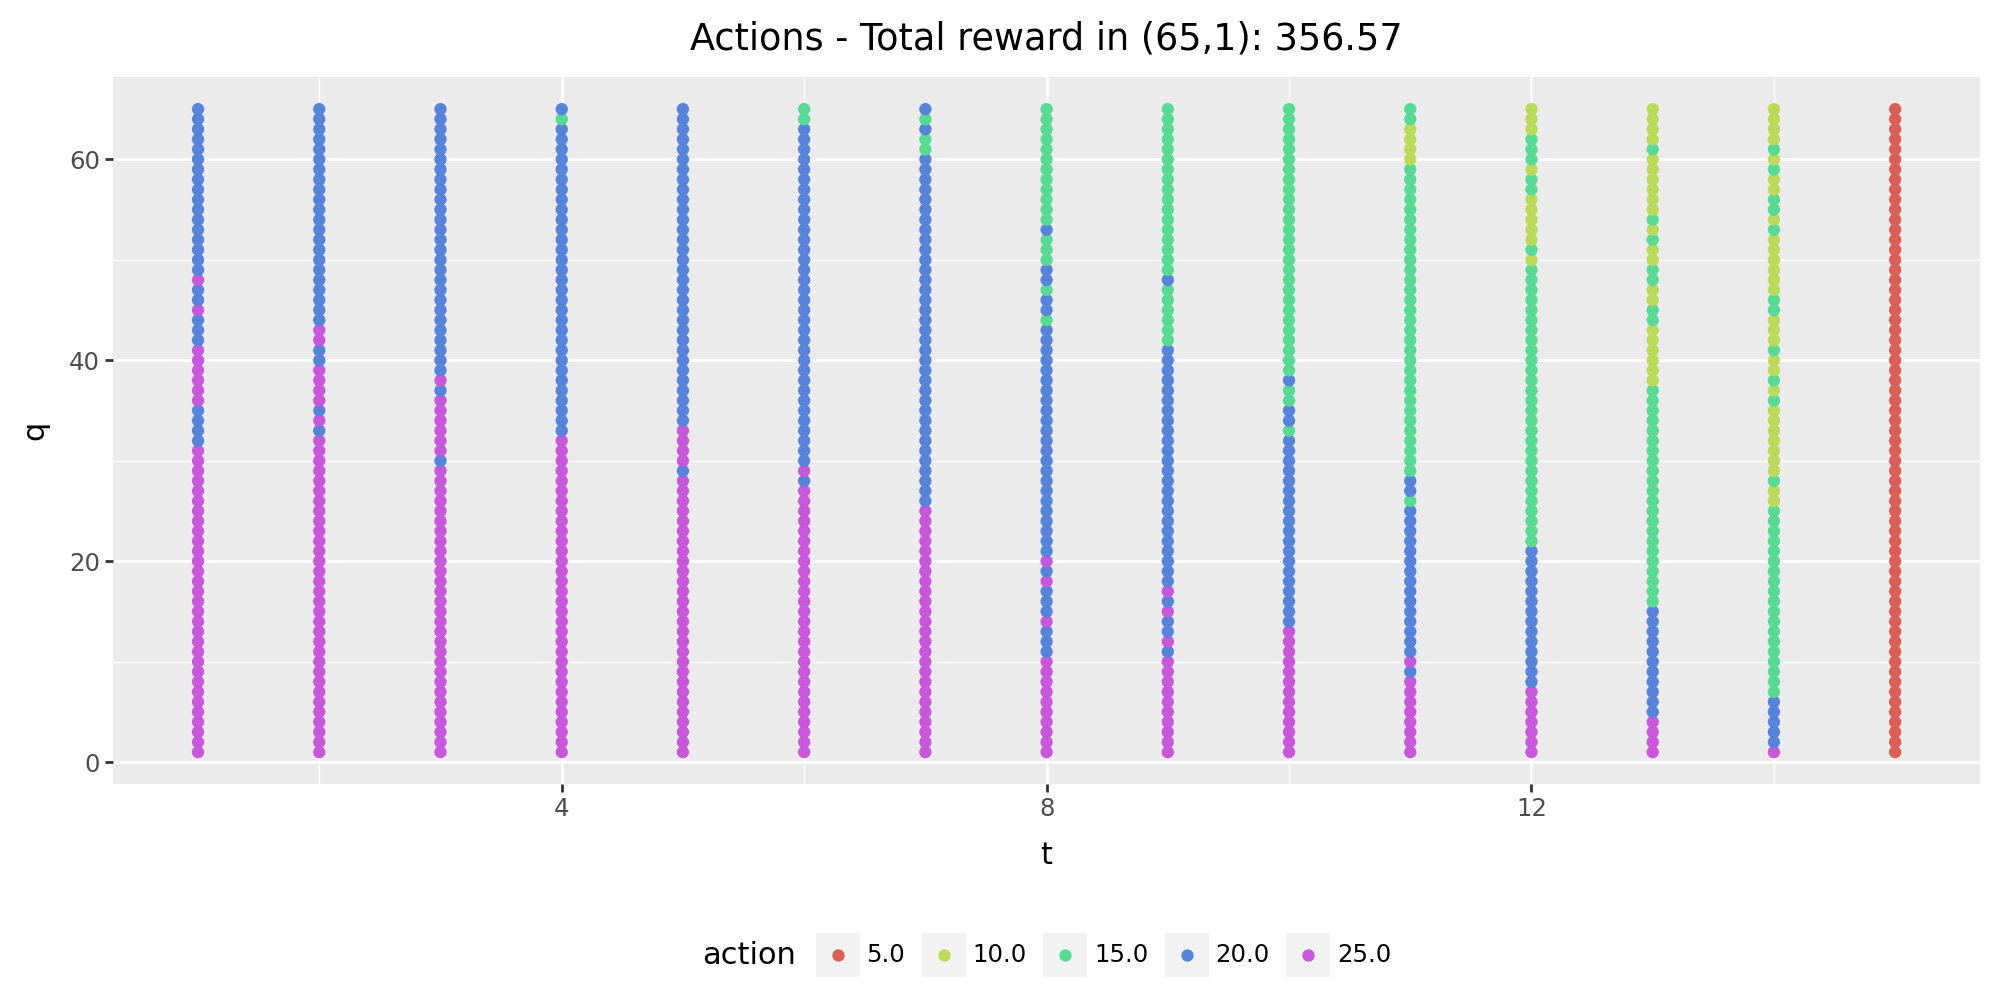

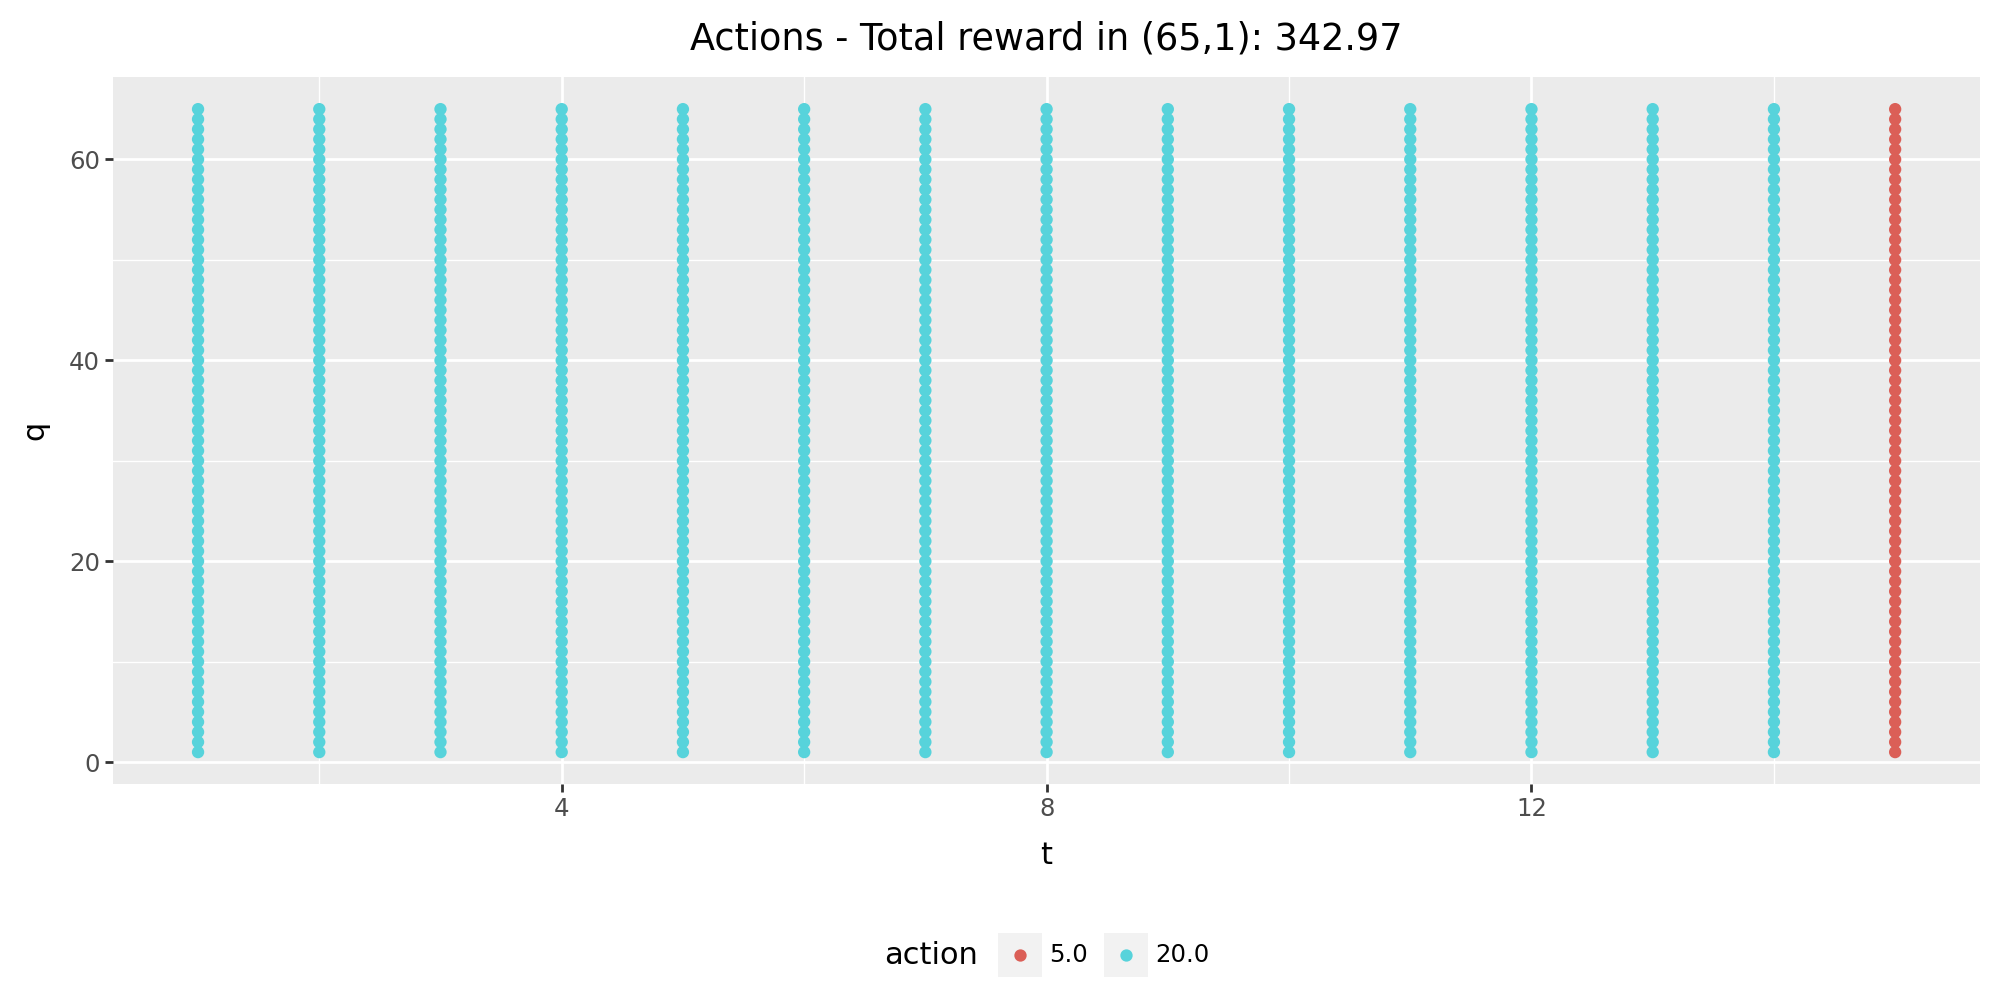

In [ ]:
#@title MDP solution

start_q = 65  # start inventory
dat_mdp = pd.read_csv('https://drive.google.com/uc?id=1dY6r4xKFwIv3DBEHiOnehbiVEGAhqQax', index_col = False)
dat_mdp = dat_mdp >> mask(X.q <= start_q)

# Plot optimal policy
v_opt = dat_mdp >> mask(X.q == start_q, X.t == 1)
v_opt = float(v_opt['v'].values[0].round(2))  # Optimal value
dat_a = dat_mdp
dat_a['action'] = pd.Categorical(dat_a['action'])
pt = (
    ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
    + geom_point()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(title = f"Actions - Total reward in (65,1): {v_opt}")
)
pt.show()


# Plot - Policy to use 20 as price always
dat_mdp20 = pd.read_csv('https://drive.google.com/uc?id=1OZI6Ic-08X7RUx656Sg9v_wJ3rvV-xbe', index_col = False)
dat_mdp20 = dat_mdp20 >> mask(X.q <= start_q)
v = dat_mdp20 >> mask(X.q == start_q, X.t == 1)
v = float(v['v'].values[0].round(2))
dat_a = dat_mdp20
dat_a['action'] = pd.Categorical(dat_a['action'])
pt = (
    ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
    + geom_point()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(title = f"Actions - Total reward in (65,1): {v}")
)
pt.show()

Note we have also loaded the policy to use a price equal to 20 always which has $v_\pi((65,1))$ close to the optimal value.

The inventory dynamics and rewards are coded in the environment below:

In [ ]:
#@title RL environment - Seasonal

from __future__ import annotations  # forward refs

import numpy as np
import pandas as pd


class RLEnvSeasonal:
    """
    Seasonal single-item pricing/sales environment.

    State space:
      - non-terminal states are strings "q,t" where q∈{1..max_inv}, t∈{1..max_t}
      - terminal state is `None`

    Action space:
      - at t < max_t: choose a price from self.prices (as string)
      - at t == max_t: action is effectively a dummy (we scrap remaining inventory)

    Stochastic demand depends on price via a piecewise curve and has early-season uplift.
    """

    def __init__(self,
                 max_inv: int,
                 max_t: int,
                 scrap_price: float,
                 purchase_price: float,
                 prices: list[float],
                 start_q = None,
                 seed = None) -> None:

        """
        Initializes the seasonal RL environment.

        Args:
            max_inv: Maximum inventory units.
            max_t: Number of selling weeks.
            scrap_price: Value per leftover at final week.
            purchase_price: Unit purchase cost at t=1.
            prices: Allowable sale prices.
            start_q: Initial inventory level used.
            seed: Seed for random number generator.
        """
        self.max_inv = int(max_inv)
        self.max_t = int(max_t)
        self.scrap_price = float(scrap_price)
        self.purchase_price = float(purchase_price)
        self.prices = list(map(float, prices))
        self.rng = np.random.default_rng(seed)
        self.rng_seed = seed
        self.start_q = start_q

    def reset(self, q = None) -> list[int]:
        """
        Reset the environment to the initial state.

        Returns:
            The initial state.
        """
        t = 1  # start at time 1
        if self.start_q:
            return(int(self.start_q), t)
        if not q:
            q = self.rng.integers(1, self.max_inv + 1)
        return [int(q), t]

    def reset_rng(self):
        """
        Reset the random number generator.

        Returns:
            The initial state.
        """
        self.rng = np.random.default_rng(self.rng_seed)
        return self.reset()

    # ----------------------------- state & action spaces ----------------------

    def get_states(self) -> list[str]:
        """
        Return all states.
        """
        states = [(q,t) for q in range(1, self.max_inv + 1) for t in range(1, self.max_t + 1)]
        return states

    def get_actions(self, s) -> list[float]:
        """
        Return available actions for state s.

        Args:
            s: The state.

        Returns:
            A list of actions for the given state.
        """
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(t)
        assert 1 <= t <= self.max_t
        if t == self.max_t:
            return [self.scrap_price]
        assert np.isscalar(q)
        assert 1 <= q <= self.max_inv
        return self.prices

    def get_nb_states(self) -> int:
        """
        Return the number of states.

        Returns:
            The number of states.
        """
        return self.max_inv * self.max_t

    def get_nb_actions(self) -> int:
        """
        Return the number of actions.

        Returns:
            The number of actions.
        """
        return len(self.prices+1)

    # ----------------------------- demand model --------------------------------

    def get_demand(self, price: float, t: int) -> int:
        """
        Sample a stochastic demand for a given price and week.

        Piecewise base demand:
          - linear between (10,20) and (12,12)
          - linear between (12,12) and (15,10)
          - log tail beyond 15
        Early-season uplift for t <= max_t/2.

        Args:
            price: The price.
            t: The week.

        Returns:
            The sampled demand as an integer.
        """
        # l1: between price 10..12
        # l2: between price 12..15
        # l3: beyond 15, log decay anchored at (15,10)
        if price <= 12.0:
            a = (20.0 - 12.0) / (10.0 - 12.0)
            b = 20.0 - a * 10.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        elif 12.0 <= price <= 15.0:
            a = (12.0 - 10.0) / (12.0 - 15.0)
            b = 12.0 - a * 12.0
            d = a * price + b
            d_s = d * self.rng.uniform(0.75, 1.25)
        else:
            d = -4.0 * np.log(price - 15.0 + 1.0) + 10.0
            d_s = d * self.rng.uniform(1.0, 2.0)
        if t <= self.max_t / 2.0:
            d_s *= self.rng.uniform(1.0, 1.2)
        return int(round(max(0.0, d_s)))

    # ----------------------------- single-step API for RLAgent -----------------

    def get_step(self, s, a: float) -> tuple[list[int] | None, float, bool]:
        """
        One simulated step: given (s,a) -> (s_n, a_n, terminal)

        Args:
            s: The current state (list).
            a: The action taken (scalar).

        Returns:
            The next state, reward, and terminal flag.
        """
        assert np.isscalar(a)
        assert len(s) == 2
        q, t = s[0], s[1]
        assert np.isscalar(q)
        assert np.isscalar(t)
        if q == 0:
            return (None, 0.0, True)
        if t == self.max_t:
            r = self.scrap_price * q
            return (None, r, True)
        price = float(a)
        d = self.get_demand(price, t)
        sold = min(q, d)
        r = price * sold
        if t == 1:
            r -= q * self.purchase_price
        q_n = q - sold
        if q_n == 0:
            return (None, r, True)
        return ([q_n, t+1], r, False)

Let us create an instance of the environment:

In [ ]:
# Define candidate sales prices
prices = [10, 15, 20, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=100,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

### Your turn

What is the effect of argument `start_q`? Is there any reason to set `max_inv = 100`?

*It specifies the inventory we choose to buy at the start of an episode. Since, this is 65, no states with $q>65$ will be visited and we may set `max_inv` to 65.*

## Policy Approximation Class

This `SoftmaxPolicy` class implements a softmax policy for discrete action spaces, where action preferences are a linear function of state-action features. This is a common approach for policy gradient methods like REINFORCE when function approximation is needed.

In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicy:
    """Softmax policy with a separate parameter vector for each action.

    Each action a has its own weight vector θ_a. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the state feature vector is:

        x(s) = [1.0, q / max_inv, t / max_t].

    This formulation supports state-dependent action sets, including a
    terminal scrap action.
    """

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
    ) -> None:
        """Initializes the softmax policy.

        Args:
            env: Environment providing attributes `max_inv`, `max_t`,
                `prices`, `scrap_price`, and a method `get_actions(s)`.
            step_size: Initial learning rate alpha.
            decay_fct: Multiplicative decay applied to alpha after each
                update. Defaults to 1.0 (no decay).
            rng_seed: Optional random seed.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Explicit action → index mapping
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # State feature count: [1, q/max_inv, t/max_t]
        self.num_features = 3

        # Parameter matrix: one θ-vector per action
        self.theta = np.zeros(
            (self.num_actions, self.num_features),
            dtype=float,
        )

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Computes a numerically stable softmax.

        Args:
            x: Input score vector.

        Returns:
            Softmax probabilities over the input.
        """
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Constructs the state feature vector.

        Args:
            s: State [q, t].

        Returns:
            Feature vector x(s).
        """
        q, t = s
        return np.array(
            [1.0, q / self.max_inv, t / self.max_t],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Computes the preference values h(s, a) for available actions.

        Args:
            s: State [q, t].

        Returns:
            A vector of preferences for actions available in s.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)

        # Convert actions to their global parameter indices
        idxs = [self.act2idx[a] for a in actions]

        return np.array([self.theta[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Computes the policy distribution π(. | s).

        Args:
            s: State [q, t].

        Returns:
            Action probabilities for actions available in s.
        """
        prefs = self.get_action_preferences(s)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from the policy.

        Args:
            s: State [q, t].

        Returns:
            Sampled action from π(. | s).
        """
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns the action with the highest preference h(s, a).

        Args:
            s: State [q, t].

        Returns:
            The best action according to current θ.
        """
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇θ log π(a | s).

        The gradient has the same shape as θ. For softmax:

            ∇θ_a log π(a | s)     = (1 − π(a | s)) · x(s)
            ∇θ_b log π(a | s)     = −π(b | s) · x(s),  b ≠ a

        Args:
            s: State [q, t].
            a: Chosen action.

        Returns:
            Gradient matrix matching shape of θ.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        # Identify chosen action coordinate
        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        # Fill gradient rows
        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """Applies a REINFORCE parameter update.

        Update rule:
            θ ← θ + α * mult * ∇θ log π(a | s)

        Args:
            s: State at time t.
            a: Action taken at time t.
            mult: Scalar multiplier, typically (γ^t) G_t.
        """
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


Note that class `SoftmaxPolicy` we implement methods for calculating action probabilities, action selection, linear features for the preferences $h(s,a,\theta)$, finding the gradient, training etc.

**Calculating the gradient**

Note that since $\theta$ is a matrix ($|A| × 3$) the eligibility vector $\nabla_\theta \ln \pi(a \mid s;\theta)$ is also a matrix (or think of it as a vector where each entry is $\theta_a = (\theta_{1,a}, \theta_{2,a}, \theta_{3,a})$.

First observe that
$$
\begin{align}
\ln \pi(a \mid s;\theta) &= \ln \exp\big(\theta^\top x(s,a)\big) - \ln \sum_b \exp\big(\theta^\top x(s,b)\big) \\
   &= \theta^\top x(s,a) - \ln \sum_b \exp\big(\theta^\top x(s,b)\big)
 \end{align}
$$
If we consider the a'th row in $\nabla_\theta \ln \pi(a \mid s;\theta)$ then
$$
\begin{align}
\nabla_{\theta_a} \ln \pi(a \mid s;\theta) &=
x(s) - \pi(a \mid s;\theta)x(s,a) \\
 &= (1-\pi(a \mid s;\theta))x(s,a).
\end{align}
$$
since $\nabla_{\theta_a} x(s,b) = 0$ if $b\neq a$. If we consider the b'th row, $b\neq a$, in $\nabla_\theta \ln \pi(a \mid s;\theta)$ then
$$
\begin{align}
\nabla_{\theta_b} \ln \pi(a \mid s;\theta) &=
- \pi(b \mid s;\theta)x(s,b)
\end{align}
$$
Putting it together, we have the rows in the matrix is
$$
(\nabla_{\theta} \ln \pi(a \mid s;\theta))_a =
\begin{cases}
  (1 - \pi(a \mid s;\theta)) x(s) & \text{row for action $a$} \\
  - \pi(b \mid s;\theta)x(s) & \text{other rows}
\end{cases}
$$





### Your turn

What linear features are used here and how many?

*For each action, the feature vector has a length of three $$\textbf x(s = (q,t)) = (1, q/Q, t/T).$$ We first have a bias, then a linear relationship given normalised state variables. That is, in this case the feature vector $x(s)$ is only dependent on $s$.
However, we estimate different $\theta_a$ given a. That is, $$h(s,a,\theta) = (\theta_{1,a}, \theta_{2,a}, \theta_{3,a})^\top \textbf x(q,t) = \theta_{1,a}, + \theta_{2,a} q/Q + \theta_{3,a} t/T,$$ or the vector with preferences for all actions is $\textbf h(s, \theta) = \theta \textbf x(q,t)$, where $\theta$ is a matrix ($|A| × 3$). For instance, if we consider the price/action 15 then $$h(s,a=15,\theta) = (\theta_1,\ldots,\theta_7)^\top \textbf  x(q,t) = \theta_{1,15}, + \theta_{2,15} q/Q + \theta_{3,15} t/T.$$*



Let us create an instance of the policy:

In [ ]:
pi_hat = SoftmaxPolicy(
    env,
    step_size=0.1,
    rng_seed=42 # for reproducibility
)

# Test 1
print(f"Initial policy parameters (theta): {pi_hat.theta}")
s = env.reset()
print(f"Current state: {s}")
env_actions = env.get_actions(s)
print(f"Allowed actions in current state: {env_actions}")
probs = pi_hat.get_probabilities(s)
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
print(f"Action probabilities: {dict(zip(env_actions, probs.tolist()))}")
selected_action = pi_hat.get_action(s)
print(f"Selected action: {selected_action}")
x = pi_hat.get_state_features(s)
print(f"State feature vector: {x.round(2)}")
grad = pi_hat.get_log_gradient(s, selected_action)
print(f"Log-probability gradient for selected action: {grad}")
pi_hat.train(s, selected_action, mult = 250)
print(f"Updated policy parameters (theta) after a simulated update: {pi_hat.theta}")
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
probs_after_update = pi_hat.get_probabilities(s)
print(f"Action probabilities after update: {dict(zip(env_actions, probs_after_update.tolist()))}")

# Test 2
pi_hat.reset()
print(f"\nInitial policy parameters (theta): {pi_hat.theta}")
s = [3,15]
print(f"Current state: {s}")
env_actions = env.get_actions(s)
print(f"Allowed actions in current state: {env_actions}")
probs = pi_hat.get_probabilities(s)
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
print(f"Action probabilities: {dict(zip(env_actions, probs.tolist()))}")
selected_action = pi_hat.get_action(s)
print(f"Selected action: {selected_action}")
x = pi_hat.get_state_features(s)
print(f"Feature vector for selected action: {x.round(2)}")
grad = pi_hat.get_log_gradient(s, selected_action)
print(f"Log-probability gradient for selected action: {grad}")
pi_hat.train(s, selected_action, mult = 5)
print(f"Updated policy parameters (theta) after a simulated update: {pi_hat.theta}")
h = pi_hat.get_action_preferences(s)
print(f"Action preferences: {h}")
probs_after_update = pi_hat.get_probabilities(s)
print(f"Action probabilities after update: {dict(zip(env_actions, probs_after_update.tolist()))}")

Initial policy parameters (theta): [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Current state: (65, 1)
Allowed actions in current state: [10.0, 15.0, 20.0, 25.0]
Action preferences: [0. 0. 0. 0.]
Action probabilities: {10.0: 0.25, 15.0: 0.25, 20.0: 0.25, 25.0: 0.25}
Selected action: 25.0
State feature vector: [1.   1.   0.07]
Log-probability gradient for selected action: [[-0.25       -0.25       -0.01666667]
 [-0.25       -0.25       -0.01666667]
 [-0.25       -0.25       -0.01666667]
 [ 0.75        0.75        0.05      ]
 [ 0.          0.          0.        ]]
Updated policy parameters (theta) after a simulated update: [[-6.25       -6.25       -0.41666667]
 [-6.25       -6.25       -0.41666667]
 [-6.25       -6.25       -0.41666667]
 [18.75       18.75        1.25      ]
 [ 0.          0.          0.        ]]
Action preferences: [-12.52777778 -12.52777778 -12.52777778  37.58333333]
Action probabilities after update: {10.0: 1.7259211962578464e-22, 15.0: 1.7259211962

### Your turn

Explain the output.

*In the first test, we select the starting state and print $s, h(s,a,\theta), a', x(s,a'), \nabla \ln \pi(a'|s,\theta)$ and updated after training. In the second we consider state $(3, 15)$. Here the scrap price is the only action and always chosen.*

## REINFORCE

We are now ready to implement REINFORCE

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1303_REINFORCE.png)

In [ ]:
#@title REINFORCE algorithm

def reinforce(
    pi_hat: SoftmaxPolicy,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Runs the REINFORCE algorithm with a given policy.

    This uses the episodic, discounted REINFORCE algorithm as in Sutton &
    Barto (2nd ed.), with the update:

        θ ← θ + α * (γ^t) * G_t * ∇θ log π(A_t | S_t; θ),

    where G_t is the discounted return from time t.

    Args:
        pi_hat: Policy object implementing get_action() and train().
        episodes: Number of episodes to run.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
            Signature: callback(pi_hat, info, trace).
        callback_every: Frequency of callback in episodes. If 0, callback
            is never called.
        trace: Optional object passed through to callback (e.g., list or
            dict for logging).
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generates one episode using the current policy.

        Args:
            policy: Policy used to generate actions.

        Returns:
            A list of (s, a, r) tuples for one episode.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0

    for ep in tqdm(range(1, episodes + 1)):
        trajectory = generate_episode(pi_hat)

        # Compute returns G_t backward and update policy
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t
            mult = (gamma ** t) * G_t
            pi_hat.train(s_t, a_t, mult)

        # At the end of the backward pass, G_t is the return from t=0
        episode_return = G_t
        total_return += episode_return
        total_return_every = total_return_every + episode_return

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)

### Your turn

Explain the info stored and pushed to the callback function.

*We here store episode number, average return over all episodes, current episode return, average return over the last `callback_every` episodes and the length of this running average.*

100%|██████████| 10000/10000 [00:14<00:00, 668.83it/s]


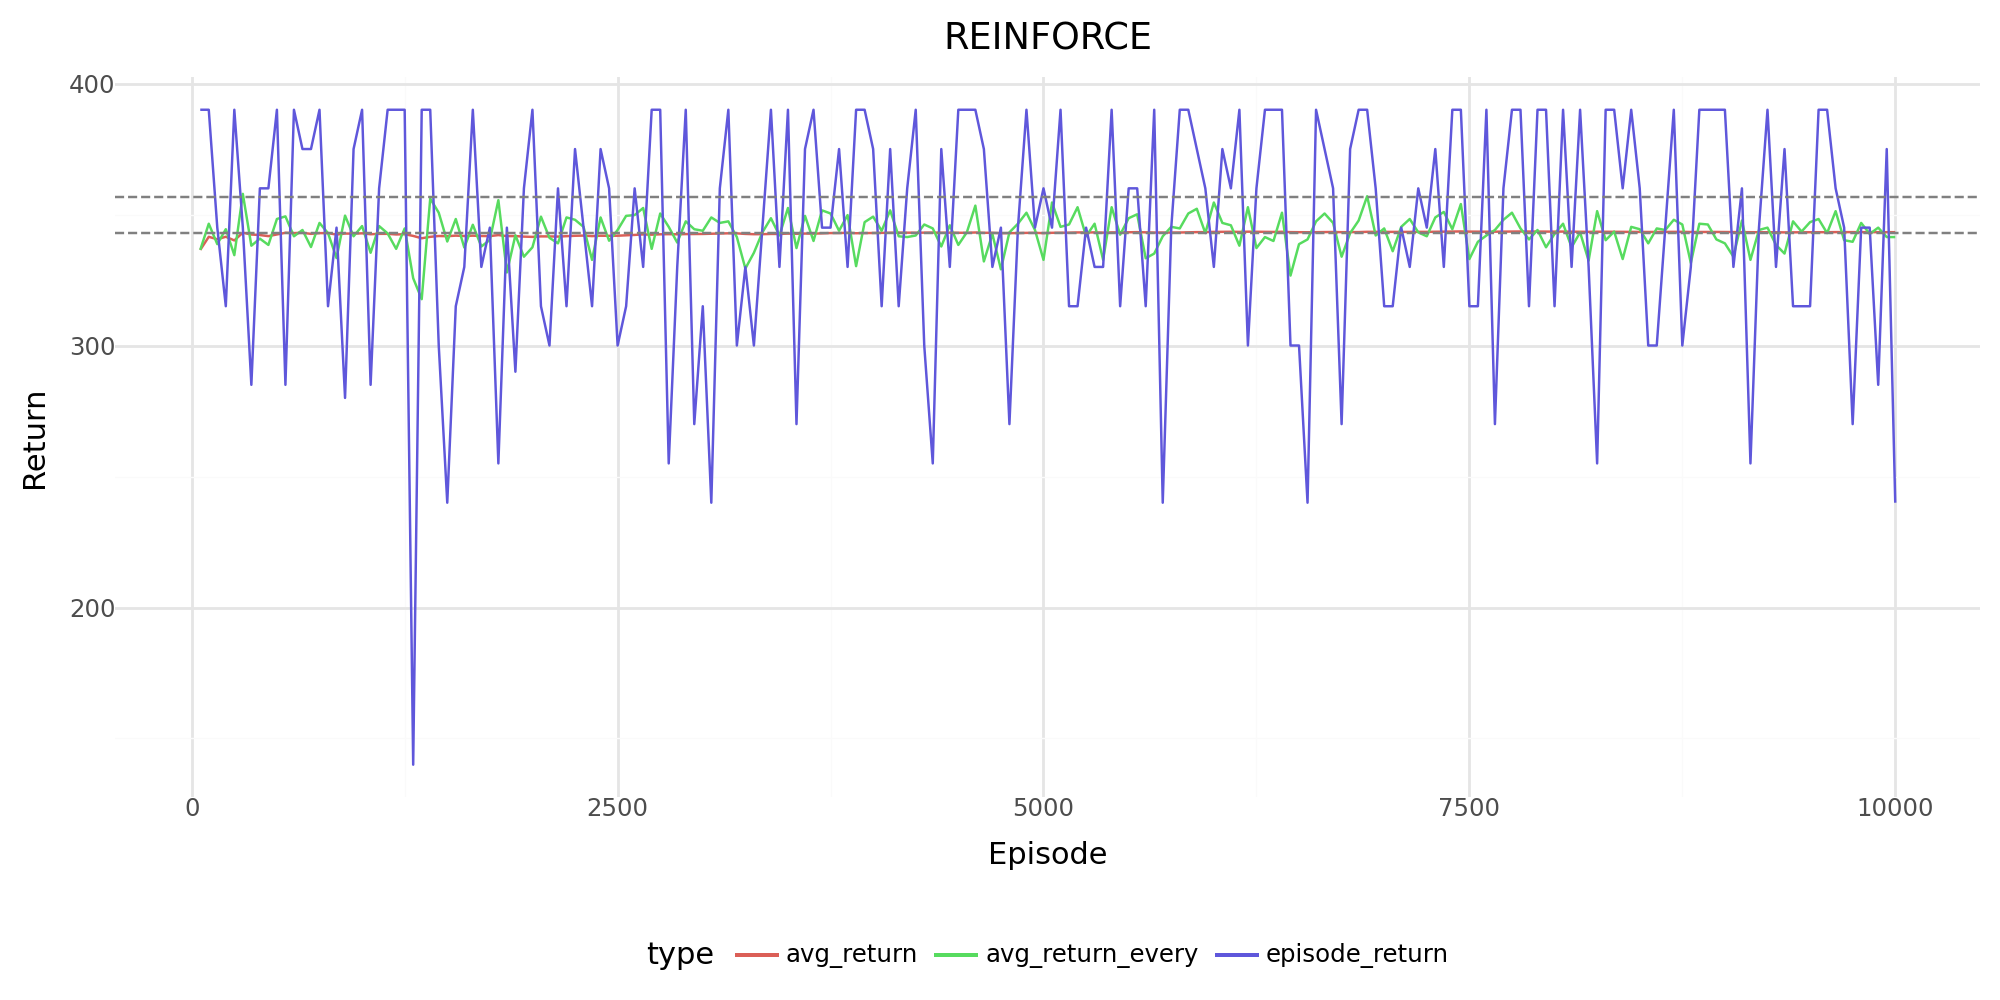

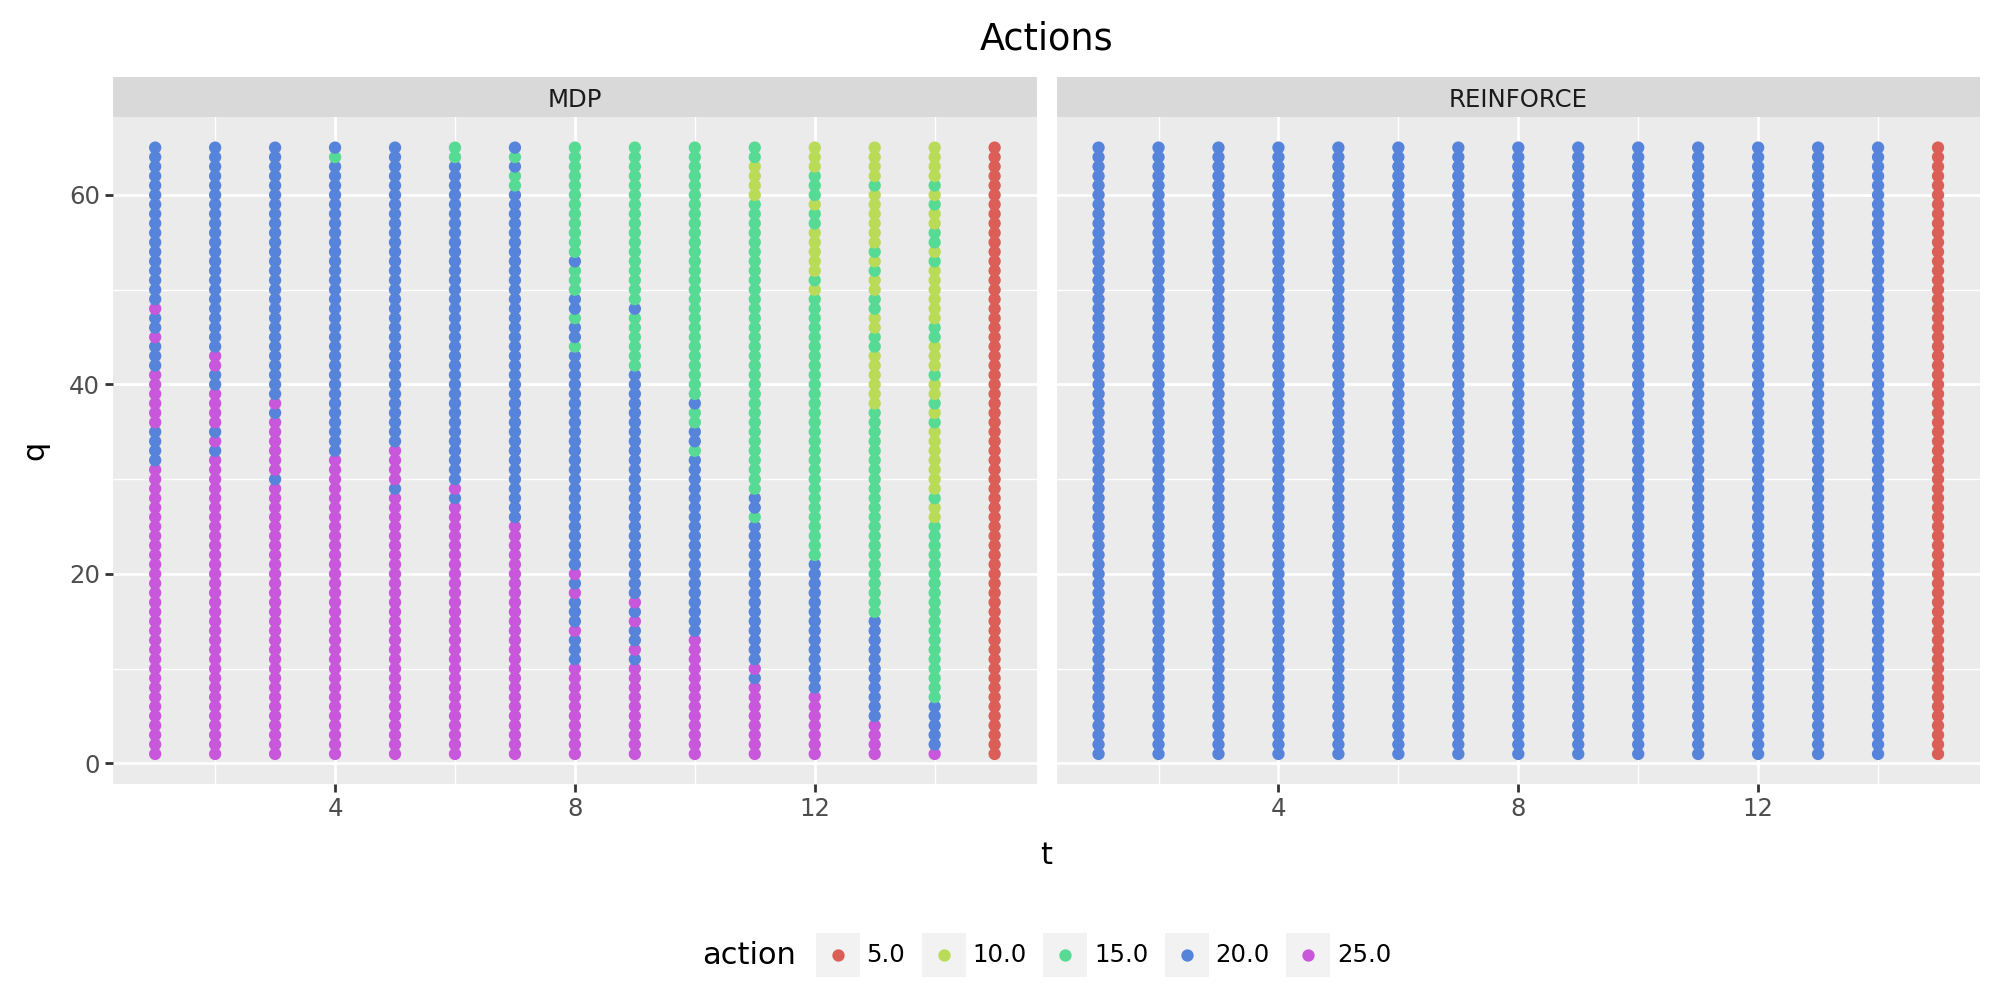

Theta: [[-2.04 -1.9  -0.33]
 [-2.19 -1.33 -0.75]
 [ 6.56  5.32  1.7 ]
 [-2.33 -2.09 -0.62]
 [ 0.    0.    0.  ]]
A few probability distributions:
State [65, 1]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-3.963
  price= 15.0, π(a|s)= 0.000 h(s,a)=-3.572
  price= 20.0, π(a|s)= 1.000 h(s,a)=11.995
  price= 25.0, π(a|s)= 0.000 h(s,a)=-4.461

State [1, 1]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-2.091
  price= 15.0, π(a|s)= 0.000 h(s,a)=-2.262
  price= 20.0, π(a|s)= 1.000 h(s,a)= 6.756
  price= 25.0, π(a|s)= 0.000 h(s,a)=-2.403

State [1, 14]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-2.378
  price= 15.0, π(a|s)= 0.000 h(s,a)=-2.909
  price= 20.0, π(a|s)= 1.000 h(s,a)= 8.228
  price= 25.0, π(a|s)= 0.000 h(s,a)=-2.941

State [65, 14]:
  price= 10.0, π(a|s)= 0.000 h(s,a)=-4.249
  price= 15.0, π(a|s)= 0.000 h(s,a)=-4.219
  price= 20.0, π(a|s)= 1.000 h(s,a)=13.468
  price= 25.0, π(a|s)= 0.000 h(s,a)=-4.999

State [2, 15]:
  price=  5.0, π(a|s)= 1.000 h(s,a)= 0.000



In [ ]:
# Define candidate sales prices
prices = [10, 15, 20, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=2e-3,  #1e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# Callback: store episode & avg return
def callback(pi_hat, info, trace):
    trace.append(info)

# Run REINFORCE
gamma = 1
episodes = 10000
trace_re_2e3 = []   # will hold dicts: {episode, avg_return}
reinforce(
    pi_hat=pi_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re_2e3
)

# Plot trace
def plot_results(pi_hat, trace, dat_mdp, title_r = "", print_dist = False, plot_policy = True, plot_hlines = True, plot_mdp = True):
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "return" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("episode", "r", color = "type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Episode",
            y="Return",
        )
    )
    if plot_hlines:
        pt = (
            pt
            + geom_hline(yintercept=v_opt, linetype="dashed", color="grey")
            + geom_hline(yintercept=v, linetype="dashed", color="grey")
        )
    pt.show()

    if plot_policy:
        dat_a = pd.DataFrame({'s': pi_hat.env.get_states()})
        dat_a = (
            dat_a
            >> mutate(
                q = X.s.apply(lambda s: s[0]),
                t = X.s.apply(lambda s: s[1]),
                action = [pi_hat.get_best_action(s) for s in dat_a['s']],
                alg = title_r
            )
            >> select(~X.s)
        )
        if plot_mdp:
            dat_a = dat_a >> bind_rows(dat_mdp >> select(~X.v) >> mutate(alg = "MDP"))
        dat_a['action'] = pd.Categorical(dat_a['action'])
        pt = (
            ggplot(dat_a, aes(x = "t", y = "q", color = "action"))
            + geom_point()
            + theme(figure_size=(10, 5), legend_position='bottom')
            + labs(title = "Actions")
        )
        if plot_mdp:
            pt = pt + facet_grid(cols="alg")
        pt.show()
    if print_dist:
        print(f"Theta: {pi_hat.theta.round(2)}")
        print("A few probability distributions:")
        test_states = [[65, 1], [1, 1], [1, 14], [65, 14], [2, 15]]
        for s in test_states:
            actions = pi_hat.env.get_actions(s)
            prefs = pi_hat.get_action_preferences(s)
            probs = pi_hat.get_probabilities(s)
            print(f"State {s}:")
            for a, p, pf in zip(actions, probs, prefs):
                print(f"  price={a:5.1f}, π(a|s)={p:6.3f} h(s,a)={pf:6.3f}")
            print()

plot_results(pi_hat, trace_re_2e3, dat_mdp, title_r = "REINFORCE", print_dist = True)

### Your turn

Explain the output.

*A plot of different rewards are given and the greedy policy is compared against the optimal policy. Here the vertical lines are the state-value of the starting state for the optimal and "set price to 20" policies. As can be seen the "set price to 20" is the policy the algorithm finds (which have a state-value close to the optimal). This is, also the optimal action taken given a probable sample path (top-left to bottom-right).
Finally, the estimated $\theta$ and set of probability distributions are given.*

The step-size may affect the algorithm much and also the starting seed of the environment.


=== Testing step-size α = 2e-05 ===


100%|██████████| 10000/10000 [00:15<00:00, 654.82it/s]



=== Testing step-size α = 0.0002 ===


100%|██████████| 10000/10000 [00:06<00:00, 1579.32it/s]



=== Testing step-size α = 0.0005 ===


100%|██████████| 10000/10000 [00:09<00:00, 1031.46it/s]



=== Testing step-size α = 0.001 ===


100%|██████████| 10000/10000 [00:14<00:00, 682.71it/s]



=== Testing step-size α = 0.002 ===


100%|██████████| 10000/10000 [00:17<00:00, 579.26it/s]


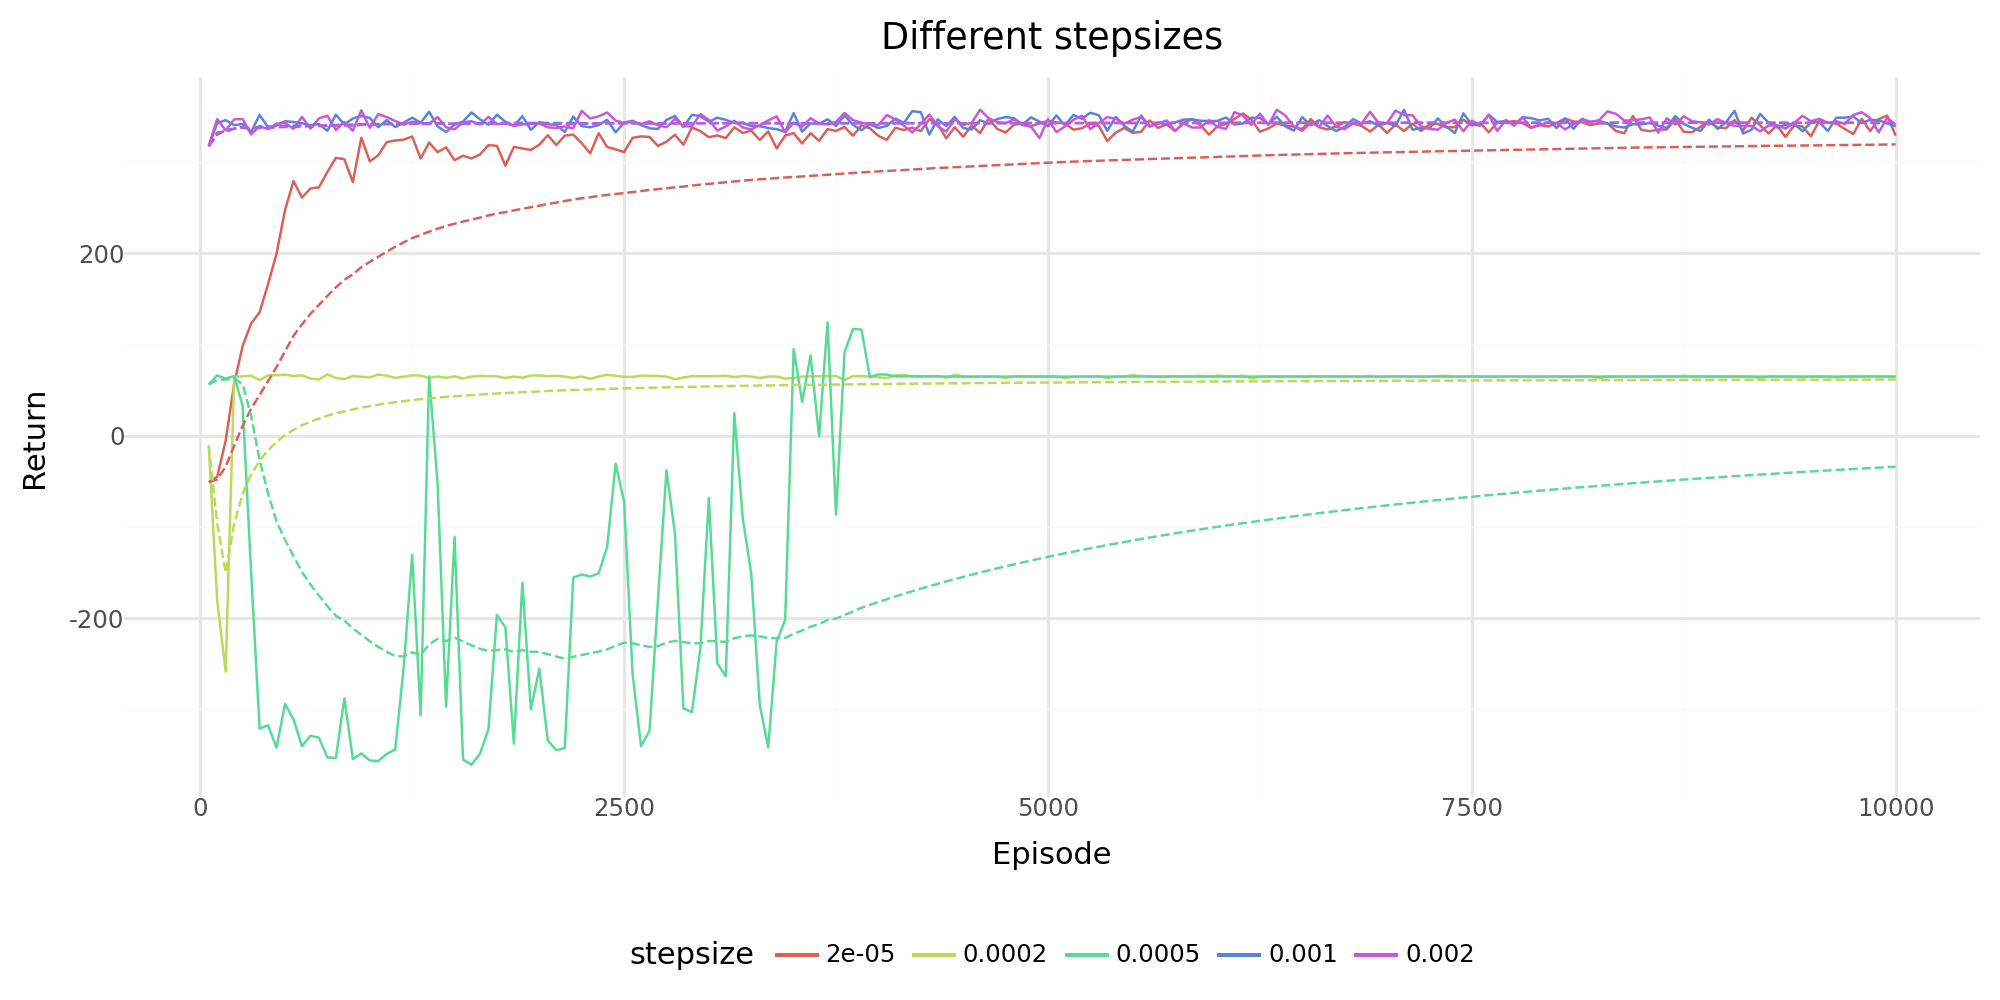

In [ ]:
def sweep_stepsizes(
    env,
    stepsizes,
    algorithm,
    gamma=gamma,
    episodes=episodes,
    rng_seed=42,
):
    results = []
    for alpha in stepsizes:
        print(f"\n=== Testing step-size α = {alpha} ===")

        # Fresh policy for each alpha
        pi_hat = SoftmaxPolicy(
            env=env,
            step_size=alpha,
            decay_fct=1.0,
            rng_seed=rng_seed,
        )
        def cb(policy, info, trace_list):
            trace_list.append({
                "stepsize": alpha,
                "episode": info["episode"],
                "avg_return": info["avg_return"],
                "avg_return_every": info["avg_return_every"],
            })
        trace = []
        algorithm(
            pi_hat=pi_hat,
            episodes=episodes,
            gamma=gamma,
            callback=cb,
            callback_every=50,
            trace=trace,
        )
        results.extend(trace)
    dat_r = pd.DataFrame(results)
    dat_r['stepsize'] = pd.Categorical(dat_r['stepsize'])
    pt = (
        dat_r
        >> ggplot(aes(x = "episode", y = "avg_return_every", color = "stepsize"))
        + geom_line()
        + geom_line(aes(y = "avg_return"), linetype = "dashed")
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title="Different stepsizes",
            x="Episode",
            y="Return",
        )
    )
    pt.show()

env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=42
)

stepsizes = [2e-5, 2e-4, 5e-4, 1e-3, 2e-3]
sweep_stepsizes(
    env=env,
    stepsizes=stepsizes,
    algorithm=reinforce,
)




# def plot_traces(traces, names):
#     dat_r = pd.DataFrame()
#     for trace, name in zip(traces, names):
#         dat = pd.DataFrame(trace) >> mutate(alg = name)
#         dat_r = pd.concat([dat_r, dat], ignore_index=True)
#     pt = (
#         dat_r
#         >> ggplot(aes(x = "episode", y = "avg_return_every", color = "alg"))
#         + geom_line()
#         + geom_line(aes(y = "avg_return"), linetype = "dashed")
#         + theme_minimal()
#         + theme(figure_size=(10, 5), legend_position='bottom')
#         + labs(
#             title="Different algorithms",
#             x="Episode",
#             y="Return",
#         )
#     )
#     pt.show()

# plot_traces([trace_re, trace_re_2e2], [f"REINFORCE $\\alpha = 0.001$", "REINFORCE $\\alpha = 0.0001$"])

### Your turn

Comment on the results.

*Step size affect the learning rate and different env seeds may give different results. As seen we may end up in local maxima which are bad.*

## REINFORCE with baseline

We are now ready to implement REINFORCE

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1304_REINFORCE_With_Baseline.png)

First, consider this implementation.

In [ ]:
#@title Reinforce w average baseline

def reinforce_w_avg_baseline(
    pi_hat,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """Runs the REINFORCE algorithm with a given policy, using a scalar baseline.

    This uses the episodic, discounted REINFORCE algorithm as in Sutton &
    Barto (2nd ed.), with the update:

        θ ← θ + α * (γ^t) * (G_t - b) * ∇θ log π(A_t | S_t; θ),

    where G_t is the discounted return from time t and b is a baseline that
    does not depend on the action (here: running average of past episode returns).

    Args:
        pi_hat: Policy object implementing get_action() and train().
        episodes: Number of episodes to run.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
            Signature: callback(pi_hat, info, trace).
        callback_every: Frequency of callback in episodes. If 0, callback
            is never called.
        trace: Optional object passed through to callback (e.g., list or
            dict for logging).
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generates one episode using the current policy.

        Args:
            policy: Policy used to generate actions.

        Returns:
            A list of (s, a, r) tuples for one episode.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0
    baseline = 0.0  # running average of past episode returns

    for ep in tqdm(range(1, episodes + 1)):
        trajectory = generate_episode(pi_hat)

        # Compute returns G_t backward and update policy
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t

            # Baseline REINFORCE: (G_t - b)
            advantage_t = G_t - baseline
            mult = (gamma ** t) * advantage_t

            pi_hat.train(s_t, a_t, mult)

        # At the end of the backward pass, G_t is the return from t=0
        episode_return = G_t
        total_return += episode_return
        total_return_every += episode_return
        baseline = total_return / ep

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "diff_return": advantage_t,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


### Your turn

Which baseline is used?

*Here we use the average reward estimate as a baseline.*

100%|██████████| 10000/10000 [00:17<00:00, 563.43it/s]


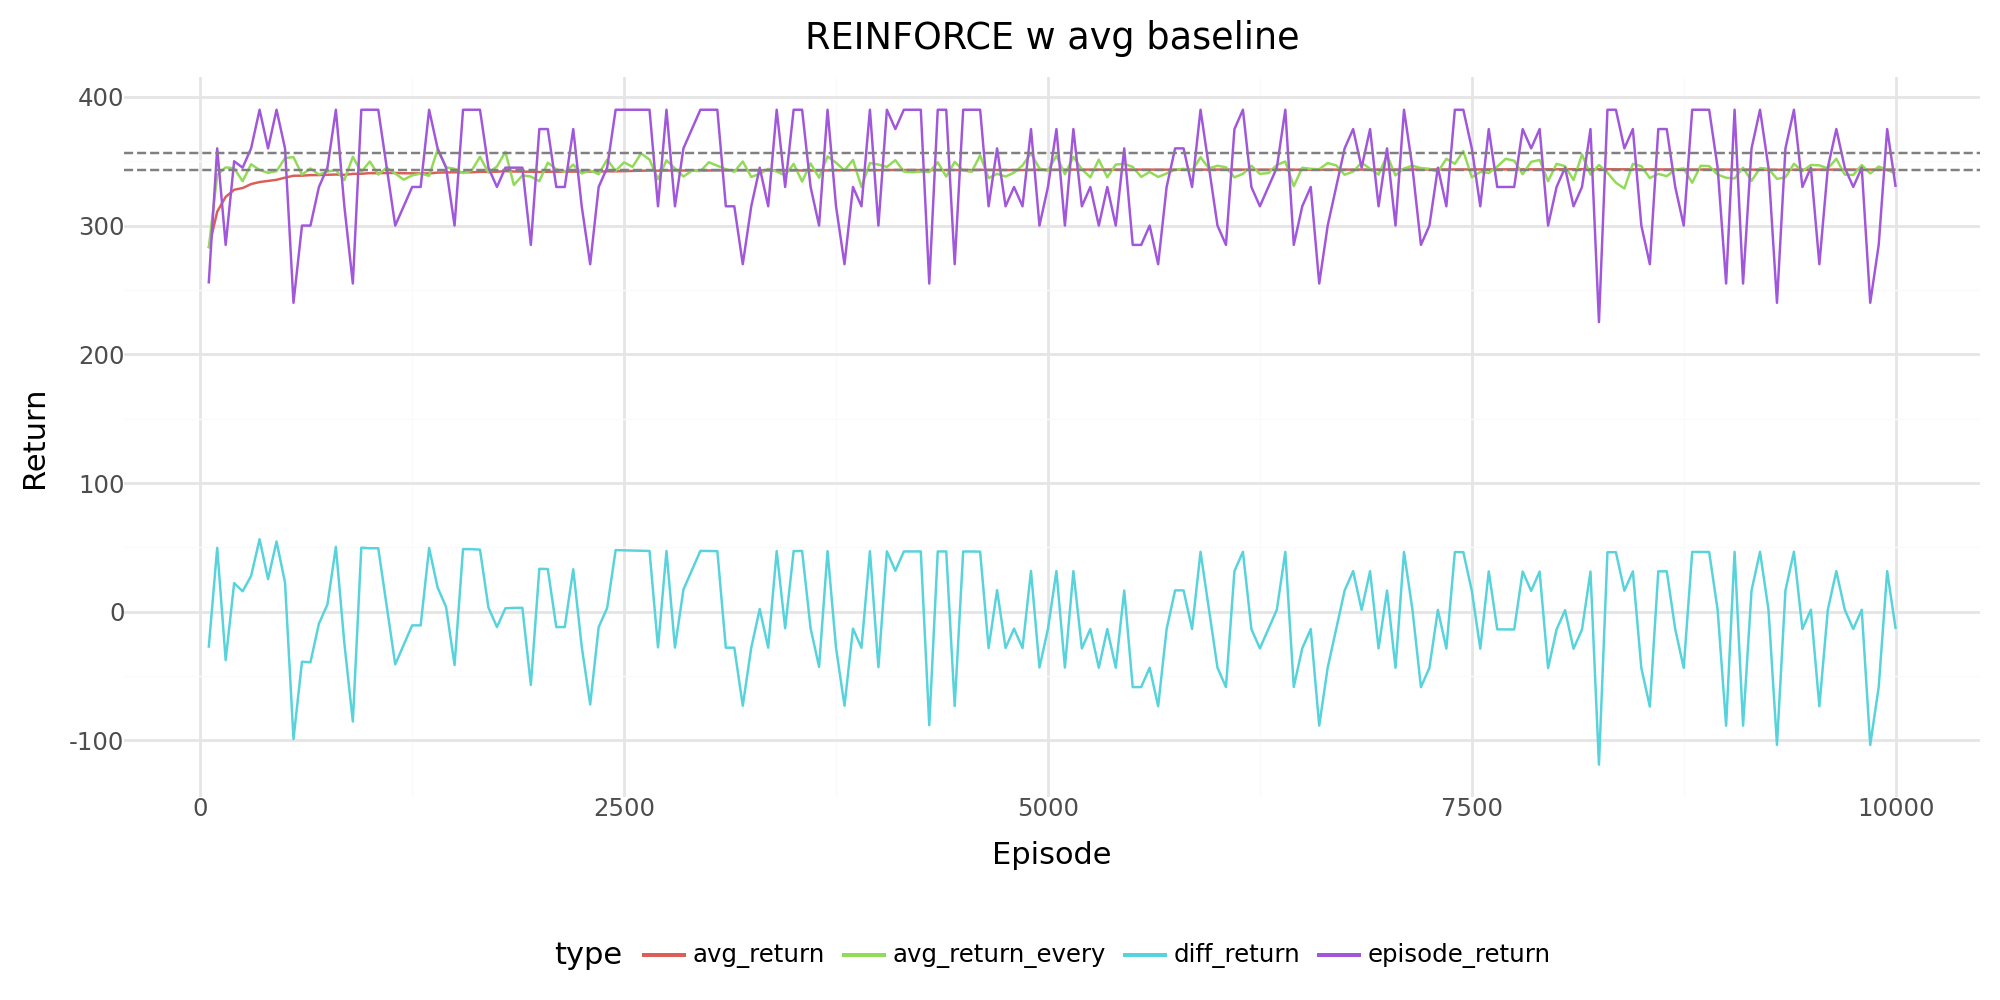

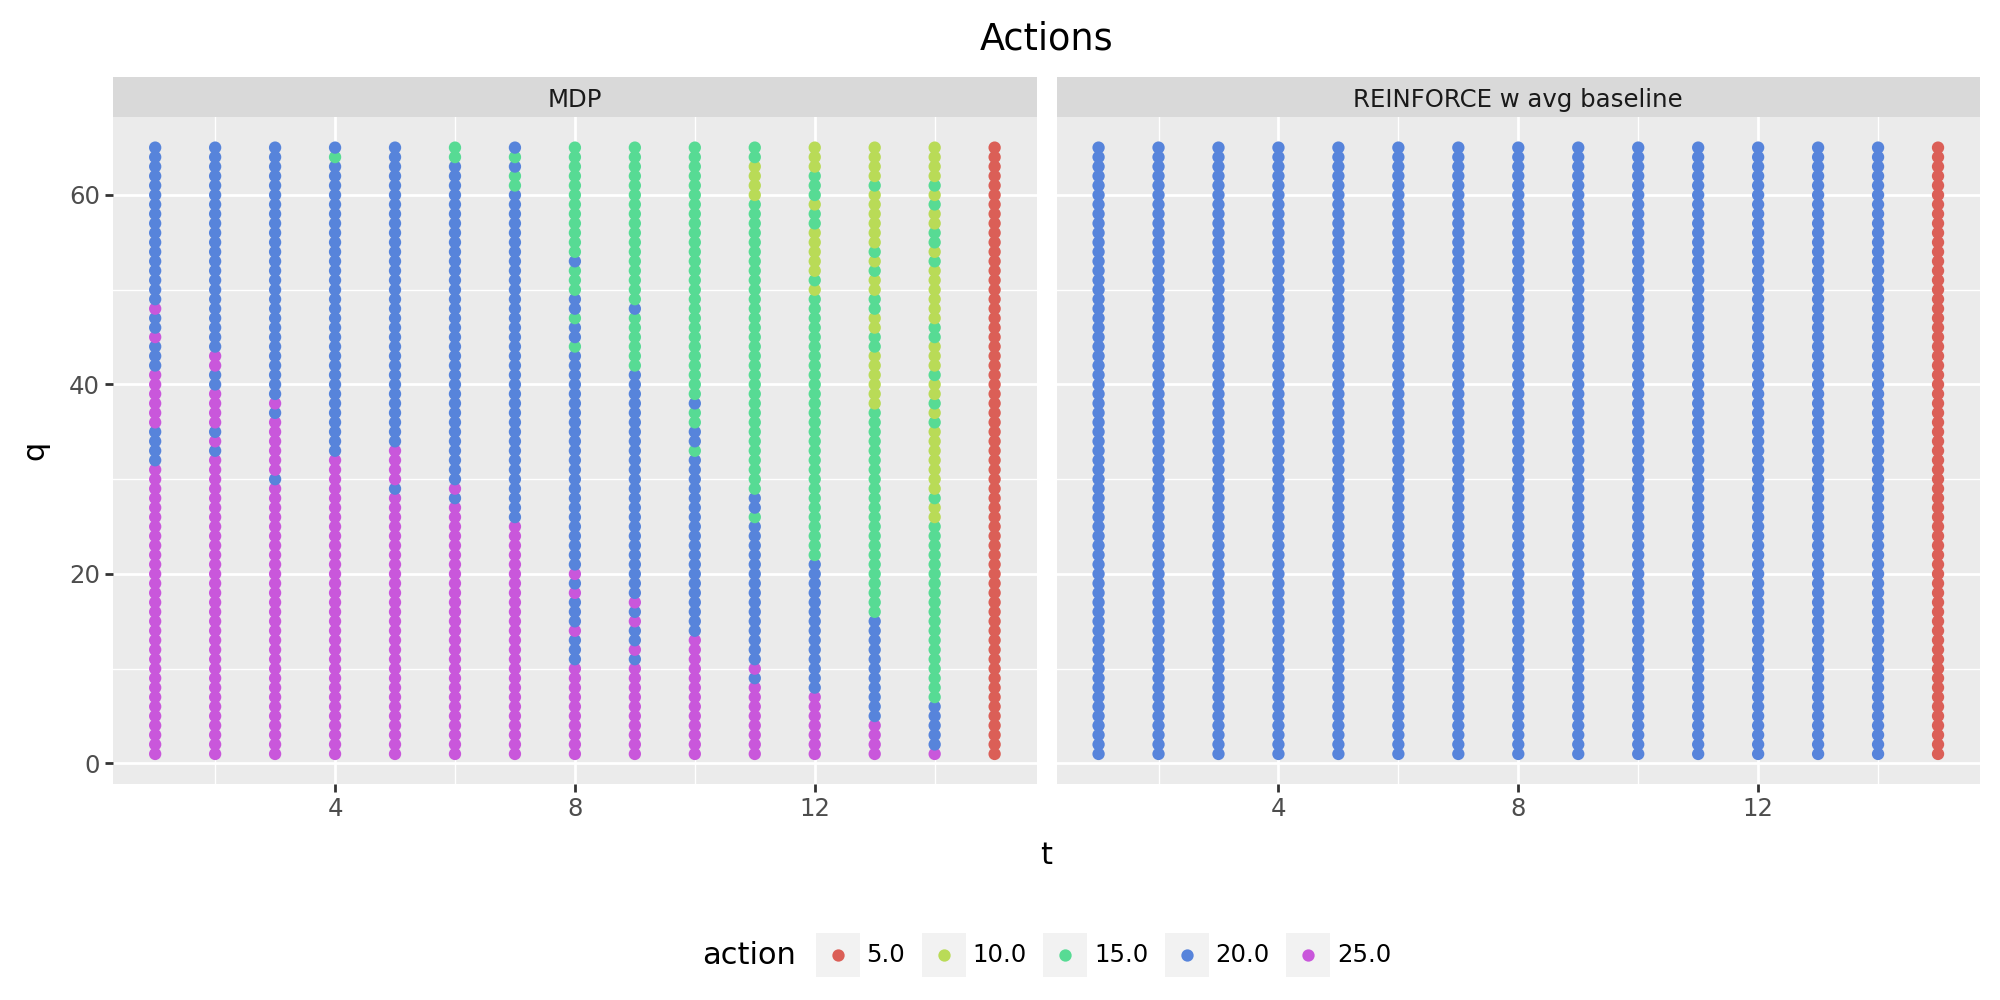

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=1e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# Run REINFORCE w baseline
trace_re_bl = []
reinforce_w_avg_baseline(
    pi_hat=pi_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re_bl
)
plot_results(pi_hat, trace_re_bl, dat_mdp, title_r = "REINFORCE w avg baseline")


=== Testing step-size α = 2e-05 ===


100%|██████████| 10000/10000 [00:14<00:00, 712.22it/s]



=== Testing step-size α = 0.0002 ===


100%|██████████| 10000/10000 [00:15<00:00, 653.46it/s]



=== Testing step-size α = 0.0005 ===


100%|██████████| 10000/10000 [00:06<00:00, 1623.26it/s]



=== Testing step-size α = 0.001 ===


100%|██████████| 10000/10000 [00:14<00:00, 690.29it/s]



=== Testing step-size α = 0.002 ===


100%|██████████| 10000/10000 [00:05<00:00, 1706.93it/s]


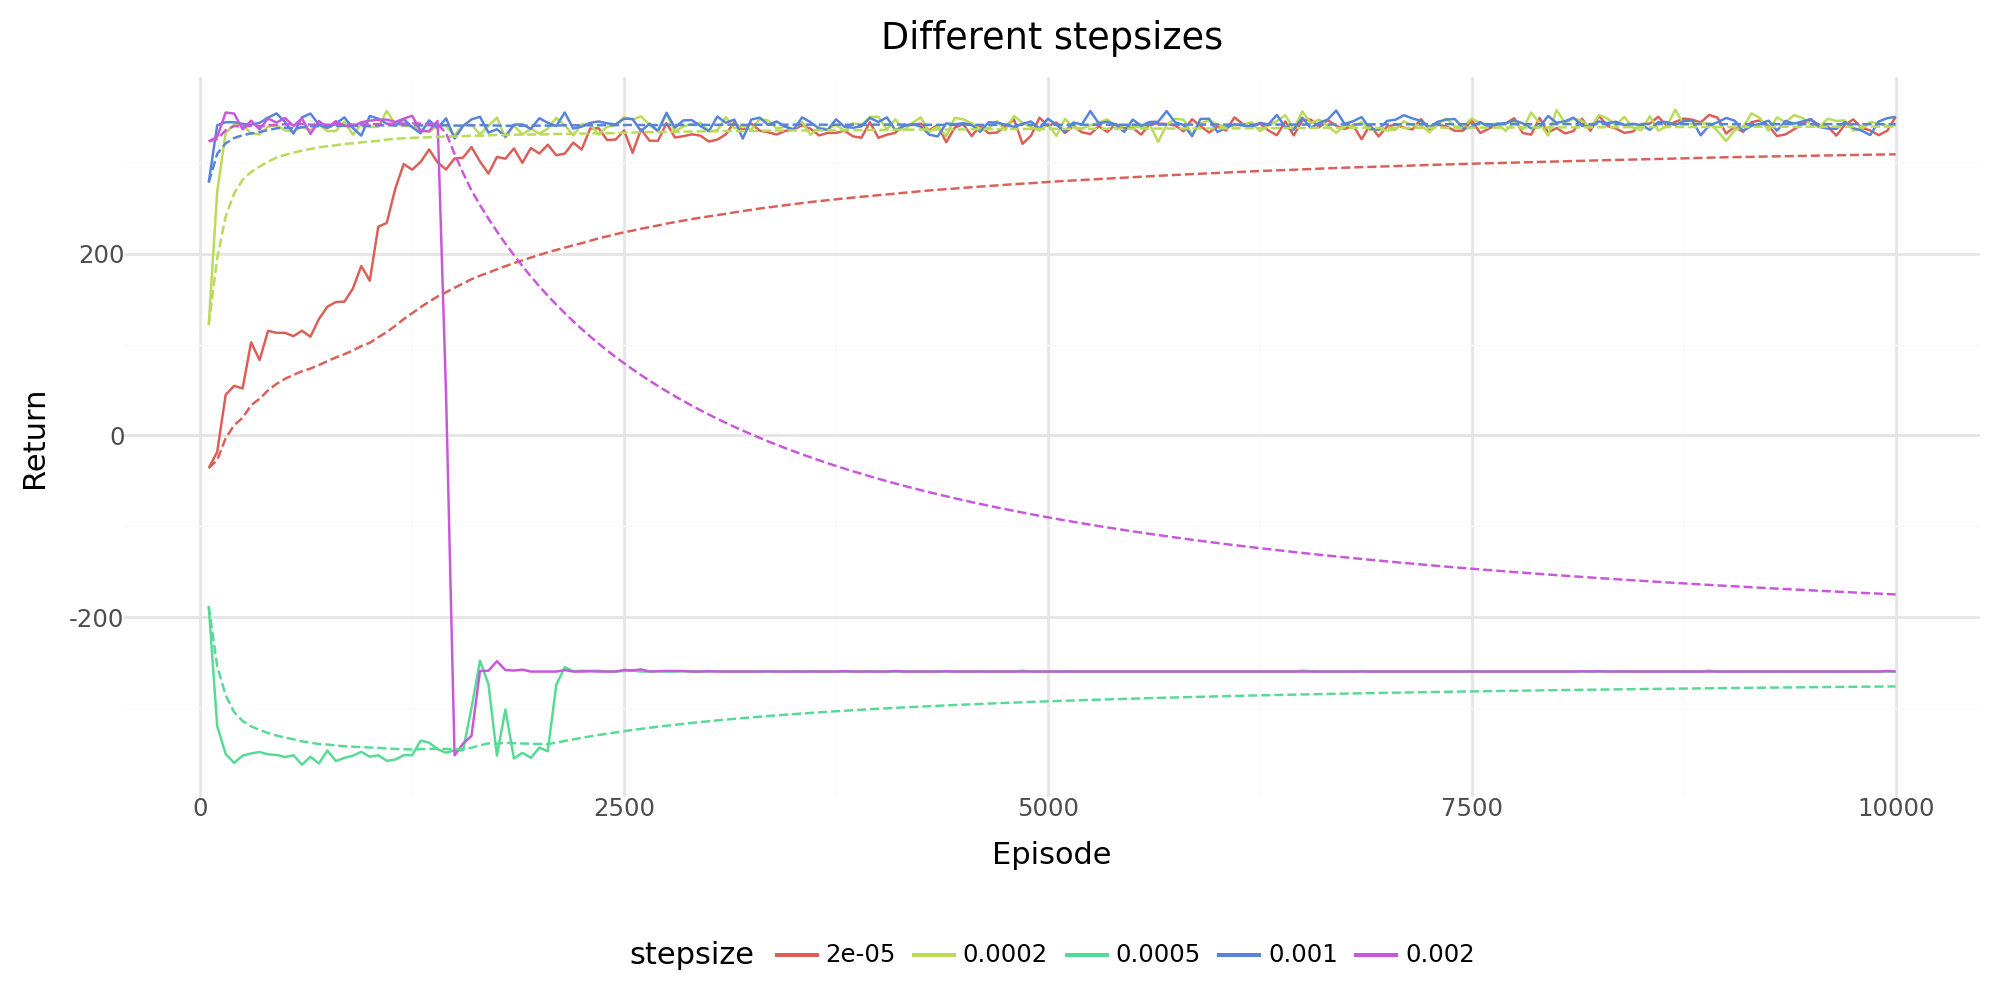

In [ ]:
stepsizes = [2e-5, 2e-4, 5e-4, 1e-3, 2e-3]
sweep_stepsizes(
    env=env,
    stepsizes=stepsizes,
    algorithm=reinforce_w_avg_baseline,
)

### Your turn

Why will this reduce variance in updates?

*Now is subtract the average and hence G_t - baseline fluctuates on a smaller scale (se plot).*

A state-value baseline can also be used. Let us define a state-value linear approximation.

In [ ]:
class ValueFunction:
    """
    Quadratic (degree-2) polynomial state-value function:

        v(s) = wᵀ x(s)

    with features:
        x(s) = [1,
                q_norm,
                t_norm,
                q_norm^2,
                t_norm^2,
                q_norm * t_norm]
    """

    def __init__(self, env, step_size: float) -> None:
        """
        Initialize the approximator.

        Parameters
        ----------
        env : Environment
            Must have attributes max_inv and max_t.
        step_size : float
            Learning rate for the critic.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        self.alpha_v = float(step_size)

        # 1 + 2 + 3 = 6 polynomial features
        self.w = np.zeros(6, dtype=float)

    def get_features(self, s: Sequence[int]) -> np.ndarray:
        """
        Construct polynomial degree-2 features for state s = [q, t].
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        return np.array(
            [
                1.0,        # bias
                qn,         # q
                tn,         # t
                qn * qn,    # q^2
                tn * tn,    # t^2
                qn * tn     # q t
            ],
            dtype=float
        )

    def eval(self, s: Sequence[int]) -> float:
        """Estimate v(s)."""
        x_s = self.get_features(s)
        return float(np.dot(self.w, x_s))

    def train(self, s: Sequence[int], target: float) -> None:
        """
        Semi-gradient Monte Carlo update:

            w <- w + alpha * (target - v(s)) * x(s)
        """
        x_s = self.get_features(s)
        v_hat = float(np.dot(self.w, x_s))
        delta = target - v_hat
        self.w += self.alpha_v * delta * x_s


In [ ]:
#@title Reinforce w value baseline

def reinforce_w_value_baseline(
    pi_hat,
    v_hat,
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """REINFORCE with a state-dependent baseline v_hat(s).

    Actor update:
        θ ← θ + α_θ * (γ^t) * (G_t - v_hat(s_t)) * ∇θ log π(a_t | s_t; θ)

    Critic update (Monte Carlo):
        w ← w + α_v * (G_t - v_hat(s_t)) ∇_w v_hat(s_t)

    Args:
        pi_hat: Policy approximator (actor).
        v_hat: State-value approximator (critic / baseline).
        episodes: Number of episodes.
        gamma: Discount factor γ in [0, 1].
        callback: Optional function called every `callback_every` episodes.
        callback_every: Frequency of callback in episodes; 0 disables callback.
        trace: Optional object passed to callback for logging.
    """

    def generate_episode(policy: SoftmaxPolicy) -> list[tuple]:
        """Generate one episode using the current policy.

        Returns:
            List of (s, a, r) tuples.
        """
        s = policy.env.reset()
        trajectory: list[tuple] = []
        done = False

        while not done:
            a = policy.get_action(s)
            s_next, r, done = policy.env.get_step(s, a)
            trajectory.append((s, a, r))
            s = s_next

        return trajectory

    total_return = 0.0
    total_return_every = 0.0

    for ep in range(1, episodes + 1):
        trajectory = generate_episode(pi_hat)

        # Backward pass: compute G_t and update actor + critic
        G_t = 0.0
        for t in reversed(range(len(trajectory))):
            s_t, a_t, r_t = trajectory[t]
            G_t = r_t + gamma * G_t

            # Baseline: state-dependent value estimate
            b_t = v_hat.eval(s_t)
            advantage_t = G_t - b_t

            # Actor update multiplier corresponds to γ^t * advantage_t
            mult = (gamma ** t) * advantage_t
            pi_hat.train(s_t, a_t, mult)

            # Critic update toward Monte Carlo target G_t
            v_hat.train(s_t, G_t)

        episode_return = G_t  # return from t=0 after loop
        total_return += episode_return
        total_return_every += episode_return

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "diff_return": advantage_t,
                "approx return (v(s))": b_t,
                "episode_return": episode_return,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


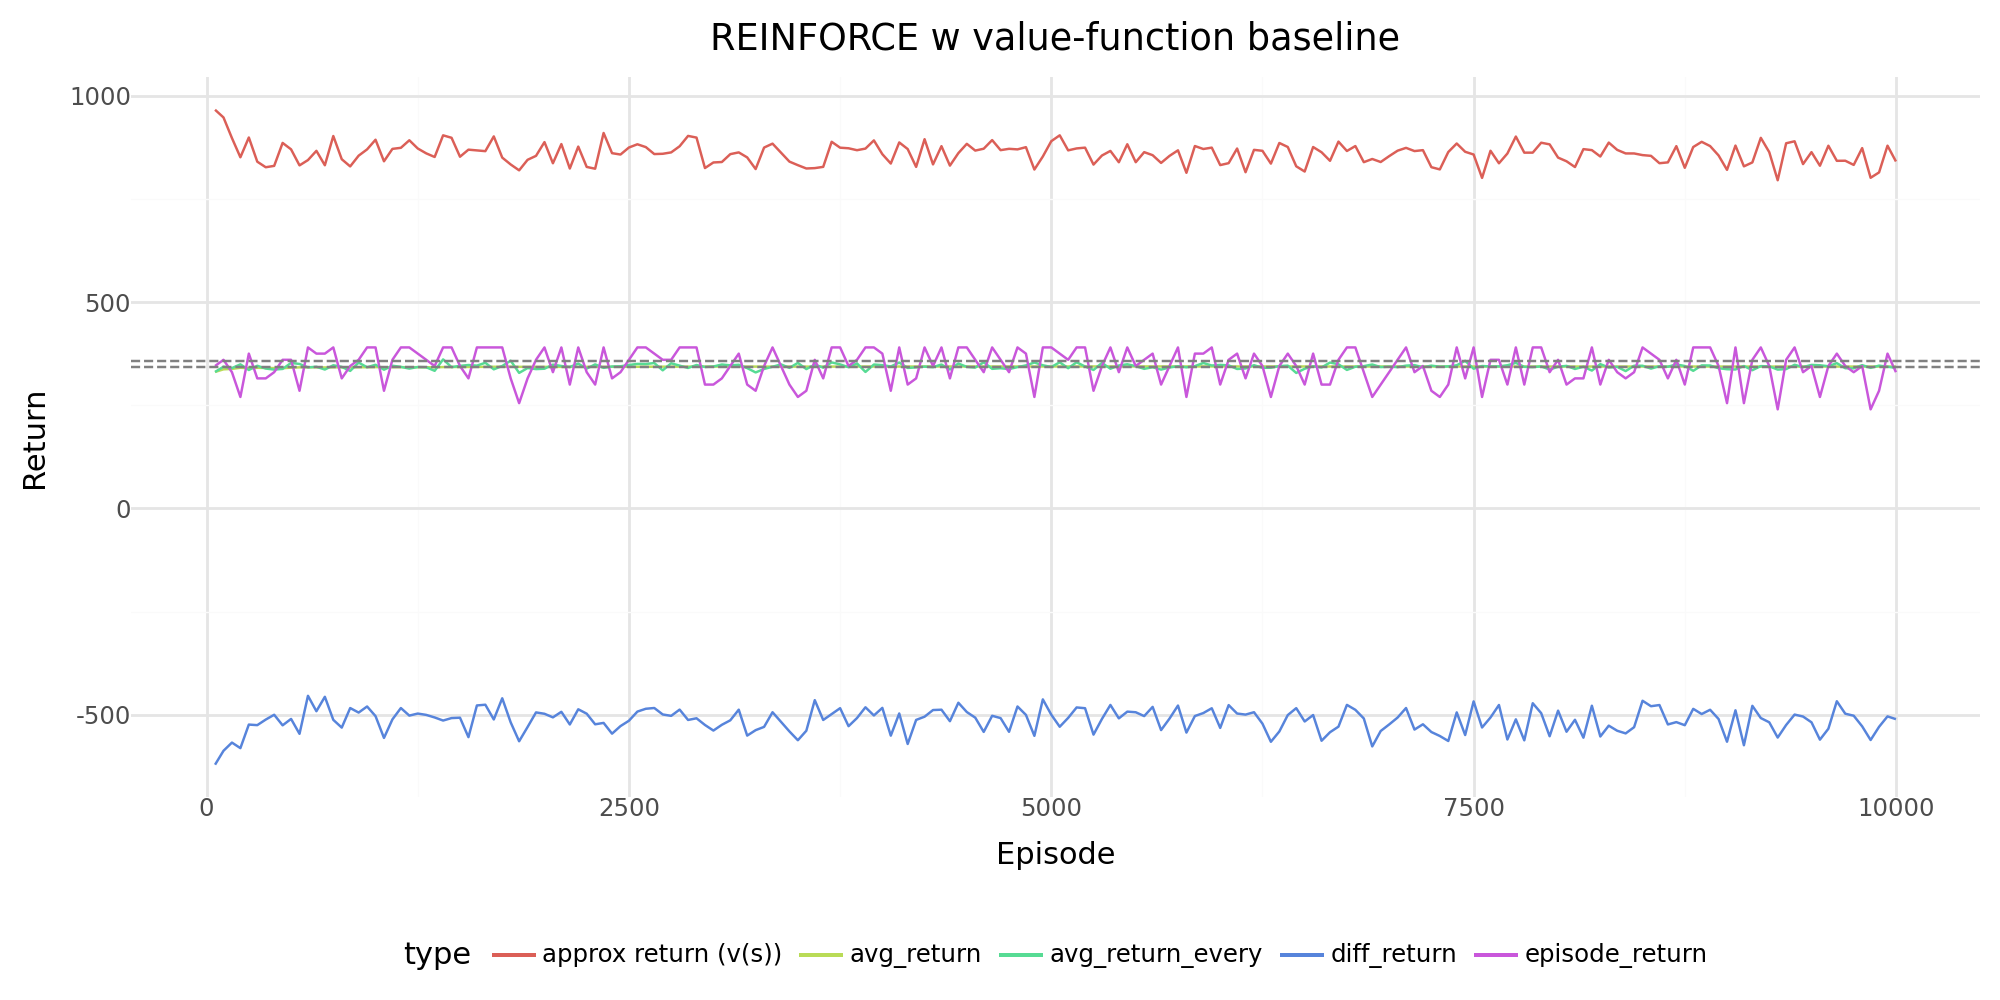

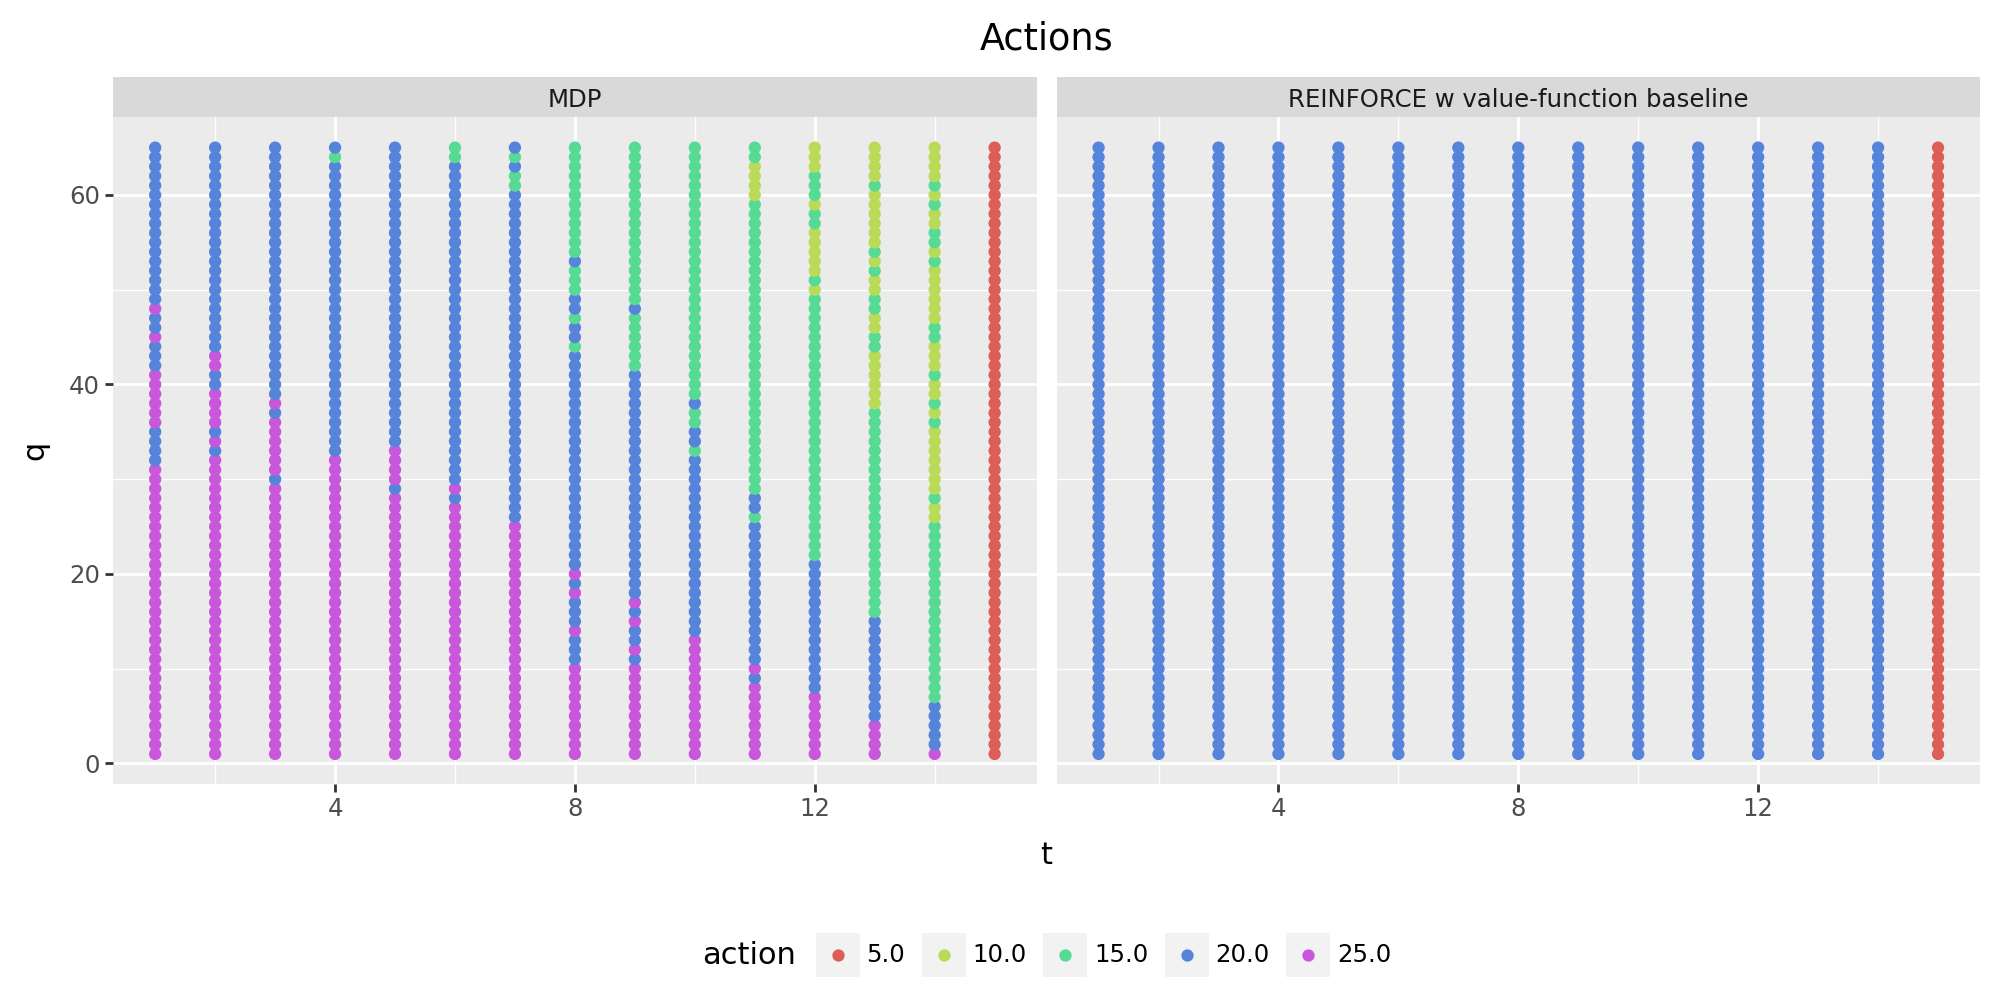

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=2e-3,
    decay_fct=1.0,
    rng_seed=42,
)

# value function (critic / baseline)
v_hat = ValueFunction(
    env=env,
    step_size=5e-2,   # often a bit larger than actor step size
)

# Run REINFORCE w baseline
trace_re_v_bl = []   # will hold dicts: {episode, avg_return}
reinforce_w_value_baseline(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_re_v_bl
)
plot_results(pi_hat, trace_re_v_bl, dat_mdp, title_r = "REINFORCE w value-function baseline")

### Your turn

Describe the output.

*The value approx. we use gives a poor approximation of the avg. return, but since it is just used as a baseline it still works.*



## Actor Critic

Let us inplement the actor critic algorithm

![alg fig](https://raw.githubusercontent.com/bss-osca/rl/refs/heads/master/book/img/1305a_One_Step_Actor_Critic.png)



In [ ]:
#@title Actor-critic algorithm

def actor_critic(
    pi_hat: SoftmaxPolicy,
    v_hat,  # e.g. ValueFunctionPoly2
    episodes: int,
    gamma: float,
    callback: Optional[Callable[[SoftmaxPolicy, dict, Any], None]] = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """One-step (TD(0)) actor–critic with discount factor I (γ^t) as in the first
    boxed algorithm in the actor–critic section.

    Critic (TD(0)):
        δ_t = R_{t+1} + γ v_hat(S_{t+1}) - v_hat(S_t)
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ I δ_t ∇_θ log π(A_t | S_t)
        I ← γ I

    where I starts at 1 at the beginning of each episode.

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with value(s) and update(s, target).
        episodes: Number of episodes.
        gamma: Discount factor γ.
        callback: Optional logging callback.
        callback_every: Callback frequency (episodes).
        trace: Passed through to callback.
    """

    total_return = 0.0
    total_return_every = 0.0

    for ep in tqdm(range(1, episodes + 1)):
        s = pi_hat.env.reset()
        done = False

        I = 1.0  # discount factor I = γ^t
        G_episode = 0.0
        t = 0

        while not done:
            # Sample action from current policy
            a = pi_hat.get_action(s)

            # Environment step
            s_next, r, done = pi_hat.env.get_step(s, a)

            # Critic: TD target and error
            v_s = v_hat.eval(s)
            v_s_next = 0.0 if done else v_hat.eval(s_next)
            td_target = r + gamma * v_s_next
            delta_t = td_target - v_s

            # Actor: update with I * δ_t
            mult = I * delta_t
            pi_hat.train(s, a, mult)

            # Critic: update toward td_target (semi-gradient TD(0))
            v_hat.train(s, td_target)

            # Update discount factor and bookkeeping
            G_episode += I * r
            I *= gamma       # I = γ^(t+1)
            s = s_next
            t += 1

        total_return += G_episode
        total_return_every += G_episode

        if (
            callback is not None
            and callback_every > 0
            and ep % callback_every == 0
        ):
            info = {
                "episode": ep,
                "avg_return": total_return / ep,
                "episode_return": G_episode,
                "avg_return_every": total_return_every / callback_every,
                "callback_every": callback_every,
                "approx_return": v_hat.eval(pi_hat.env.reset())
            }
            total_return_every = 0.0
            callback(pi_hat, info, trace)


100%|██████████| 10000/10000 [00:23<00:00, 422.65it/s]


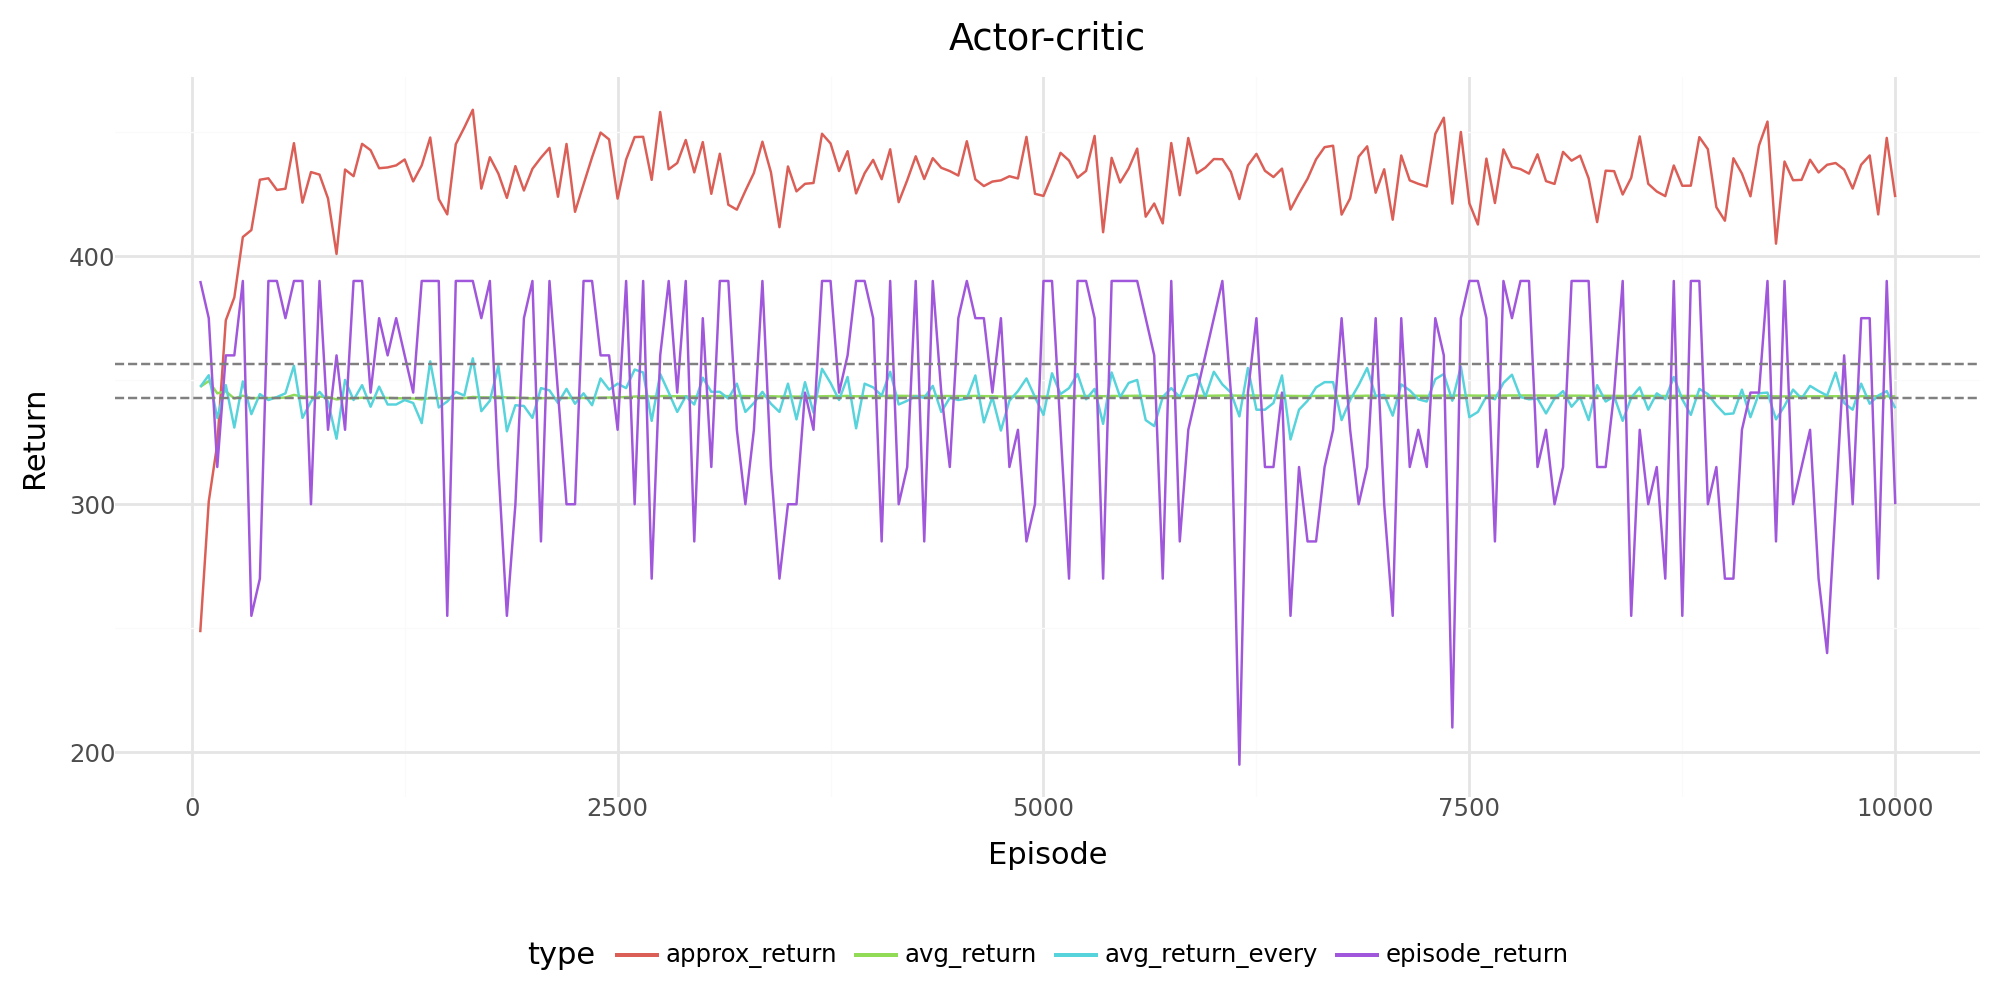

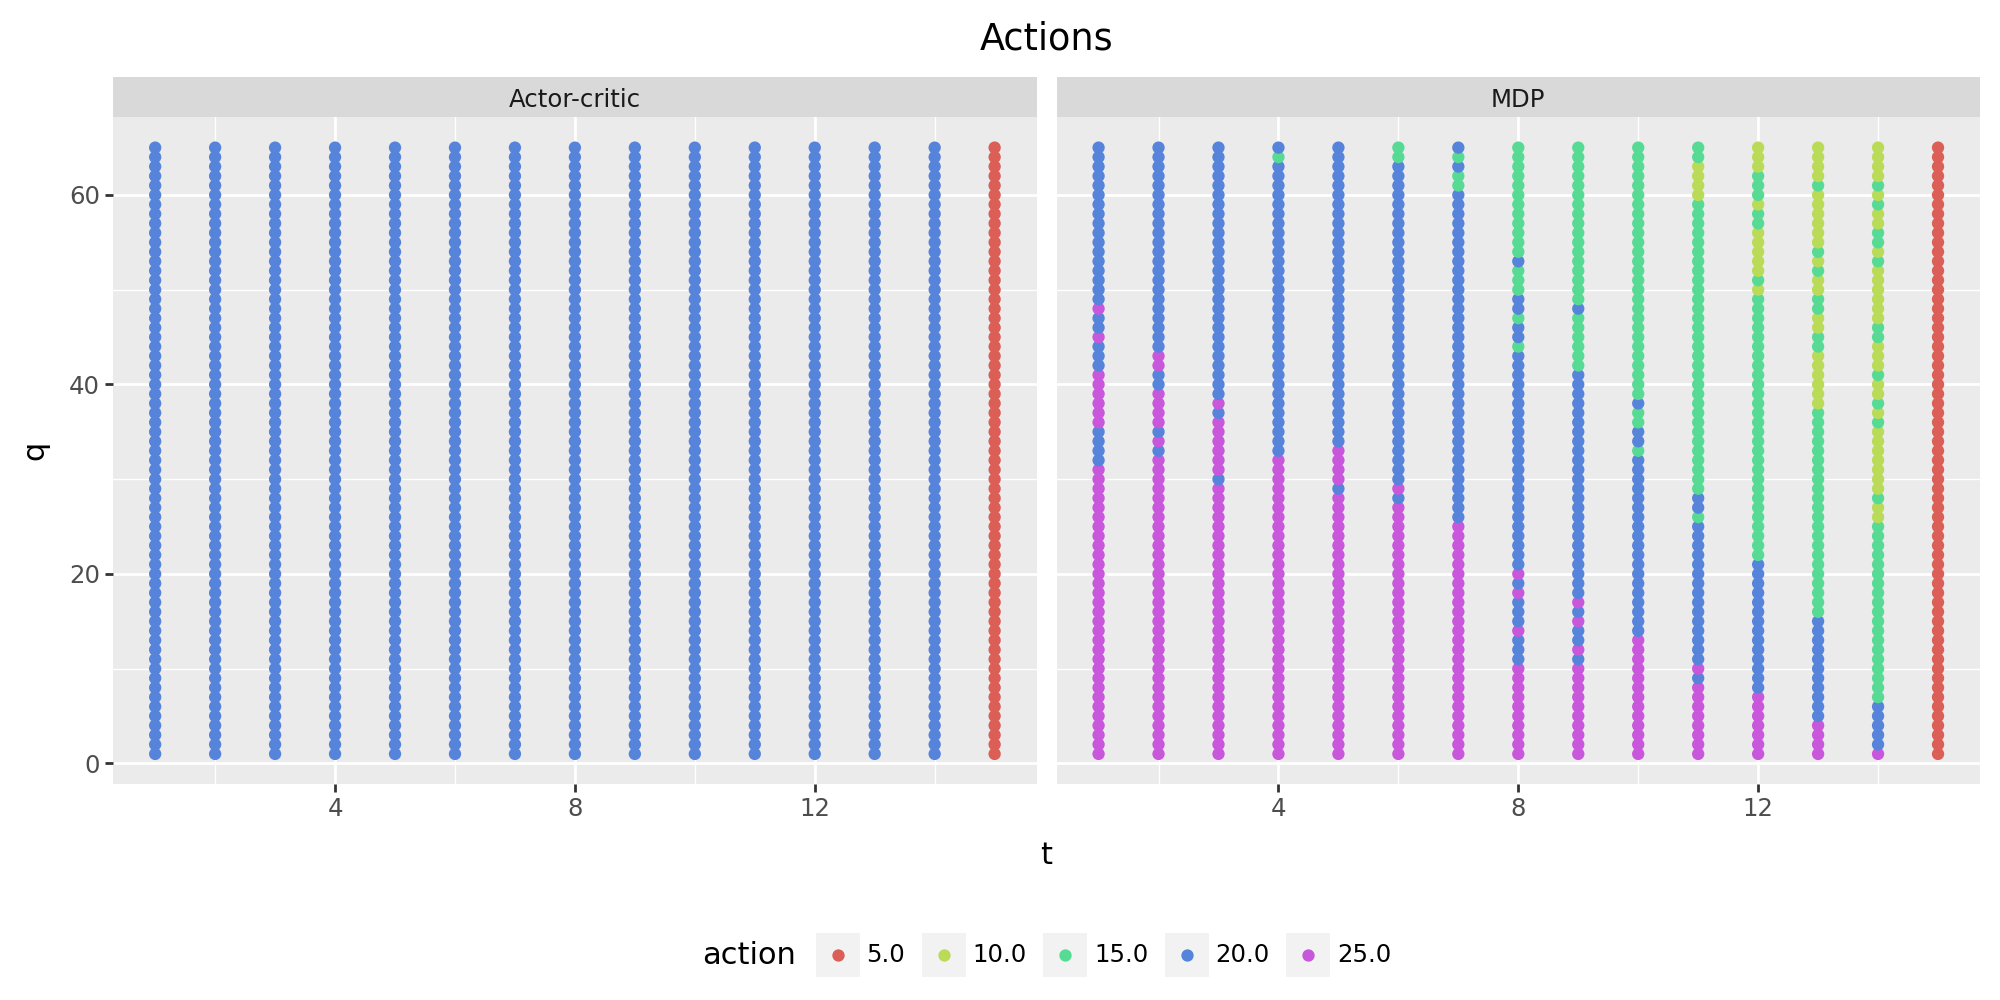

In [ ]:
# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=5.0,
    purchase_price=14.0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
pi_hat = SoftmaxPolicy(
    env=env,
    step_size=0.01,
    decay_fct=1.0,
    rng_seed=42,
)

# value function (critic / baseline)
v_hat = ValueFunction(
    env=env,
    step_size=0.05,   # often a bit larger than actor step size
)

# Run REINFORCE w baseline
trace_ac = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=episodes,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac
)
plot_results(pi_hat, trace_ac, dat_mdp, title_r = "Actor-critic")

### Your turn

Explain the output.

*Bootstrapping makes the value approximation better.*

## Comparison - All algorithms

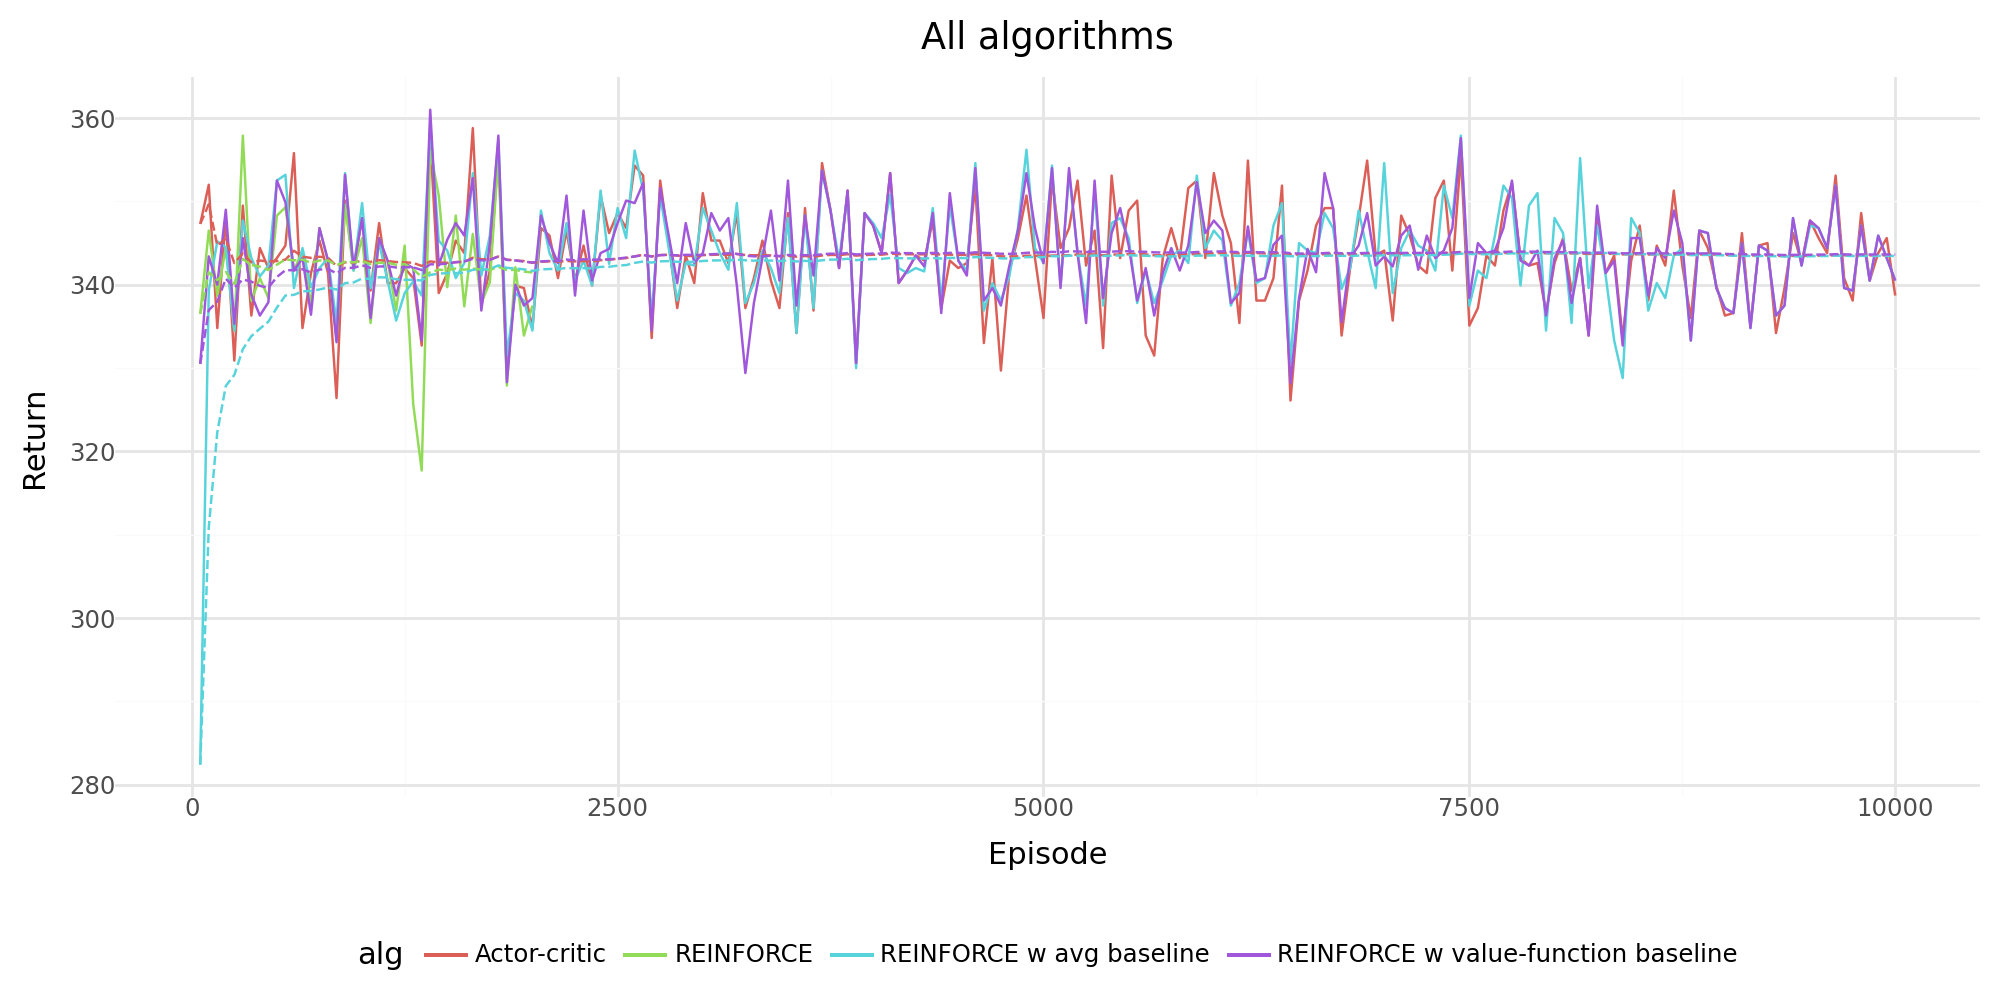

In [ ]:
dat_r = pd.DataFrame()
dat = pd.DataFrame(trace_re) >> mutate(alg = "REINFORCE")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_re_bl) >> mutate(alg = "REINFORCE w avg baseline")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_re_v_bl) >> mutate(alg = "REINFORCE w value-function baseline")
dat_r = pd.concat([dat_r, dat], ignore_index=True)
dat = pd.DataFrame(trace_ac) >> mutate(alg = "Actor-critic")
dat_r = pd.concat([dat_r, dat], ignore_index=True)

pt = (
    dat_r
    >> ggplot(aes(x = "episode", y = "avg_return_every", color = "alg"))
    + geom_line()
    + geom_line(aes(y = "avg_return"), linetype = "dashed")
    + theme_minimal()
    + theme(figure_size=(10, 5), legend_position='bottom')
    + labs(
        title="All algorithms",
        x="Episode",
        y="Return",
    )
)
pt.show()


## Other approximations

Other state-value and policy approximations can be used. Here we define a few and test.

In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyTabular:
    """
    Softmax policy with a separate parameter for each (state, action) pair.

    For each action a and state s, there is a scalar weight θ[a, idx(s)].
    The preference function is:

        h(s, a) = θ[a, idx(s)]

    where idx(s) is a unique integer index for the state s = [q, t].
    Effectively, this corresponds to a one-hot state feature vector.
    """

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Initialize the tabular softmax policy.

        Args:
            env: Environment providing attributes `max_inv`, `max_t`,
                 `prices`, `scrap_price`, and method `get_actions(s)`.
            step_size: Initial learning rate α.
            decay_fct: Multiplicative decay applied to α after each update.
            rng_seed: Optional random seed.
        """
        self.env = env
        self.max_inv: int = env.max_inv
        self.max_t: int = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions: int = len(self.all_actions)

        # Number of non-terminal states: q = 1..max_inv, t = 1..max_t
        self.num_states: int = self.max_inv * self.max_t

        # Learning rate
        self.initial_alpha: float = float(step_size)
        self.alpha: float = float(step_size)
        self.decay_fct: float = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Parameter matrix θ: shape (num_actions, num_states)
        self.theta: np.ndarray = np.zeros(
            (self.num_actions, self.num_states),
            dtype=float,
        )

        # Optional: logit clipping range (helps stability)
        self.logit_min = -20.0
        self.logit_max = 20.0

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # State indexing (one-hot over states)
    # ------------------------------------------------------------------

    def _state_index(self, s: Sequence[int]) -> int:
        """
        Map state s = [q, t] to a unique integer index in [0, num_states-1].

        We use row-major order: idx = (q-1) * max_t + (t-1).
        """
        q, t = s
        # assume 1 <= q <= max_inv, 1 <= t <= max_t for non-terminal states
        return (q - 1) * self.max_t + (t - 1)

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        state_idx = self._state_index(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        prefs = np.array([self.theta[i, state_idx] for i in idxs], dtype=float)
        return prefs

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        # Clip logits to avoid extreme saturation
        prefs = np.clip(prefs, self.logit_min, self.logit_max)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """
        Computes ∇_θ log π(a | s).

        Since h(s, a) = θ[a, idx(s)], the gradient is non-zero only in
        the column corresponding to idx(s). For actions among the
        available set:

            ∂/∂θ[a,s] log π(a|s)     = 1 - π(a|s)
            ∂/∂θ[b,s] log π(a|s)     = -π(b|s),  b ≠ a

        All other (action, state') entries are zero.
        """
        state_idx = self._state_index(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi, state_idx] = 1.0 - p
            else:
                grad[gi, state_idx] = -p

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """
        θ ← θ + α * mult * ∇_θ log π(a | s).

        Args:
            s: State at time t.
            a: Action taken at time t.
            mult: Scalar multiplier (e.g., (γ^t) G_t or δ_t).
        """
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyPolyPositive:
    """Softmax policy with action-specific polynomial feature vectors.

    Each action a has its own raw weight vector w_a, and the effective
    weights are θ_a = softplus(w_a) ≥ 0. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the polynomial state feature vector x(s) contains all monomials
    in (q_norm, t_norm) up to a given total degree d:

        x(s) = [q_norm^i * t_norm^j  for 0 <= i, j and i + j <= d]

    Using θ_a ≥ 0 together with monotone features makes h(s, a)
    monotone in q and t.
    """

    # ------------------------------------------------------------------

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
        degree: int = 2,
    ) -> None:

        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Polynomial degree (total degree)
        self.degree = int(degree)

        # Precompute all (i, j) with i + j <= degree
        self.powers: List[tuple[int, int]] = [
            (i, j)
            for i in range(self.degree + 1)
            for j in range(self.degree + 1 - i)
        ]
        self.num_features = len(self.powers)

        # Raw parameters: one w_a per action (unconstrained)
        self.raw_theta = np.zeros((self.num_actions, self.num_features), dtype=float)

        # Fix 5: logit clipping range
        self.logit_min = -20.0
        self.logit_max = 20.0

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.raw_theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    # ------------------------------------------------------------------
    # Softplus reparameterization: θ = softplus(raw_theta) >= 0
    # ------------------------------------------------------------------

    @staticmethod
    def _softplus(x: np.ndarray) -> np.ndarray:
        # numerically stable softplus
        return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)

    @property
    def theta(self) -> np.ndarray:
        """Effective non-negative parameters θ = softplus(raw_theta)."""
        return self._softplus(self.raw_theta)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # Polynomial state features of total degree <= d
    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Polynomial features for s = [q, t] up to total degree `degree`.

        Normalizes q and t and returns:

            x(s) = [q_norm^i * t_norm^j  for (i, j) in self.powers]
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        return np.array(
            [(qn ** i) * (tn ** j) for (i, j) in self.powers],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]

        theta_eff = self.theta  # (num_actions, num_features)
        return np.array([theta_eff[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        # logit clipping to avoid extreme saturation
        prefs = np.clip(prefs, self.logit_min, self.logit_max)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇_θ log π(a | s).

        This gradient is w.r.t. θ (effective parameters), not raw_theta.
        We will apply the chain rule in train() to get gradients for raw_theta.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad_theta = np.zeros_like(self.raw_theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad_theta[gi] = (1.0 - p) * x_s
            else:
                grad_theta[gi] = -p * x_s

        return grad_theta

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """Update raw_theta using chain rule through softplus.

        We have:
            θ = softplus(w)
            ∂θ/∂w = σ(w) = 1 / (1 + exp(-w))

        and we know ∇_θ log π. Thus:
            ∇_w log π = ∇_θ log π ⊙ σ(w)
        """
        grad_theta = self.get_log_gradient(s, a)

        # derivative of softplus: σ(w)
        sigma = 1.0 / (1.0 + np.exp(-self.raw_theta))

        grad_raw = grad_theta * sigma
        self.raw_theta += self.alpha * mult * grad_raw

        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyPolyClipPositive:
    """Softmax policy with action-specific polynomial feature vectors.

    Each action a has its own weight vector θ_a. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the polynomial state feature vector x(s) contains all monomials
    in (q_norm, t_norm) up to a given total degree d:

        x(s) = [q_norm^i * t_norm^j  for 0 <= i, j and i + j <= d]

    This allows nonlinear, curved action boundaries over (q, t).
    """

    # ------------------------------------------------------------------

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
        degree: int = 2,
    ) -> None:

        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Polynomial degree (total degree)
        self.degree = int(degree)

        # Precompute all (i, j) with i + j <= degree
        self.powers: List[tuple[int, int]] = [
            (i, j)
            for i in range(self.degree + 1)
            for j in range(self.degree + 1 - i)
        ]
        self.num_features = len(self.powers)

        # Parameter matrix: one θ_a per action
        self.theta = np.zeros((self.num_actions, self.num_features), dtype=float)

        # Fix 5: logit clipping range
        self.logit_min = -5.0
        self.logit_max = 10.0

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # Polynomial state features of total degree <= d
    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Polynomial features for s = [q, t] up to total degree `degree`.

        Normalizes q and t and returns:

            x(s) = [q_norm^i * t_norm^j  for (i, j) in self.powers]
        """
        q, t = s
        # qn = q / self.max_inv
        # tn = t / self.max_t
        qn = (q / self.max_inv - 0.5) * 2
        tn = (t / self.max_t   - 0.5) * 2

        return np.array(
            [(qn ** i) * (tn ** j) for (i, j) in self.powers],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        return np.array([self.theta[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        prefs = np.clip(prefs, self.logit_min, self.logit_max)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇θ log π(a | s)."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """θ ← θ + α * mult * ∇θ log π(a | s)."""
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.theta = np.maximum(self.theta, 0.0)   # projection
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyPolyEntropy:
    """Softmax policy with action-specific polynomial feature vectors.

    Each action a has its own weight vector θ_a. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the polynomial state feature vector x(s) contains all monomials
    in (q_norm, t_norm) up to a given total degree d:

        x(s) = [q_norm^i * t_norm^j  for 0 <= i, j and i + j <= d]

    An additional entropy regularization term can be applied in the update
    to encourage exploration and avoid premature policy collapse.
    """

    # ------------------------------------------------------------------

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
        degree: int = 2,
        entropy_coeff: float = 0.0,
    ) -> None:

        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # Entropy regularization coefficient (β)
        # β > 0 encourages higher-entropy (more exploratory) policies.
        self.entropy_coeff = float(entropy_coeff)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Polynomial degree (total degree)
        self.degree = int(degree)

        # Precompute all (i, j) with i + j <= degree
        self.powers: List[tuple[int, int]] = [
            (i, j)
            for i in range(self.degree + 1)
            for j in range(self.degree + 1 - i)
        ]
        self.num_features = len(self.powers)

        # Parameter matrix: one θ_a per action
        self.theta = np.zeros((self.num_actions, self.num_features), dtype=float)

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # Polynomial state features of total degree <= d
    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Polynomial features for s = [q, t] up to total degree `degree`.

        Normalizes q and t and returns:

            x(s) = [q_norm^i * t_norm^j  for (i, j) in self.powers]
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        return np.array(
            [(qn ** i) * (tn ** j) for (i, j) in self.powers],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        return np.array([self.theta[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇θ log π(a | s).

        Gradient has same shape as θ. For softmax:

            ∇θ_a log π(a | s)     = (1 − π(a | s)) · x(s)
            ∇θ_b log π(a | s)     = −π(b | s) · x(s),  b ≠ a
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def get_entropy_gradient(self, s: Sequence[int]) -> np.ndarray:
        """Computes ∇θ H(π(. | s)), the gradient of the policy entropy.

        H(π(. | s)) = -∑_a π(a|s) log π(a|s)

        For each action i with probability p_i and global index gi:

            ∇_{θ_i} H = p_i * ( -H - log p_i ) * x(s)

        Only parameters for actions available in s get non-zero gradients.
        """
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad_H = np.zeros_like(self.theta)

        # Entropy H = -∑ p log p
        eps = 1e-8
        logp = np.log(probs + eps)
        H = -np.sum(probs * logp)

        global_idxs = [self.act2idx[x] for x in actions]

        for gi, p_i, lp_i in zip(global_idxs, probs, logp):
            # ∇_{θ_i} H = p_i * (-H - log p_i) * x_s
            grad_H[gi] = p_i * (-H - lp_i) * x_s

        return grad_H

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """θ ← θ + α * [ mult * ∇θ log π(a | s) + β ∇θ H(π(.|s)) ].

        mult is typically (γ^t) * G_t (REINFORCE) or δ_t (actor–critic).
        Entropy regularization is controlled by self.entropy_coeff (β).
        """
        grad_log = self.get_log_gradient(s, a)

        if self.entropy_coeff != 0.0:
            grad_ent = self.get_entropy_gradient(s)
        else:
            grad_ent = 0.0

        total_grad = mult * grad_log + self.entropy_coeff * grad_ent

        self.theta += self.alpha * total_grad
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyPoly:
    """Softmax policy with action-specific polynomial feature vectors.

    Each action a has its own weight vector θ_a. The preference function is:

        h(s, a) = θ_a^T x(s)

    where the polynomial state feature vector x(s) contains all monomials
    in (q_norm, t_norm) up to a given total degree d:

        x(s) = [q_norm^i * t_norm^j  for 0 <= i, j and i + j <= d]

    This allows nonlinear, curved action boundaries over (q, t).
    """

    # ------------------------------------------------------------------

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
        degree: int = 2,
    ) -> None:

        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Global action space = price actions + scrap action
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map each action to a global index
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # Polynomial degree (total degree)
        self.degree = int(degree)

        # Precompute all (i, j) with i + j <= degree
        self.powers: List[tuple[int, int]] = [
            (i, j)
            for i in range(self.degree + 1)
            for j in range(self.degree + 1 - i)
        ]
        self.num_features = len(self.powers)

        # Parameter matrix: one θ_a per action
        self.theta = np.zeros((self.num_actions, self.num_features), dtype=float)

    # ------------------------------------------------------------------

    def reset(self) -> None:
        """Resets policy parameters and random number generator."""
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        """Numerically stable softmax."""
        x_arr = np.asarray(x, dtype=float)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # Polynomial state features of total degree <= d
    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """Polynomial features for s = [q, t] up to total degree `degree`.

        Normalizes q and t and returns:

            x(s) = [q_norm^i * t_norm^j  for (i, j) in self.powers]
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        return np.array(
            [ (qn ** i) * (tn ** j) for (i, j) in self.powers ],
            dtype=float,
        )

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        """Returns preference values h(s, a) for available actions."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        return np.array([self.theta[i] @ x_s for i in idxs])

    # ------------------------------------------------------------------

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        """Compute π(. | s)."""
        prefs = self.get_action_preferences(s)
        return self.softmax(prefs)

    # ------------------------------------------------------------------

    def get_action(self, s: Sequence[int]) -> float:
        """Samples an action from π(. | s)."""
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        """Returns argmax_a h(s, a)."""
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        """Computes ∇θ log π(a | s)."""
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        local_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == local_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        """θ ← θ + α * mult * ∇θ log π(a | s)."""
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence, List, Optional


class SoftmaxPolicyFourier:
    """Softmax policy with action-dependent Fourier basis features.

    Each action a has its own weight vector θ_a, and:

        h(s, a) = θ_a^T x(s)

    where x(s) is a 2D Fourier feature vector over normalized (q, t).
    """

    # ------------------------------------------------------------------

    def __init__(
        self,
        env: object,
        step_size: float,
        decay_fct: float = 1.0,
        rng_seed: Optional[int] = None,
        fourier_order: int = 3,      # <--- NEW
    ) -> None:

        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        # Actions = prices plus scrap
        self.prices: List[float] = list(env.prices)
        self.scrap_price: float = env.scrap_price
        self.all_actions: List[float] = self.prices + [self.scrap_price]

        # Map actions → row indices
        self.act2idx = {a: i for i, a in enumerate(self.all_actions)}
        self.num_actions = len(self.all_actions)

        # Learning rates
        self.initial_alpha = float(step_size)
        self.alpha = float(step_size)
        self.decay_fct = float(decay_fct)

        # RNG
        self.rng_seed = rng_seed
        self.rng = np.random.default_rng(rng_seed)

        # FOURIER ORDER
        self.n = int(fourier_order)

        # Build coefficient matrix C
        # All pairs (i, j), i,j = 0..n
        self.coeffs = np.array(
            [(i, j) for i in range(self.n + 1)
                    for j in range(self.n + 1)],
            dtype=float,
        )
        self.num_features = (self.n + 1) ** 2

        # Parameter matrix (num_actions × num_features)
        self.theta = np.zeros((self.num_actions, self.num_features), dtype=float)

    # ------------------------------------------------------------------

    def reset(self) -> None:
        self.theta[:] = 0.0
        self.alpha = self.initial_alpha
        self.rng = np.random.default_rng(self.rng_seed)

    @staticmethod
    def softmax(x: Sequence[float]) -> np.ndarray:
        x_arr = np.asarray(x)
        exp_x = np.exp(x_arr - np.max(x_arr))
        return exp_x / np.sum(exp_x)

    # ------------------------------------------------------------------
    # FOURIER STATE FEATURES
    # ------------------------------------------------------------------

    def get_state_features(self, s: Sequence[int]) -> np.ndarray:
        """
        Fourier basis features:

            x_k(s) = cos( 2π (c1*q_norm + c2*t_norm) )

        where c = (c1, c2) runs over all integer pairs (0..n, 0..n).
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        z = 2 * np.pi * (self.coeffs[:, 0] * qn + self.coeffs[:, 1] * tn)
        return np.cos(z)    # shape = (num_features,)

    # ------------------------------------------------------------------

    def get_action_preferences(self, s: Sequence[int]) -> np.ndarray:
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        idxs = [self.act2idx[a] for a in actions]
        return np.array([self.theta[i] @ x_s for i in idxs])

    def get_probabilities(self, s: Sequence[int]) -> np.ndarray:
        return self.softmax(self.get_action_preferences(s))

    def get_action(self, s: Sequence[int]) -> float:
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)
        return float(self.rng.choice(actions, p=probs))

    def get_best_action(self, s: Sequence[int]) -> float:
        actions = self.env.get_actions(s)
        prefs = self.get_action_preferences(s)
        return float(actions[int(np.argmax(prefs))])

    # ------------------------------------------------------------------

    def get_log_gradient(self, s: Sequence[int], a: float) -> np.ndarray:
        x_s = self.get_state_features(s)
        actions = self.env.get_actions(s)
        probs = self.get_probabilities(s)

        grad = np.zeros_like(self.theta)

        chosen_idx = actions.index(a)
        global_idxs = [self.act2idx[x] for x in actions]

        for li, (gi, p) in enumerate(zip(global_idxs, probs)):
            if li == chosen_idx:
                grad[gi] = (1.0 - p) * x_s
            else:
                grad[gi] = -p * x_s

        return grad

    # ------------------------------------------------------------------

    def train(self, s: Sequence[int], a: float, mult: float) -> None:
        grad = self.get_log_gradient(s, a)
        self.theta += self.alpha * mult * grad
        self.alpha *= self.decay_fct


In [ ]:
import numpy as np
from typing import Sequence


class ValueFunctionFourier:
    """
    State-value function approximator with 2D Fourier basis.

    v(s; w) = wᵀ x(s),

    where x(s) are Fourier features over normalized (q, t):

        q_norm = q / max_inv
        t_norm = t / max_t

        x_k(s) = cos( 2π (c1 * q_norm + c2 * t_norm) )

    for all integer pairs (c1, c2) with 0 <= c1, c2 <= fourier_order.
    """

    def __init__(self, env, step_size: float, fourier_order: int = 3) -> None:
        """
        Initialize the Fourier value function.

        Parameters
        ----------
        env : object
            Environment with attributes `max_inv` and `max_t`.
        step_size : float
            Learning rate α_v for the critic.
        fourier_order : int, optional
            Fourier order n. Number of features is (n+1)^2. Default is 3.
        """
        self.env = env
        self.max_inv = env.max_inv
        self.max_t = env.max_t

        self.alpha_v = float(step_size)
        self.n = int(fourier_order)

        # Coefficient pairs (c1, c2), c1,c2 = 0..n
        self.coeffs = np.array(
            [(i, j) for i in range(self.n + 1)
                    for j in range(self.n + 1)],
            dtype=float,
        )
        self.num_features = (self.n + 1) ** 2

        # Parameter vector w
        self.w = np.zeros(self.num_features, dtype=float)

    def get_features(self, s: Sequence[int]) -> np.ndarray:
        """
        Compute Fourier feature vector x(s) for state s = [q, t].

        Returns
        -------
        np.ndarray
            Feature vector with length num_features.
        """
        q, t = s
        qn = q / self.max_inv
        tn = t / self.max_t

        z = 2.0 * np.pi * (self.coeffs[:, 0] * qn + self.coeffs[:, 1] * tn)
        return np.cos(z)

    def eval(self, s: Sequence[int]) -> float:
        """
        Estimate v(s).

        Parameters
        ----------
        s : Sequence[int]
            State [q, t].

        Returns
        -------
        float
            Estimated value v_hat(s).
        """
        x_s = self.get_features(s)
        return float(np.dot(self.w, x_s))

    def train(self, s: Sequence[int], target: float) -> None:
        """
        Semi-gradient update toward a target (MC or TD):

            δ = target - v(s)
            w ← w + α_v * δ * x(s)

        Parameters
        ----------
        s : Sequence[int]
            State being updated.
        target : float
            Target value for v(s), e.g. G_t (MC) or r + γ v(s').
        """
        x_s = self.get_features(s)
        v_hat = float(np.dot(self.w, x_s))
        delta = target - v_hat
        self.w += self.alpha_v * delta * x_s


100%|██████████| 5000/5000 [00:09<00:00, 528.83it/s]


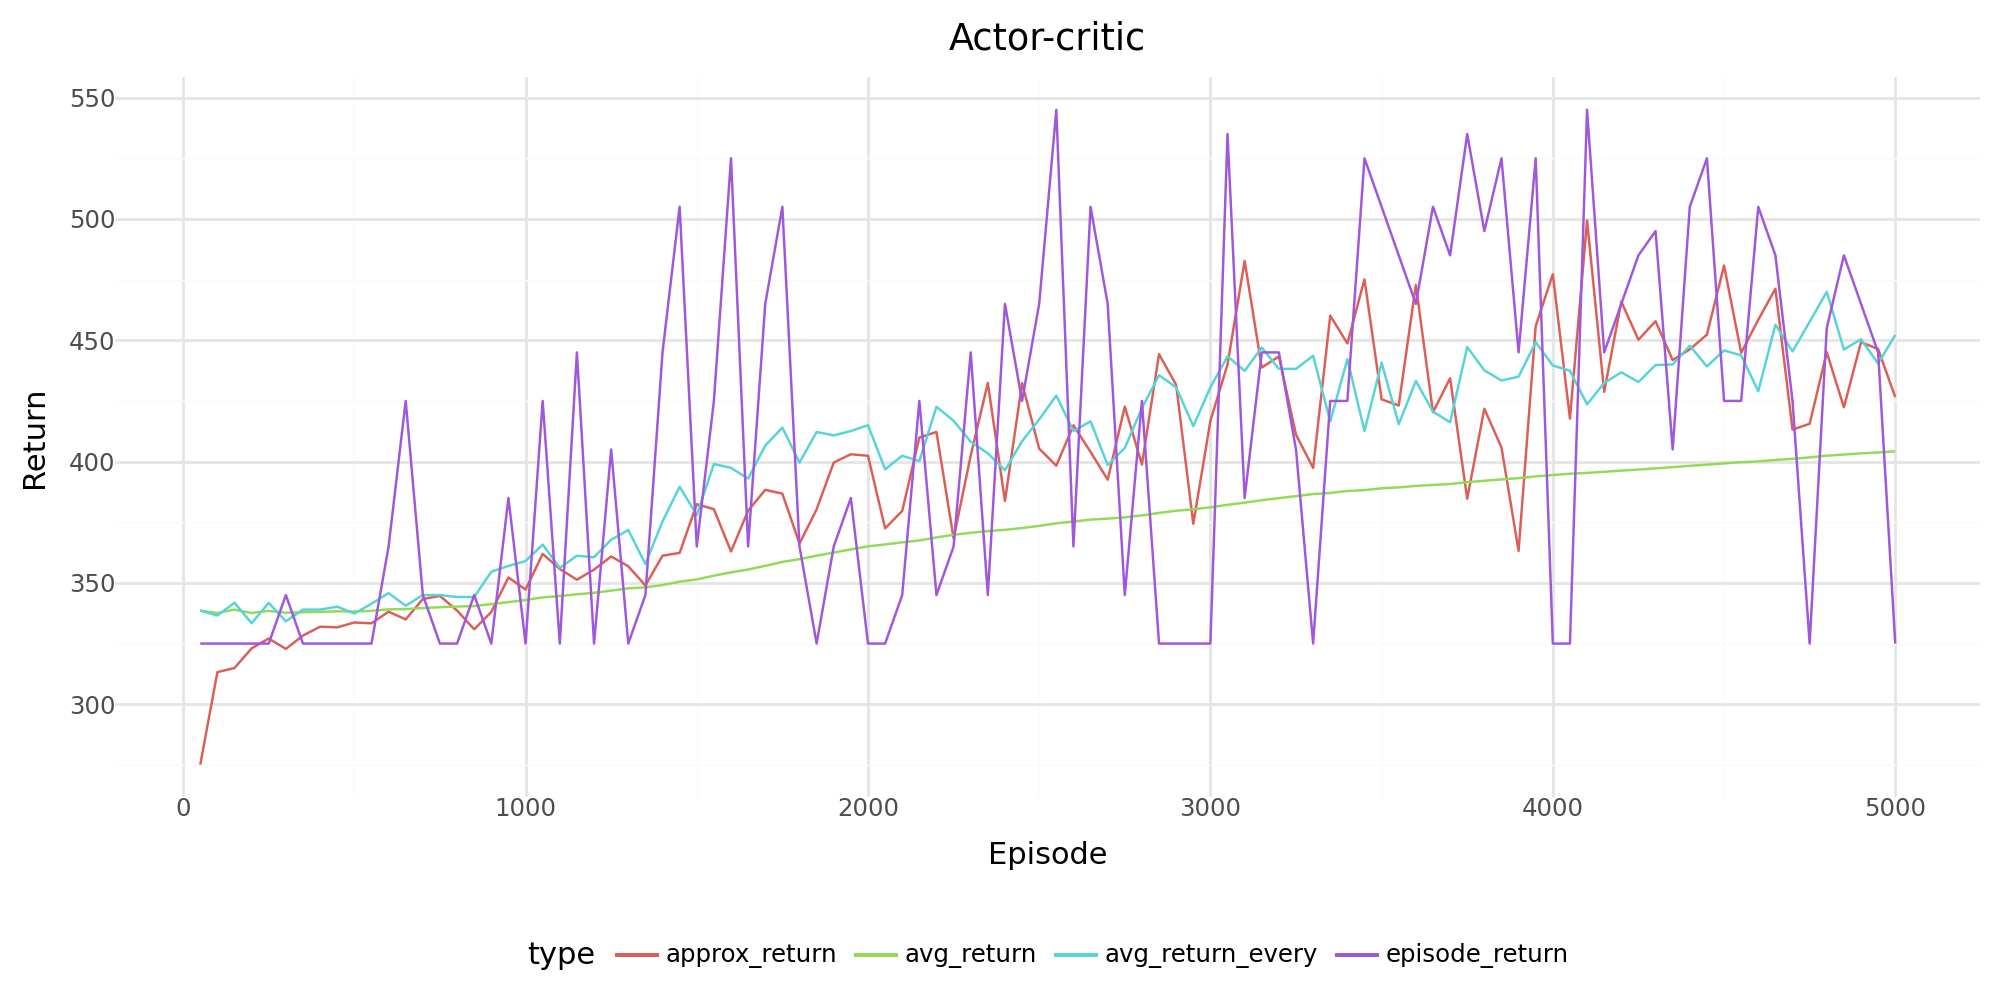

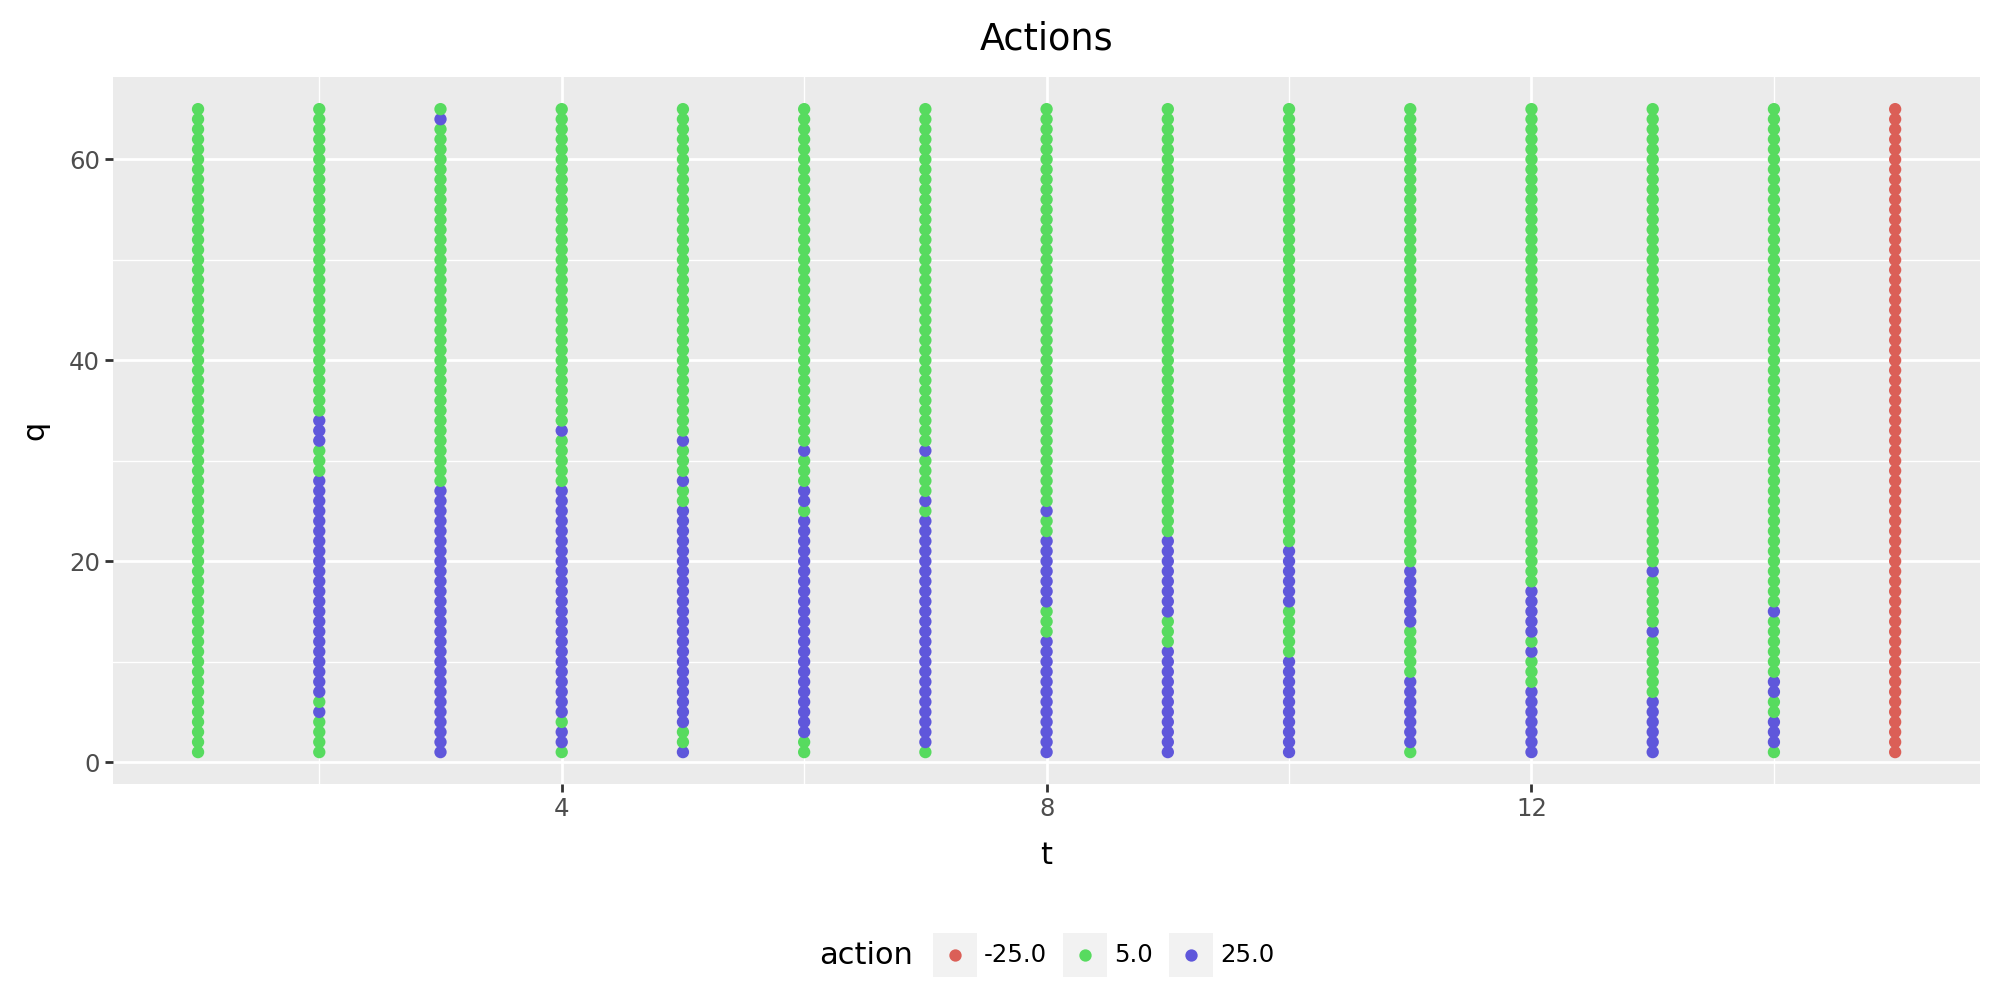

100%|██████████| 5000/5000 [00:07<00:00, 679.34it/s]


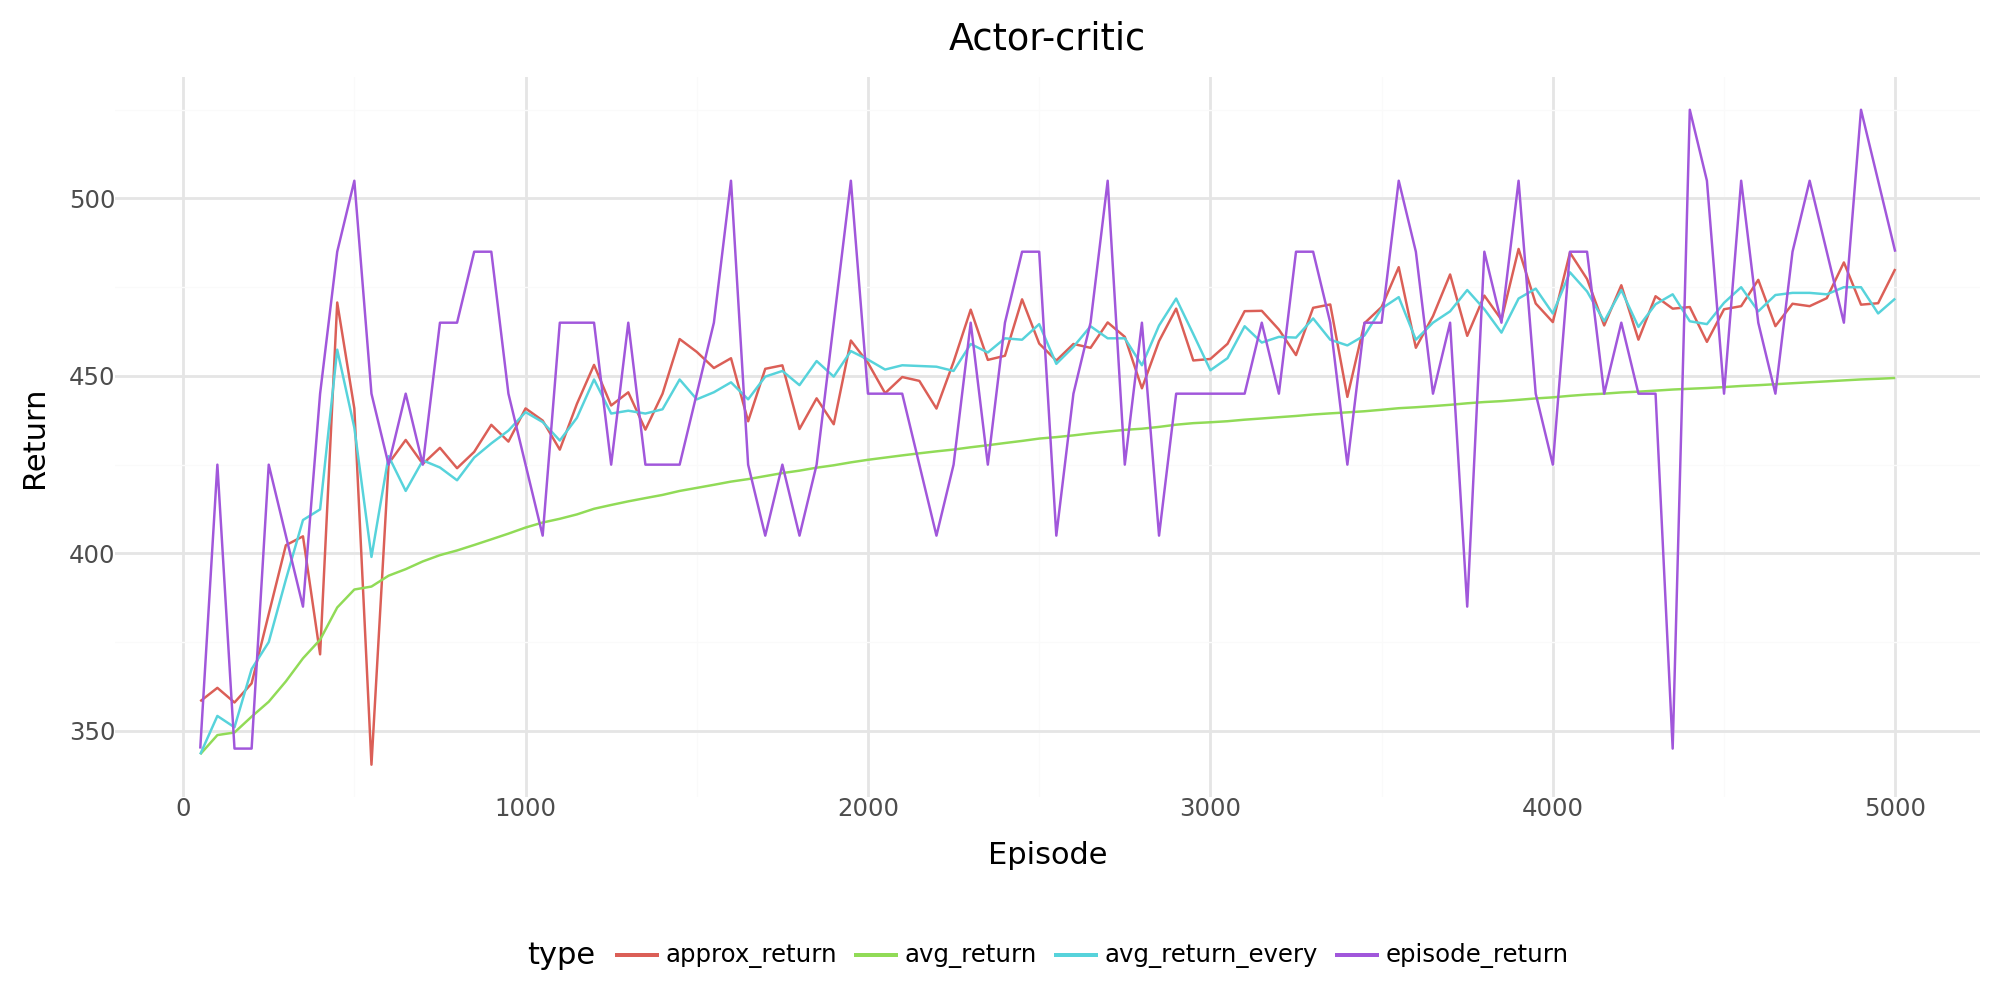

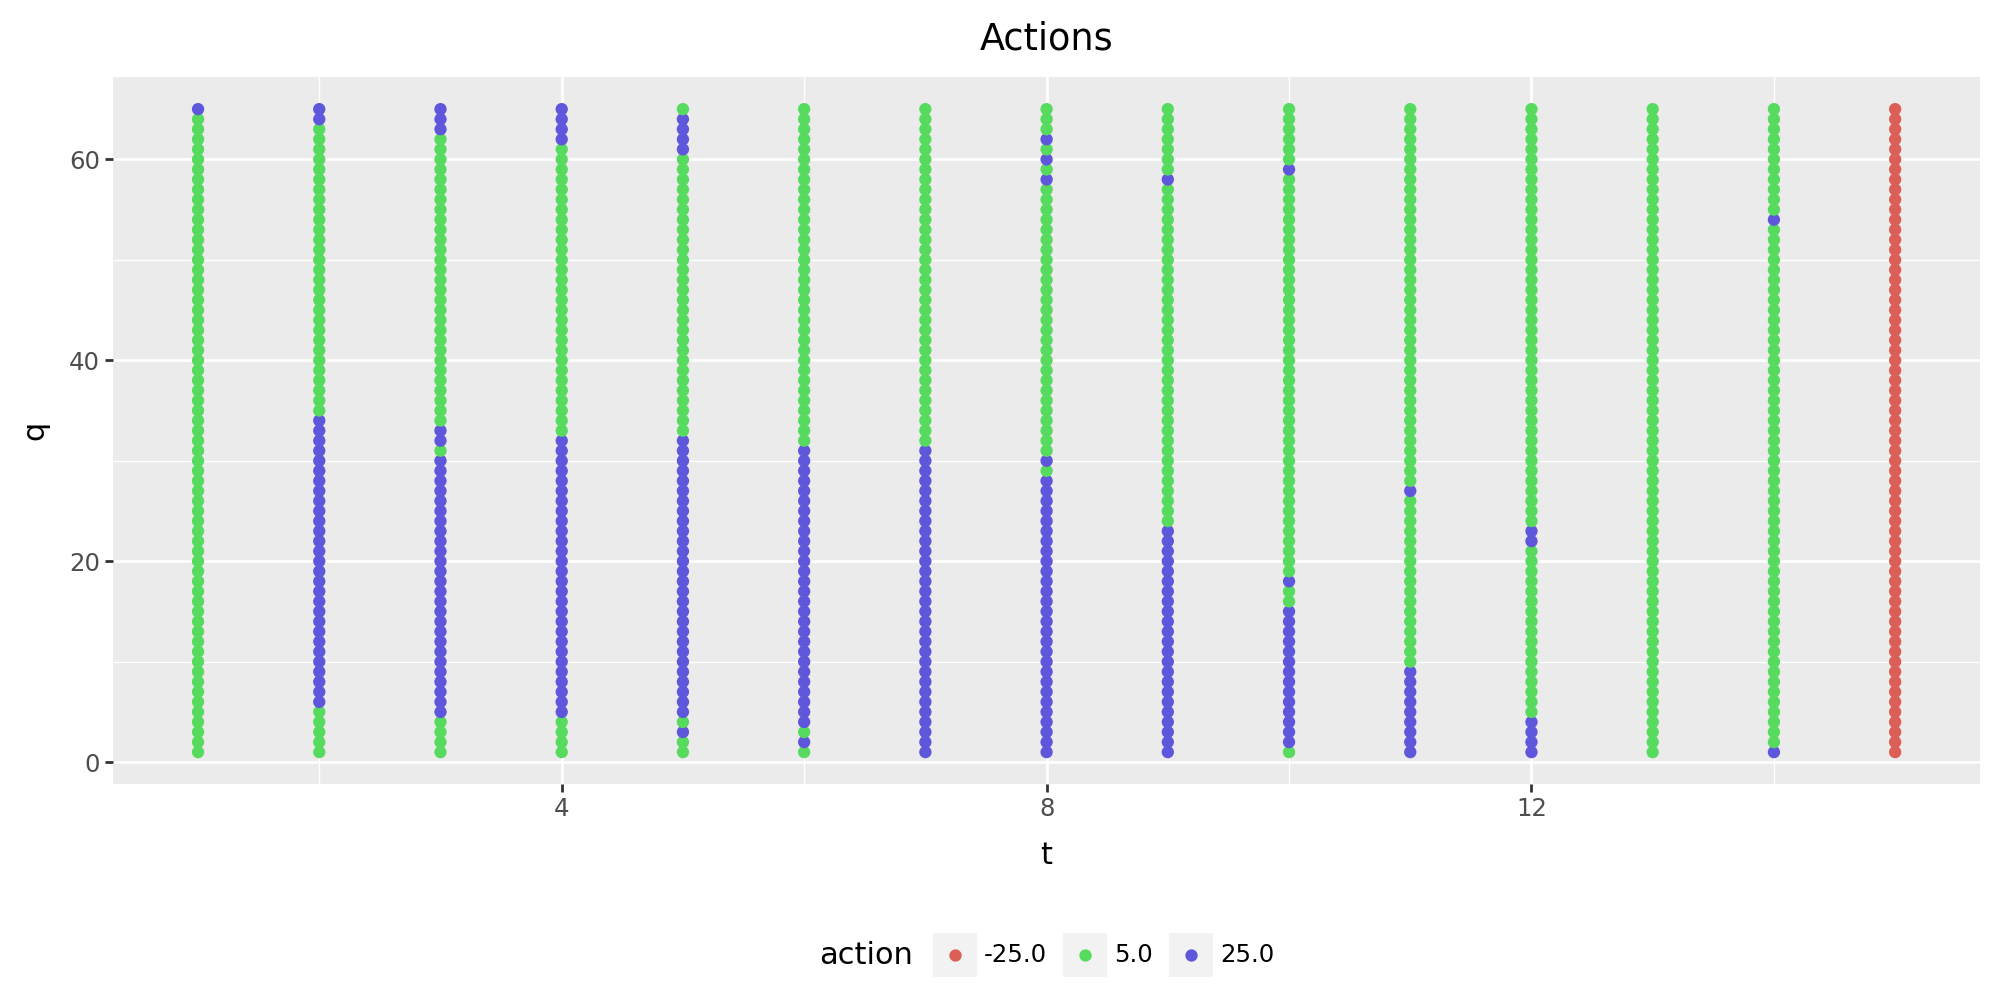

In [ ]:
#@title Testing using another environment

# Define candidate sales prices
prices = [5, 25]

# Re-instantiate environment for testing policy
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=-25.0,
    purchase_price=0,
    prices=prices,
    start_q=65,
    seed=876
)

# Create the policy
# pi_hat = SoftmaxPolicyFourier(
#     env=env,
#     step_size=1e-8,
#     decay_fct=1,
#     rng_seed=42,
#     fourier_order=9
# )

pi_hat = SoftmaxPolicyTabular(
    env=env,
    step_size=0.01,
    decay_fct=1,
    rng_seed=42
)

# pi_hat = SoftmaxPolicyPoly(
#     env=env,
#     step_size=0.01,
#     decay_fct=1,
#     rng_seed=42,
#     degree=1
# )

# pi_hat = SoftmaxPolicyPolyPositive(
#     env=env,
#     step_size=0.01,
#     decay_fct=1,
#     rng_seed=42,
#     degree=2
# )

# pi_hat = SoftmaxPolicyPolyClipPositive(
#     env=env,
#     step_size=0.01,
#     decay_fct=1,
#     rng_seed=42,
#     degree=1
# )

# pi_hat = SoftmaxPolicyPolyEntropy(
#     env=env,
#     step_size=3e-4,
#     decay_fct=1.0,
#     rng_seed=42,
#     degree=1,
#     entropy_coeff=5e-4,  # try 1e-3 or 5e-4
# )


# Create the policy
# pi_hat = SoftmaxPolicy(
#     env=env,
#     step_size=0.01,
#     decay_fct=1.0,
#     rng_seed=42,
# )

# value function
v_hat = ValueFunctionFourier(
    env=env,
    step_size=5e-3,   # often a bit larger than actor step size
    fourier_order=5
)

# Run 1
trace_ac1 = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=5000,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac1
)
plot_results(pi_hat, trace_ac1, dat_mdp, title_r = "Actor-critic", plot_hlines=False, plot_policy=True, plot_mdp=False)


# Run 2
pi_hat = SoftmaxPolicyTabular(
    env=env,
    step_size=0.01,
    decay_fct=1,
    rng_seed=42
)

v_hat = ValueFunction(
    env=env,
    step_size=0.05,   # often a bit larger than actor step size
)

trace_ac2 = []
actor_critic(
    pi_hat=pi_hat,
    v_hat=v_hat,
    episodes=5000,
    gamma=gamma,
    callback=callback,
    callback_every=50,
    trace = trace_ac2
)
plot_results(pi_hat, trace_ac2, dat_mdp, title_r = "Actor-critic", plot_hlines=False, plot_policy=True, plot_mdp=False)


### Your turn

Comment on the results.

## Policy Gradient for Continuing Problems

In the continuing setting, there are no episodes, and returns do not naturally terminate. Because of this, the performance measure used in episodic policy gradients $J(\theta) = v_{\pi}(s_0)$ no longer applies. Instead, policy gradient methods for continuing tasks optimize the *average reward*:
$$
r(\pi) = \sum_s \mu(s)\sum_a \pi(a|s)\sum_{s',r} p(s',r|s,a)\, r.
$$
Here, the distribution $\mu(s)$ is the stationary on-policy distribution over states under the current policy. This describes how often the agent visits each state in the long-run average sense.

Let us implement a actor critic algorithm:


In [31]:
#@title Actor critic (continuing tasks)

def actor_critic_continuing(
    pi_hat,
    v_hat,
    steps: int,
    alpha_r: float,
    r_bar_ini: float = 0.0,
    callback = None,
    callback_every: int = 0,
    trace: Any = None,
) -> None:
    """
    Differential (average-reward) one-step actor–critic for continuing tasks.

    This version assumes a continuing task with no terminal states, and uses
    the average-reward formulation:

        δ_t = R_{t+1} - r̄_t + v_hat(S_{t+1}) - v_hat(S_t)

    Critic (TD(0)):
        w ← w + α_v δ_t ∇_w v_hat(S_t)

    Actor:
        θ ← θ + α_θ δ_t ∇_θ log π(A_t | S_t)

    Average reward estimate:
        r̄_{t+1} = r̄_t + α_r δ_t

    Args:
        pi_hat: Policy (actor) with get_action(s) and train(s, a, mult).
        v_hat: Value function (critic) with value(s) and train(s, target).
               train(s, target) should move v_hat(s) toward `target`.
        steps: Total number of time steps to run.
        alpha_r: Step size for updating the average reward r̄.
        callback: Optional logging callback.
        callback_every: Call callback every this many steps (if > 0).
        trace: Passed through to callback.
    """

    # Initialize
    s = pi_hat.env.reset()
    r_bar = r_bar_ini

    total_reward = 0.0
    total_reward_every = 0.0

    for t in tqdm(range(1, steps + 1)):
        # Sample action from current policy
        a = pi_hat.get_action(s)

        # Environment step (continuing task: no 'done' flag)
        s_next, r = pi_hat.env.get_step(s, a)

        # Critic: TD error for differential value
        v_s = v_hat.eval(s)
        v_s_next = v_hat.eval(s_next)
        delta_t = r - r_bar + v_s_next - v_s

        # Actor: update with δ_t
        mult = delta_t
        pi_hat.train(s, a, mult)

        # Critic: semi-gradient TD(0) toward v_s + δ_t
        td_target = v_s + delta_t
        v_hat.train(s, td_target)

        # Average reward update
        r_bar += alpha_r * delta_t

        # Bookkeeping
        total_reward += r
        total_reward_every += r

        # Optional logging callback (in terms of steps, not episodes)
        if (
            callback is not None
            and callback_every > 0
            and t % callback_every == 0
        ):
            info = {
                "step": t,
                "avg_reward_estimate": r_bar,
                "avg_reward_overall": total_reward / t,
                "avg_reward_every": total_reward_every / callback_every,
            }
            total_reward_every = 0.0
            callback(pi_hat, info, trace)

        # Move to next state
        s = s_next
    print("Final average reward estimate:", round(r_bar,2))


### Your turn

Highlight differences compared to episodic version.

<i>
Key changes compared to your episodic version:

* No episodes, no discount factor.
* Introduced steps (total time steps)
* Use `alpha_r` (step size for average-reward).
* Update an average-reward estimate `r_bar`.
* Use differential TD error
</i>

Let us consider the car rental problem and define the environment:

In [18]:
#@title Car rental environment

import numpy as np
from typing import Callable, Tuple, List, Dict


class RLEnvCar:
    """
    Car rental environment (two locations) with Poisson demand/returns.

    States are tuples (x, y) with x,y ∈ {0..20}.
    """

    def __init__(self,
                 lD: List[float] = [3, 4],
                 lH: List[float] = [3, 2],
                 seed: int | None = None):
        self.lD = list(lD)
        self.lH = list(lH)
        self.rng = np.random.default_rng(seed)
        self.cars_max = 20  # max number of cars at each location
        self.states = [(x, y) for x in range(21) for y in range(21)]
        self.st2idx = {s: i for i, s in enumerate(self.states)}
        self.s_ctr = np.zeros(len(self.states), dtype=int)  # to store visits to s (use st2idx to find idx)

    def reset(self):
        """Reset the environment."""
        self.s_ctr = np.zeros(len(self.states), dtype=int)
        return (10, 10)

    # ------------------------------------------------------------------

    def get_states(self) -> List[Tuple[int, int]]:
        """Return all possible states as (x, y) tuples."""
        return self.states

    def get_actions(self, s: Tuple[int, int]) -> List[int]:
        """Return feasible integer actions for state (x, y)."""
        x, y = s
        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)
        return list(range(low, high + 1))

    def get_step(self, s: Tuple[int, int], a: int) -> Dict[str, float | Tuple[int, int]]:
        """
        Take one step in the environment.

        Args:
            s: Current state (x, y)
            a: Action, cars moved from 1→2 (negative = 2→1)

        Returns:
            tuple (next_state, reward).
        """
        x, y = s
        low = -min(5, y, 20 - x)
        high = min(5, x, 20 - y)

        if not (low <= a <= high):
            raise ValueError(f"Action {a} not feasible in state {s}")

        # Apply overnight move
        x_bar = x - a
        y_bar = y + a

        # Demand and returns
        d_x = int(self.rng.poisson(self.lD[0]))
        d_y = int(self.rng.poisson(self.lD[1]))
        h_x = int(self.rng.poisson(self.lH[0]))
        h_y = int(self.rng.poisson(self.lH[1]))

        # Rentals served
        served_x = min(d_x, x_bar)
        served_y = min(d_y, y_bar)

        # Next state (capped)
        x_next = min(20, x_bar - served_x + h_x)
        y_next = min(20, y_bar - served_y + h_y)

        reward = 10.0 * (served_x + served_y) - 2.0 * abs(a)
        state = (x_next, y_next)
        self.s_ctr[self.st2idx[state]] += 1
        return state, float(reward)

### Policy approximations

Let us implement a tabular policy approximation where we have one parameter per state–action pair. That is, $$h(s,a) = \theta_{s,a},$$ and $\theta$ is a matrix with a row for each state and a column for each action and we estimate independently for each state and action.

In [19]:
#@title Softmax tabular policy

import numpy as np
from typing import Any, Dict, Hashable, List, Tuple, Optional


class SoftmaxPolicyTabular:
    """
    Tabular softmax policy π(a|s) with one preference parameter θ_{s,a}
    per state–action pair.

        h(s, a) = θ[s, a]
        π(a|s) = exp(h(s,a)) / Σ_{a'} exp(h(s,a'))

    This class assumes:
      - env.get_states() -> iterable of states (hashable, e.g. tuples)
      - env.get_actions(s) -> list of feasible actions in state s
      - env.reset() -> initial state (not used internally, but stored)

    Methods used by actor-critic:
      - get_action(s): sample action from π(·|s)
      - train(s, a, mult): policy-gradient style update:
            θ_s ← θ_s + α * mult * ∇_θ log π(a|s)
        where ∇ wrt preferences for this state is:
            ∂ log π(a|s) / ∂ h(s,a') = 1[a'=a] - π(a'|s)
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Args:
            env: Environment with get_states() and get_actions(s).
            step_size: Actor learning rate α_θ.
            rng_seed: Optional seed for reproducible action sampling.
        """
        self.env = env
        self.alpha = float(step_size)
        self.rng = np.random.default_rng(rng_seed)

        # Enumerate all states
        states = list(env.get_states())
        self.states: List[Hashable] = states
        self.state_to_idx: Dict[Hashable, int] = {
            s: i for i, s in enumerate(states)
        }

        # For each state, store its feasible actions and a θ-vector
        self.actions_per_state: List[List[Any]] = []
        self.action_index: List[Dict[Any, int]] = []  # per-state a -> index
        self.theta: List[np.ndarray] = []             # per-state prefs

        for s in self.states:
            acts = list(env.get_actions(s))
            self.actions_per_state.append(acts)
            a_to_i = {a: i for i, a in enumerate(acts)}
            self.action_index.append(a_to_i)

            # Initialize preferences to zero (uniform policy)
            self.theta.append(np.zeros(len(acts), dtype=float))

    # ------------------------------------------------------------------

    def _softmax(self, prefs: np.ndarray) -> np.ndarray:
        """Numerically stable softmax over 1D array."""
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    def get_action_preferences(self, s: Hashable):
        """Return preferences for all actions in state s."""
        i_s = self.state_to_idx[s]
        prefs = self.theta[i_s]
        return prefs

    def get_action_probs(self, s: Hashable) -> Tuple[List[Any], np.ndarray]:
        """
        Return actions and their probabilities π(·|s).

        Args:
            s: State (must be in env.get_states()).

        Returns:
            (actions, probs) where actions is the list of feasible actions
            and probs is a numpy array of same length.
        """
        i_s = self.state_to_idx[s]
        prefs = self.theta[i_s]
        probs = self._softmax(prefs)
        return self.actions_per_state[i_s], probs

    # ------------------------------------------------------------------

    def get_action(self, s: Hashable) -> Any:
        """
        Sample an action from π(·|s).

        Args:
            s: State.

        Returns:
            Sampled action.
        """
        actions, probs = self.get_action_probs(s)
        idx = self.rng.choice(len(actions), p=probs)
        return actions[idx]

    def get_best_action(self, s: Hashable) -> Any:
        """
        Return the best action in state s.

        Args:
            s: State.

        Returns:
            Best action.
        """
        actions, probs = self.get_action_probs(s)
        return actions[np.argmax(probs)]

    # ------------------------------------------------------------------

    def train(self, s: Hashable, a: Any, mult: float) -> None:
        """
        Policy-gradient update in a single state s for taken action a.

        Performs:
            θ_s ← θ_s + α * mult * ∇_θ log π(a|s)

        For softmax in preferences, for this state's θ-vector:

            grad_k = 1[k == idx(a)] - π_k

        Args:
            s: State where action was taken.
            a: Action taken.
            mult: Scalar multiplier (often δ_t or I_t * δ_t).
        """
        i_s = self.state_to_idx[s]
        actions = self.actions_per_state[i_s]
        prefs = self.theta[i_s]

        # Compute current probabilities
        probs = self._softmax(prefs)

        # Index of the taken action within this state's action list
        try:
            j_a = self.action_index[i_s][a]
        except KeyError as e:
            raise ValueError(f"Action {a} not feasible in state {s}") from e

        # Gradient of log π(a|s) wrt preferences for this state
        grad_log = -probs.copy()
        grad_log[j_a] += 1.0

        # Update preferences for this state only
        self.theta[i_s] += self.alpha * mult * grad_log


#### Your turn

How many parameters are there in $\theta$?

*We have a parameter for each state and action, i.e. $\sum_{s=1}^{|S|} |A_s|$, where |A_s| is the number of actions possible in state $s$.*

We may also use generalization across states and smooth policy surfaces using Fourier basis for a continuous approximation:

In [20]:
 #@title Softmax Fourier basis policy

import numpy as np
from typing import Any, Dict, Hashable, List, Tuple, Optional


class SoftmaxPolicyFourier:
    """
    Softmax policy with action-specific Fourier basis features over states.

    State s = (x, y) is normalized to [0, 1] in each dimension:
        x̄ = x / cars_max,  ȳ = y / cars_max

    2D Fourier basis (order n):
        x_{k1,k2}(s) = cos(π (k1 * x̄ + k2 * ȳ)),   k1, k2 = 0..n

    Flattened feature vector x(s) has dimension (order+1)^2.

    Preferences:
        h(s, a) = θ_a^T x(s)

    Policy:
        π(a | s) = exp(h(s,a)) / Σ_{a'} exp(h(s,a'))

    Interface expected by your actor-critic:
      - get_action(s) -> sampled action
      - train(s, a, mult): policy-gradient style update using 'mult'
      - env: the environment object
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        order: int,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Args:
            env: Environment with get_states() and get_actions(s).
            step_size: Actor learning rate α_θ.
            order: Fourier basis order n (features per dim = n+1,
                   total = (n+1)^2).
            rng_seed: Optional seed for reproducible action sampling.
        """
        self.env = env
        self.alpha = float(step_size)
        self.order = int(order)
        self.rng = np.random.default_rng(rng_seed)

        # Normalization constants (assumes discrete grid 0..cars_max)
        # For your RLEnvCar: cars_max = 20.
        self.x_max = getattr(env, "cars_max", 20)
        self.y_max = getattr(env, "cars_max", 20)

        # Precompute Fourier coefficient indices k = (k1, k2)
        ks = []
        for k1 in range(self.order + 1):
            for k2 in range(self.order + 1):
                ks.append((k1, k2))
        self.k = np.array(ks, dtype=float)  # shape (num_features, 2)
        self.num_features = self.k.shape[0]

        # Global action set: all actions that appear in any state
        states = list(env.get_states())
        all_actions = {a for s in states for a in env.get_actions(s)}
        self.actions: List[Any] = sorted(all_actions)
        self.action_to_idx: Dict[Any, int] = {
            a: i for i, a in enumerate(self.actions)
        }
        self.num_actions = len(self.actions)

        # θ: preferences per action (num_actions x num_features)
        self.theta = np.zeros((self.num_actions, self.num_features), dtype=float)

    # ------------------------------------------------------------------

    def _features(self, s: Hashable) -> np.ndarray:
        """
        Compute Fourier feature vector x(s) for state s = (x, y).

        Returns:
            1D numpy array of shape (num_features,)
        """
        x, y = s
        x_bar = x / self.x_max
        y_bar = y / self.y_max

        # k is shape (num_features, 2)
        # Compute dot(k, [x̄, ȳ]) then cos(π * ·)
        proj = self.k[:, 0] * x_bar + self.k[:, 1] * y_bar
        phi = np.cos(np.pi * proj)
        return phi

    def _softmax(self, prefs: np.ndarray) -> np.ndarray:
        """Numerically stable softmax over 1D array."""
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    # ------------------------------------------------------------------

    def action_probs(self, s: Hashable) -> Tuple[List[Any], np.ndarray]:
        """
        Return feasible actions and their probabilities π(·|s).

        Args:
            s: State.

        Returns:
            (actions, probs) where:
              - actions: list of feasible actions in this state
              - probs: numpy array of probabilities of same length
        """
        phi = self._features(s)  # shape (num_features,)
        feasible_actions = list(self.env.get_actions(s))

        # Map feasible actions to their global indices
        idxs = np.array(
            [self.action_to_idx[a] for a in feasible_actions],
            dtype=int,
        )

        # Preferences for feasible actions: h(s,a) = θ_a^T x(s)
        prefs = self.theta[idxs] @ phi  # shape (len(feasible),)

        probs = self._softmax(prefs)
        return feasible_actions, probs

    # ------------------------------------------------------------------

    def get_action(self, s: Hashable) -> Any:
        """
        Sample an action from π(·|s).

        Args:
            s: State.

        Returns:
            Sampled action.
        """
        actions, probs = self.action_probs(s)
        idx = self.rng.choice(len(actions), p=probs)
        return actions[idx]

    def get_best_action(self, s: Hashable) -> Any:
        """
        Return the best action in state s.

        Args:
            s: State.

        Returns:
            Best action.
        """
        actions, probs = self.action_probs(s)
        return actions[np.argmax(probs)]

    # ------------------------------------------------------------------

    def train(self, s: Hashable, a: Any, mult: float) -> None:
        """
        Policy-gradient update in state s for taken action a.

        Performs:
            θ ← θ + α * mult * ∇_θ log π(a|s)

        For softmax in preferences with h(s,a) = θ_a^T x(s):

          For each feasible action a_j in this state:
              ∂ log π(a|s) / ∂ θ_{a_j}
                  = ( 1[a_j == a] - π(a_j|s) ) * x(s)

        Args:
            s: State where action was taken.
            a: Action taken.
            mult: Scalar multiplier (e.g. δ_t or I_t * δ_t).
        """
        phi = self._features(s)  # shape (num_features,)
        feasible_actions = list(self.env.get_actions(s))

        idxs = np.array(
            [self.action_to_idx[a_j] for a_j in feasible_actions],
            dtype=int,
        )

        prefs = self.theta[idxs] @ phi
        probs = self._softmax(prefs)

        # One-hot for the taken action within the feasible set
        try:
            j_taken = feasible_actions.index(a)
        except ValueError as e:
            raise ValueError(f"Action {a} not feasible in state {s}") from e

        one_hot = np.zeros_like(probs)
        one_hot[j_taken] = 1.0

        # Gradient factor per feasible action: (1[a_j==a] - π_j)
        grad_factor = one_hot - probs  # shape (len(feasible),)

        # Update θ for feasible actions only
        # Each θ[idxs[j]] += α * mult * grad_factor[j] * x
        self.theta[idxs] += self.alpha * mult * grad_factor[:, None] * phi[None, :]

#### Your turn

Given an order of $n$, how many features are there for each state?

*For each state, we let the frequency vector (see Module 12.7.3) be $c=(k_1, k_2)$ with $k_i = 0,\ldots,n$. That is, we have $(n+1)^2$ features.*


Finally, we may also enforce a monotone policy that guarantees that

1) For fixed x, as y increases, the distribution moves towards
smaller actions (so the chosen action tends to decrease).
2) For fixed y, as x increases, distribution moves towards larger
actions (so the chosen action tends to increase).

In [21]:
#@title Softmax monotone policy

import numpy as np
from typing import Any, Dict, Hashable, List, Optional, Tuple


class SoftmaxPolicyMonotoneXY:
    """
    Softmax policy with *monotone* action structure over 2D state (x, y).

    State s = (x, y), with integer x,y (e.g. 0..20).

    We define a scalar "pressure" function:

        g(x, y) = b + exp(u1) * x - exp(u2) * y

    so that:
      - ∂g/∂x = exp(u1) >= 0  ⇒ g increases with x
      - ∂g/∂y = -exp(u2) <= 0 ⇒ g decreases with y

    Preferences (for numeric actions a):

        h(s, a) = a * g(x, y)

    Policy over feasible actions in state s:

        π(a | s) = exp(h(s,a)) / Σ_{a' feasible} exp(h(s,a'))

    As g(x,y) increases (higher x or lower y), probability mass shifts
    to larger actions a. As g(x,y) decreases (lower x or higher y),
    probability shifts to smaller actions a.

    This guarantees:
      1) For fixed x, as y increases, the distribution moves towards
         smaller actions (so the chosen action tends to decrease).
      2) For fixed y, as x increases, distribution moves towards larger
         actions (so the chosen action tends to increase).

    (Subject to feasibility constraints in env.get_actions(s).)
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        rng_seed: Optional[int] = None,
    ) -> None:
        """
        Args:
            env: Environment with get_states() and get_actions(s).
                 Actions must be numeric and ordered (like -5..+5).
            step_size: Learning rate α_θ for policy updates.
            rng_seed: Optional seed for action sampling.
        """
        self.env = env
        self.alpha = float(step_size)
        self.rng = np.random.default_rng(rng_seed)

        # Parameters of g(x,y): b, u1, u2 (unconstrained).
        # We use exp(u1), exp(u2) to enforce correct signs.
        self.b = 0.0
        self.u1 = 0.0
        self.u2 = 0.0

    # ------------------------------------------------------------------

    def _g(self, s: Hashable) -> float:
        """Compute g(x,y) for state s = (x, y)."""
        x, y = s
        w1 = np.exp(self.u1)   # >= 0
        w2 = np.exp(self.u2)   # >= 0
        return self.b + w1 * x - w2 * y

    def _softmax(self, prefs: np.ndarray) -> np.ndarray:
        """Numerically stable softmax over 1D array."""
        c = np.max(prefs)
        exp_p = np.exp(prefs - c)
        return exp_p / np.sum(exp_p)

    # ------------------------------------------------------------------

    def action_probs(self, s: Hashable) -> Tuple[List[Any], np.ndarray]:
        """
        Return feasible actions and their probabilities π(·|s).

        Args:
            s: State (x, y).

        Returns:
            (actions, probs)
        """
        g_val = self._g(s)

        # Feasible actions in this state (e.g. -5..+5, truncated)
        actions = list(self.env.get_actions(s))
        actions = sorted(actions)  # ensure numeric order

        # Preferences: h(s,a) = a * g(x,y)
        prefs = np.array([a * g_val for a in actions], dtype=float)

        probs = self._softmax(prefs)
        return actions, probs

    # ------------------------------------------------------------------

    def get_action(self, s: Hashable) -> Any:
        """
        Sample an action from π(·|s).

        Args:
            s: State (x,y).

        Returns:
            Sampled action.
        """
        actions, probs = self.action_probs(s)
        idx = self.rng.choice(len(actions), p=probs)
        return actions[idx]

    def get_best_action(self, s: Hashable) -> Any:
        """
        Return the best action in state s.
        """
        actions, probs = self.action_probs(s)
        return actions[np.argmax(probs)]

    # ------------------------------------------------------------------

    def train(self, s: Hashable, a: Any, mult: float) -> None:
        """
        Policy-gradient update with monotonicity preserved.

        Performs:
            θ ← θ + α * mult * ∇_θ log π(a|s)

        Here θ = (b, u1, u2), and

            h(s,a) = a * g(x,y)
            g(x,y) = b + e^{u1} x - e^{u2} y

        For softmax with h(s,a) = a g(s),

            ∂ log π(a|s) / ∂g = a - E_π[A | s]

        and

            ∂g / ∂b  = 1
            ∂g / ∂u1 = e^{u1} * x
            ∂g / ∂u2 = -e^{u2} * y

        So:

            ∇_θ log π(a|s) = (a - E[A|s]) * (∂g/∂b, ∂g/∂u1, ∂g/∂u2)

        The 'mult' is usually δ_t (or I_t * δ_t in episodic versions).
        """
        x, y = s
        g_val = self._g(s)

        # Feasible actions & probabilities
        actions = list(self.env.get_actions(s))
        actions = sorted(actions)
        prefs = np.array([a_j * g_val for a_j in actions], dtype=float)
        probs = self._softmax(prefs)

        # Expected action under current policy: E_π[A | s]
        actions_arr = np.array(actions, dtype=float)
        A_bar = float(np.dot(probs, actions_arr))

        # Check that chosen action is feasible
        if a not in actions:
            raise ValueError(f"Action {a} not feasible in state {s}")

        # Factor (a - E[A|s]) from ∂ log π / ∂g
        factor = float(a - A_bar)

        # Gradients of g
        w1 = np.exp(self.u1)
        w2 = np.exp(self.u2)
        dg_db = 1.0
        dg_du1 = w1 * x
        dg_du2 = -w2 * y

        # Full gradient of log π wrt (b, u1, u2)
        grad_b = factor * dg_db
        grad_u1 = factor * dg_du1
        grad_u2 = factor * dg_du2

        # Update
        self.b  += self.alpha * mult * grad_b
        self.u1 += self.alpha * mult * grad_u1
        self.u2 += self.alpha * mult * grad_u2


#### Your turn

1. How is the preference function defined?

    *The preference function is $h(s, a) = a \cdot g(x, y) = a(u_0 + \exp(u_1) x - \exp(u_2) y)$.*

2. Are we using linear features and how many parameters do we have for each action?

    *Since
    \begin{align}
    h(s,a)
    &= a(u_0 + \exp(u_1) x - \exp(u_2) y) \\
    &= a \left(\theta_0 + \theta_1 x + \theta_2 y\right) \\
    &= \theta_{a,0} \cdot 1
    + \theta_{a,1} \cdot x
    + \theta_{a,2} \cdot y.
    \end{align}
    That is, have 3 parameters ($\theta_a$) for each action and linear features
    $$
    x(s) = [1,\; x,\; y ]
    $$*

3. Why do we enforce that
   - For fixed x, as y increases, the distribution moves towards smaller actions (so the chosen action tends to decrease).
   - For fixed y, as x increases, distribution moves towards larger actions (so the chosen action tends to increase).

    *Note the parameters $(u_1,u_2)$ appear inside exponentials. That is,
    $$
    \theta_1 = e^{u_1}, \qquad \theta_2 = -e^{u_2},
    $$
    Hence $\theta_1 \ge 0$, i.e. increasing in $x$ and $\theta_2 \le 0$, i.e. decreasing in $y$.
    As g(x,y) increases (higher x or lower y), probability mass shifts to larger actions a. As g(x,y) decreases (lower x or higher y), probability shifts to smaller actions a.*

### Value function approximations

Let us try to use tile coding. That is, we need a tile coder class:

In [22]:
#@title TileCoder class (use as is)

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_rect, geom_text, geom_vline,
    scale_y_reverse, labs, theme_bw, theme
)
import hashlib
from typing import Iterable, Sequence, Tuple, Union


# =============================================================
# A practical TileCoder for RL (1D and ND)
# - Deterministic, evenly spaced offsets by default
# - Optional randomness via seed
# - Returns sparse active indices; optional dense/hashed encoding
# - Supports wrapping (per-dimension or global)
# - Exposes 1D attributes so existing plotting utilities work
# =============================================================
class TileCoder:
    """
    A practical TileCoder for RL (1D and ND).

    - Deterministic, evenly spaced offsets by default
    - Optional randomness via seed
    - Returns sparse active indices
    - Supports wrapping (per-dimension or global)
    - Exposes 1D attributes so existing plotting utilities work
    """

    def __init__(
        self,
        n_tilings: int,
        tiles_per_dim: Union[int, Sequence[int]],
        ranges: Union[None, Sequence[Tuple[float, float]]] = None,
        wrap: Union[bool, Sequence[bool]] = False,
        seed: Union[None, int] = None,
        deterministic: bool = True,
        hash_size: Union[None, int] = None,
    ):
        """
        A practical TileCoder for RL (1D and ND).

        Args:
            n_tilings (int): Number of tilings.
            tiles_per_dim (Union[int, Sequence[int]]): Tiles per dimension.
            ranges (Union[None, Sequence[Tuple[float, float]]], optional): Ranges for normalization to [0,1]. Defaults to None
            wrap (Union[bool, Sequence[bool]], optional): Wrap flags per dimension. Defaults to False
            seed (Union[None, int], optional): Random seed. Defaults to None
            deterministic (bool, optional): Use deterministic offsets. Defaults to True
            hash_size (Union[None, int], optional): Hash size for sparse encoding. Defaults to None
        """
        assert n_tilings >= 1
        self.n_tilings = int(n_tilings)

        if isinstance(tiles_per_dim, Iterable) and not isinstance(tiles_per_dim, (str, bytes)):
            self.tiles_per_dim = np.array(list(tiles_per_dim), dtype=int)
        else:
            self.tiles_per_dim = np.array([int(tiles_per_dim)], dtype=int)
        assert np.all(self.tiles_per_dim >= 2)

        self.d = int(self.tiles_per_dim.size)

        # Ranges for normalization to [0,1]
        if ranges is None:
            self.ranges = np.array([(0.0, 1.0)] * self.d, dtype=float)
        else:
            assert len(ranges) == self.d
            self.ranges = np.array(ranges, dtype=float)
            assert np.all(self.ranges[:, 1] > self.ranges[:, 0])

        # Wrap flags per dimension
        if isinstance(wrap, Iterable) and not isinstance(wrap, (str, bytes)):
            wrap = list(wrap)
            assert len(wrap) == self.d
            self.wrap = np.array(wrap, dtype=bool)
        else:
            self.wrap = np.array([bool(wrap)] * self.d, dtype=bool)

        self.hash_size = None if hash_size is None else int(hash_size)
        self.deterministic = bool(deterministic)
        self.seed = seed

        # Precompute strides for mixed-radix indexing
        self.tiles_strides = np.ones(self.d, dtype=int)
        for i in range(self.d - 2, -1, -1):
            self.tiles_strides[i] = self.tiles_strides[i + 1] * self.tiles_per_dim[i + 1]
        self.tiles_per_tiling = int(np.prod(self.tiles_per_dim))  # for 1D this equals tiles_per_dim

        # Offsets per tiling and dimension, as fractions of the unit interval
        self.offsets = self._make_offsets()

        # Expose attributes used by the existing 1D plotting helpers
        if self.d == 1:
            self.tiles_per_tiling_1d = int(self.tiles_per_dim[0])
            self.offsets_1d = self.offsets[:, 0]
            # Back-compat attribute names expected by the plotting code
            self.tiles_per_tiling = self.tiles_per_tiling_1d
            # plot helpers look for 'offsets' as 1D array; keep original 2D in _offsets2d
            self._offsets2d = self.offsets
            self.offsets = self.offsets_1d

    @property
    def n_features(self) -> int:
        if self.hash_size is not None:
            return self.hash_size
        return int(self.n_tilings * np.prod(self.tiles_per_dim))

    # ------------------------
    # Offset generation
    # ------------------------
    def _make_offsets(self) -> np.ndarray:
        """Create an (n_tilings, d) array of offsets in [0, 1/tiles_i)."""
        widths = 1.0 / self.tiles_per_dim.astype(float)
        if self.deterministic:
            # Evenly spaced along each dimension by fraction t/n_tilings of a bin width
            t = np.arange(self.n_tilings, dtype=float).reshape(-1, 1)
            base = (t / self.n_tilings)  # shape (n_tilings, 1)
            return (base * widths)  # broadcast to (n_tilings, d)
        else:
            rng = np.random.default_rng(self.seed)
            return rng.uniform(0.0, widths, size=(self.n_tilings, self.d))

    # ------------------------
    # Public API
    # ------------------------
    def active_indices(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Return the global feature indices (length n_tilings) for input x.
        x can be a scalar (1D) or a sequence of length d.
        """
        u = self._normalize_to_unit(x)  # in [0,1]^d
        inds = np.empty(self.n_tilings, dtype=np.int64)
        for t in range(self.n_tilings):
            idxs = self._tile_indices_for_tiling(u, t)
            if self.hash_size is None:
                inds[t] = t * self.tiles_per_tiling + self._linearize_indices(idxs)
            else:
                inds[t] = self._hash_index(t, idxs)
        return inds

    def encode_sparse(self, x: Union[float, Sequence[float]]):
        """Return (indices, values) for sparse features with value 1.0 for each tiling."""
        inds = self.active_indices(x)
        vals = np.ones_like(inds, dtype=float)
        return inds, vals

    def encode_dense(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        """Dense binary feature vector (mostly for debugging)."""
        size = self.n_features
        vec = np.zeros(size, dtype=float)
        inds = self.active_indices(x)
        vec[inds] = 1.0
        return vec

    # ------------------------
    # Internals
    # ------------------------
    def _normalize_to_unit(self, x: Union[float, Sequence[float]]) -> np.ndarray:
        x = np.array([x], dtype=float) if np.isscalar(x) else np.array(x, dtype=float)
        assert x.size == self.d, f"Expected input of dimension {self.d}, got {x.size}"
        lo = self.ranges[:, 0]
        hi = self.ranges[:, 1]
        u = (x - lo) / (hi - lo)
        # Clamp to [0,1] to avoid numerical overflow in min/floor
        return np.clip(u, 0.0, 1.0)

    def _tile_indices_for_tiling(self, u: np.ndarray, t: int) -> np.ndarray:
        offs = self.offsets[t]
        v = u + offs
        idxs = np.empty(self.d, dtype=int)
        for i in range(self.d):
            if self.wrap[i]:
                w = v[i] % 1.0
            else:
                w = min(v[i], 1.0 - 1e-12)
            idxs[i] = int(np.floor(w * self.tiles_per_dim[i]))
        return idxs

    def _linearize_indices(self, idxs: np.ndarray) -> int:
        return int(np.dot(idxs, self.tiles_strides))

    def _hash_index(self, t: int, idxs: np.ndarray) -> int:
        # Deterministic hash of (t, idxs...)
        payload = np.array([t, *idxs.tolist()], dtype=np.int64).tobytes()
        h = hashlib.sha256(payload).digest()
        return int.from_bytes(h[:8], 'little') % int(self.hash_size)

    # ------------------------
    # 1D plotting helpers as methods (plotnine)
    # ------------------------
    def _assert_1d(self):
        assert self.d == 1, "plot_1d is only available for 1D tile coders"

    def _wrap_flag_1d(self) -> bool:
        return bool(self.wrap[0])

    def _bin_bounds_for_tiling_1d(self, offset: float) -> list:
        """Compute (start,end) intervals for bins in one tiling.
        Honors wrap setting; non-wrap lets the last tile extend to 1.0.
        """
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        width = 1.0 / T
        if wrap:
            starts = (np.arange(T) * width - offset) % 1.0
            ends = (starts + width) % 1.0
            return list(zip(starts, ends))
        else:
            out = []
            for b in range(T):
                if b < T - 1:
                    s = b * width - offset
                    e = (b + 1) * width - offset
                else:
                    s = (T - 1) * width - offset
                    e = 1.0
                s = max(0.0, s)
                e = min(1.0, e)
                out.append((s, e))
            return out

    def _active_tile_for_tiling_1d(self, z: float, offset: float) -> int:
        wrap = self._wrap_flag_1d()
        T = int(self.tiles_per_tiling)
        val = (z + offset) % 1.0 if wrap else min(z + offset, 1.0 - 1e-12)
        return int(np.floor(val * T))

    def build_tile_df_1d(self, z: float = 0.37) -> pd.DataFrame:
        self._assert_1d()
        wrap = self._wrap_flag_1d()
        recs = []
        for t in range(self.n_tilings):
            bins = self._bin_bounds_for_tiling_1d(self.offsets[t])
            active_tile = self._active_tile_for_tiling_1d(z, self.offsets[t])
            for b, (s, e) in enumerate(bins):
                is_active = (b == active_tile)
                if wrap and s > e:
                    recs.append(dict(
                        tiling=t, tile=b, xmin=0.0, xmax=e, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(0.0 + e) / 2.0, ycenter=t, active=is_active
                    ))
                    recs.append(dict(
                        tiling=t, tile=b, xmin=s, xmax=1.0, ymin=t-0.45, ymax=t+0.45,
                        xcenter=(s + 1.0) / 2.0, ycenter=t, active=is_active
                    ))
                    continue
                if e <= s:
                    continue
                recs.append(dict(
                    tiling=t, tile=b, xmin=s, xmax=e, ymin=t-0.45, ymax=t+0.45,
                    xcenter=(s + e) / 2.0, ycenter=t, active=is_active
                ))
        return pd.DataFrame(recs)

    def plot_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Return a plotnine ggplot object visualizing 1D tiles and active bin per tiling."""
        self._assert_1d()
        df = self.build_tile_df_1d(z)
        ttl = title if title else f"TileCoder (wrap={'True' if self._wrap_flag_1d() else 'False'})"
        p = (
            ggplot(df, aes(xmin='xmin', xmax='xmax', ymin='ymin', ymax='ymax', fill='active'))
            + geom_rect(alpha=0.35, color='black', size=0.2)
            + geom_text(aes(x='xcenter', y='ycenter', label='tile'), size=6)
            + geom_vline(xintercept=z, linetype='dashed')
            + scale_y_reverse()
            + labs(title=f"{ttl} — z={z:.2f}", x='z in [0,1]', y='Tiling index')
            + theme_bw()
            + theme(figure_size=(10, 2))
        )
        return p

    def show_1d(self, z: float = 0.37, title: Union[None, str] = None):
        """Convenience: build and immediately render the 1D plot (if in an environment that supports .show())."""
        return self.plot_1d(z, title).show()



Let us define a tile coder value function approximation class:

In [23]:
#@title Tile coding value function

import numpy as np
from typing import Any, Optional

# -------------------------------------------------------------
# You must ensure the TileCoder class (your long definition above)
# is available in your environment.
# -------------------------------------------------------------


class ValueFunctionTileCoding:
    """
    Linear value function approximator with internally constructed TileCoder.

        v(s) = w^T x(s)

    x(s) is sparse tile-coded features created by a TileCoder built
    *inside* this class.
    """

    def __init__(
        self,
        env: Any,
        step_size: float,
        n_tilings: int,
        tiles_per_dim,
        init_val: float = 0.0,
        deterministic: bool = True,
        seed: Optional[int] = None,
    ):
        """
        Args:
            env: The environment.
            step_size: Learning rate α_v (divided internally by n_tilings).
            n_tilings: Number of tilings for tile coding.
            tiles_per_dim: Int or list of ints for each dimension.
            ranges: List of (min, max) for each dimension.
            wrap: Whether to wrap each dimension.
            init_val: Initial approximate V(s).
            deterministic: Deterministic or random offsets.
            seed: Optional seed.
            hash_size: Optional hashing size for tile coding.
        """
        self.env = env

        # --- Construct TileCoder internally ---
        self.tc = TileCoder(
            n_tilings=n_tilings,
            tiles_per_dim=tiles_per_dim,
            ranges=[(0, env.cars_max), (0, env.cars_max)],
            wrap=False,
            seed=seed,
            deterministic=deterministic
        )

        # --- learning rate ---
        # Good practice: divide by number of tilings so V-learning is stable
        self.alpha = float(step_size) / n_tilings

        # --- parameters ---
        self.n_features = self.tc.n_features

        # Initialize weights so v(s) ≈ init_val
        w0 = init_val / n_tilings
        self.w = np.full(self.n_features, w0, dtype=float)

    # ------------------------------------------------------------------

    def _features(self, s):
        """Sparse tile-coded features (idxs, vals)."""
        return self.tc.encode_sparse(np.asarray(s, dtype=float))

    # ------------------------------------------------------------------

    def eval(self, s) -> float:
        """Return v(s)."""
        idxs, vals = self._features(s)
        return float(np.dot(self.w[idxs], vals))

    # ------------------------------------------------------------------

    def train(self, s, target: float) -> None:
        """
        Semi-gradient TD update toward target:

            δ = target - v(s)
            w <- w + α * δ * x(s)
        """
        idxs, vals = self._features(s)
        v_s = np.dot(self.w[idxs], vals)
        delta = target - v_s
        self.w[idxs] += self.alpha * delta * vals


### Run policy gradient

We are now ready to run the policy gradient algorithm.

100%|██████████| 200000/200000 [01:43<00:00, 1934.87it/s]


Final average reward estimate: 47.6


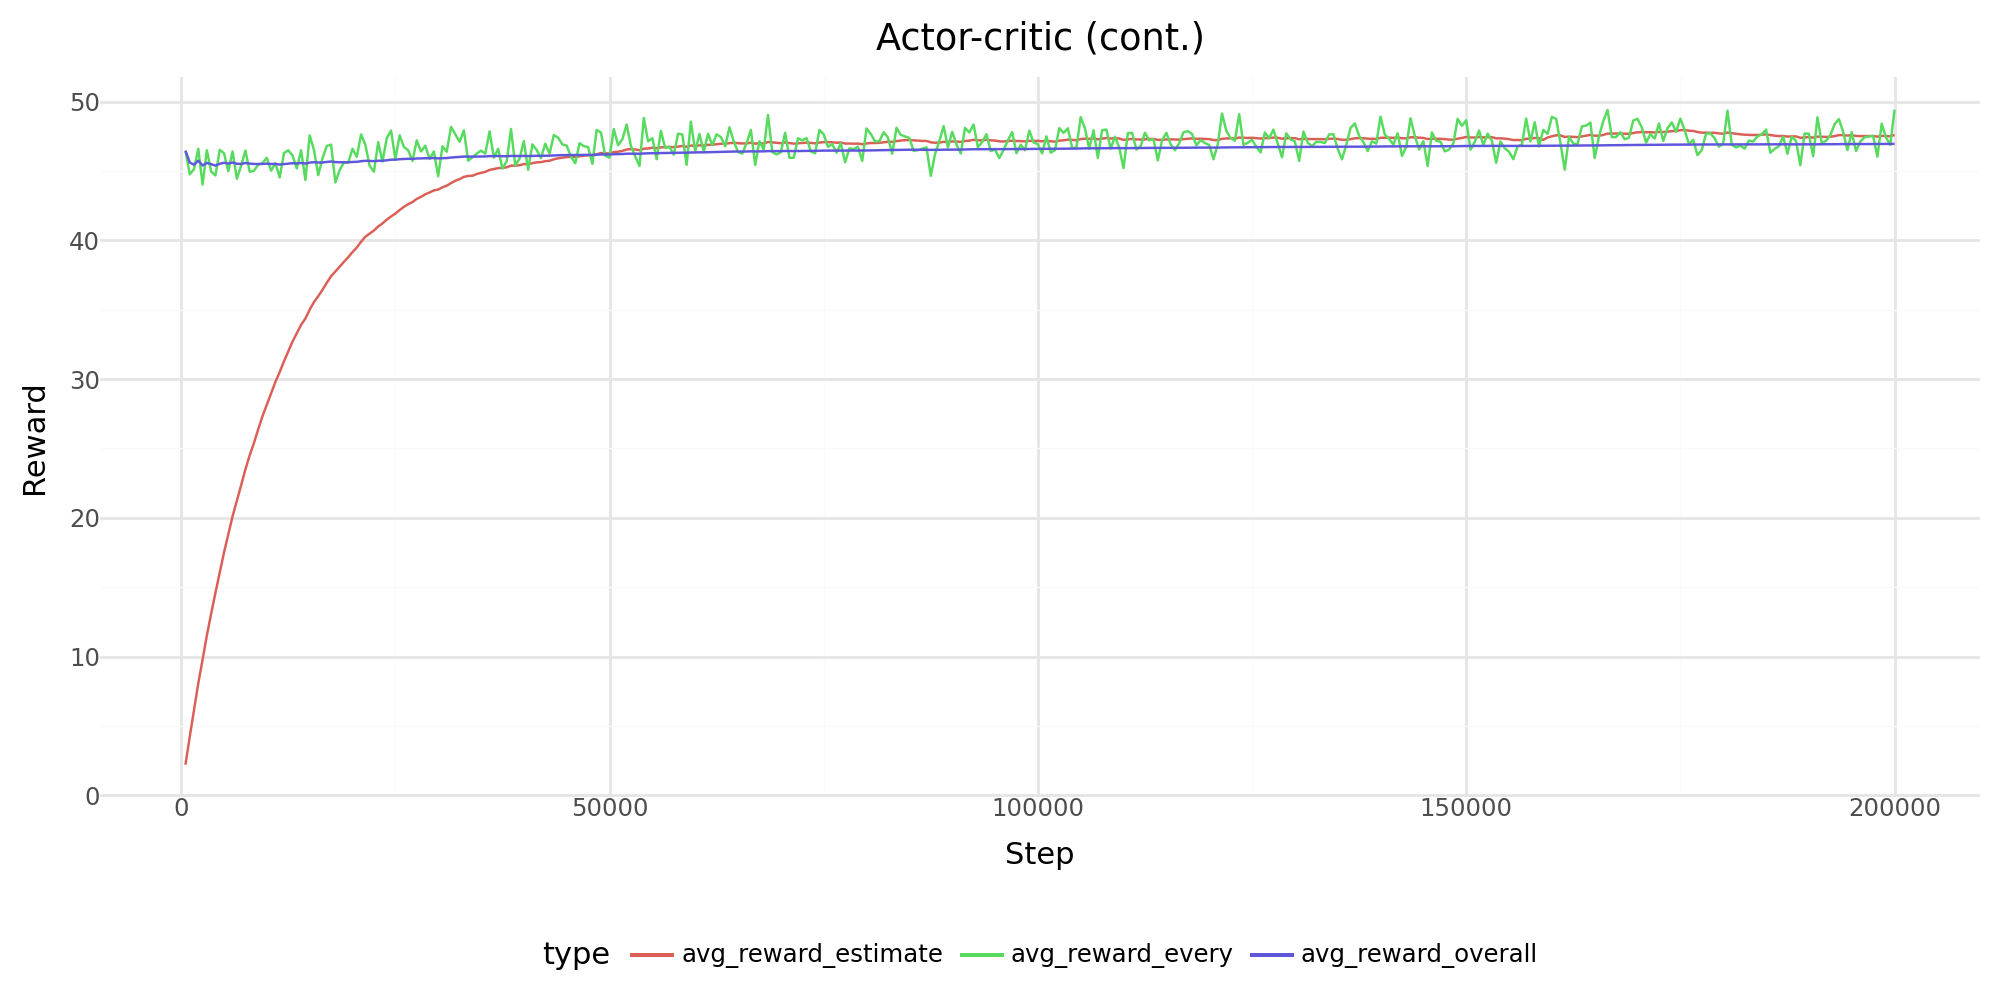

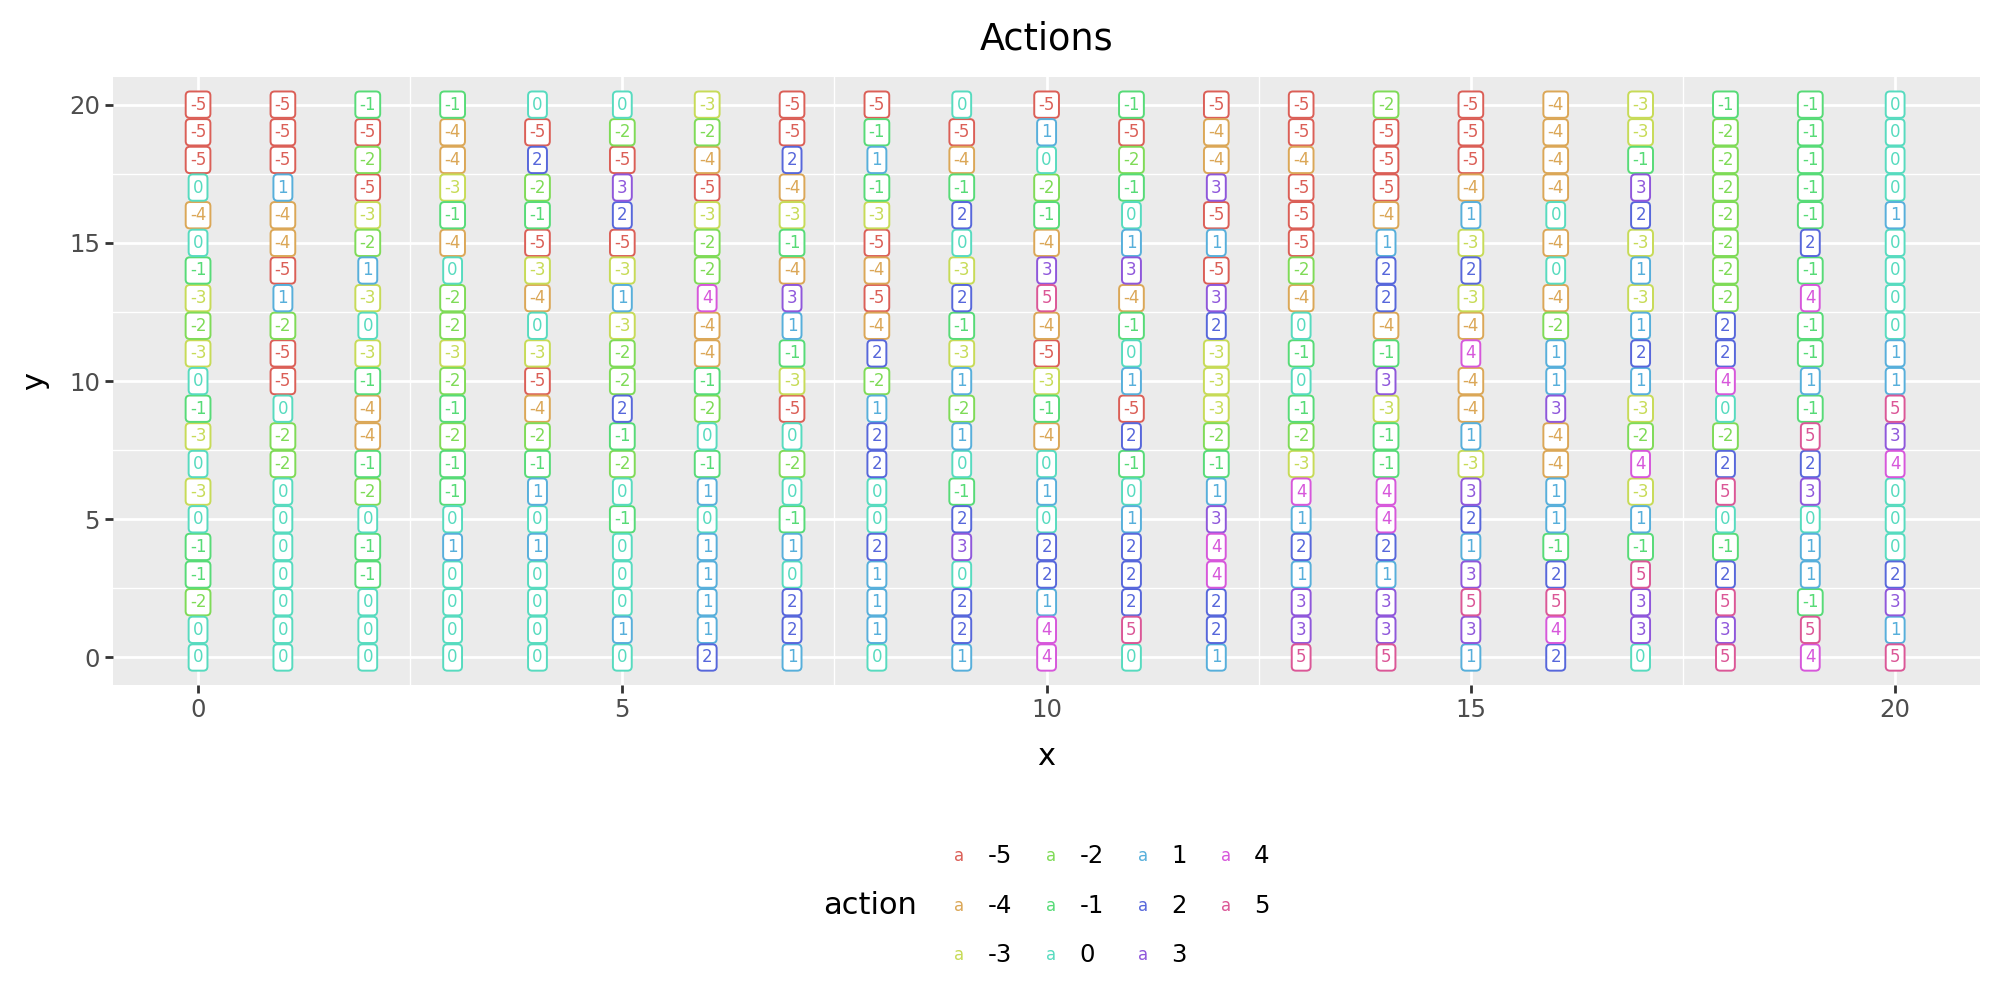

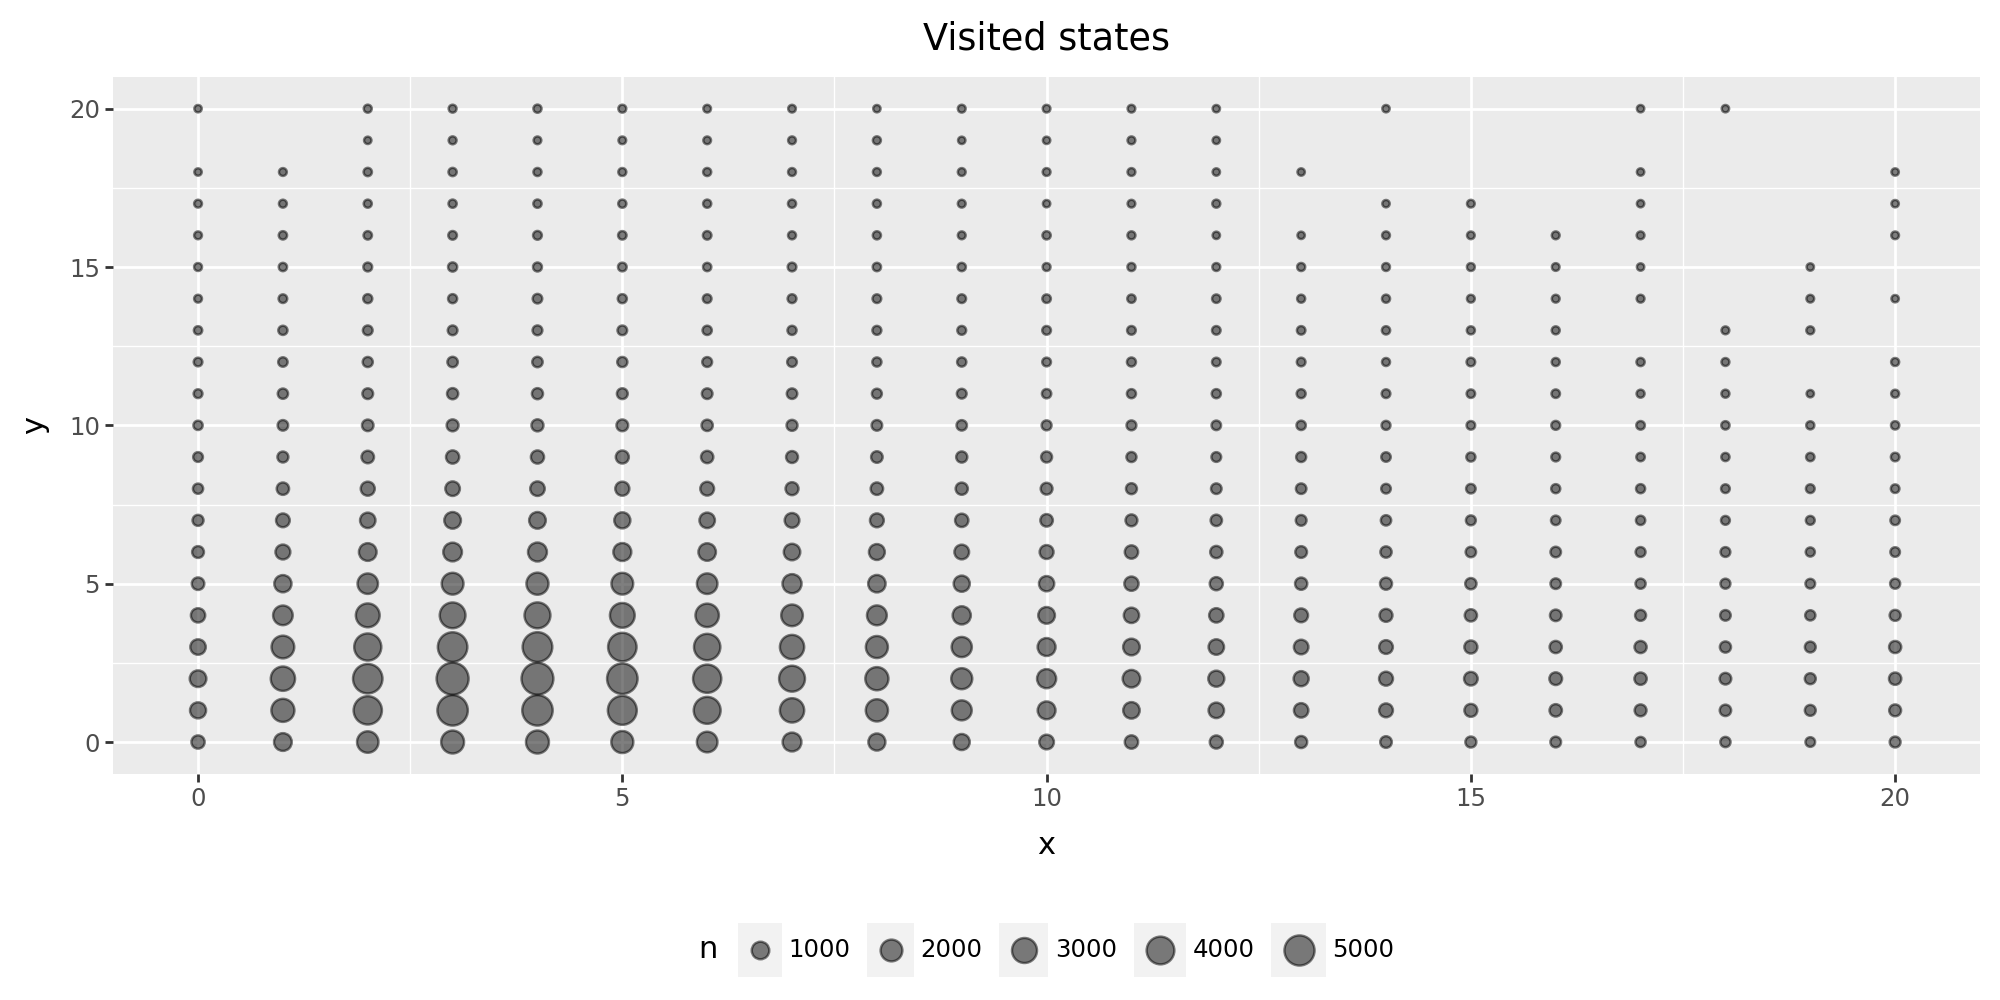

In [34]:
#@title Train Tabular

import numpy as np

# --- environment ---
env = RLEnvCar(seed=345)

# --- hyperparameters ---
alpha_theta = 1e-3   # actor step size
alpha_v     = 0.5    # critic step size (before /n_tilings adjustment)
alpha_r     = 1e-4   # average-reward step size
n_tilings   = 8
tiles_per_dim = [10, 10]
total_steps = 200000
callback_every = min(total_steps / 100, 500)

# --- actor: tabular softmax over state–action pairs ---
pi_hat = SoftmaxPolicyTabular(
    env=env,
    step_size=alpha_theta,
    rng_seed=878,
)

# --- critic: value function with tile coding over states ---
v_hat = ValueFunctionTileCoding(
    env=env,
    step_size=alpha_v,
    n_tilings=n_tilings,
    tiles_per_dim=tiles_per_dim,
    init_val=0.0,
    seed=249
)

# --- callback ---
def callback(pi_hat, info, trace):
    trace.append(info)

# --- run ---
trace = []
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=total_steps,
    alpha_r=alpha_r,
    callback=callback,
    callback_every=callback_every,
    trace=trace,
)


# Plot trace
def plot_results_cont(pi_hat, trace, title_r = "", print_dist = False, plot_policy = True):
    dat_r = pd.DataFrame(trace)
    cols_to_gather = [c for c in dat_r.columns if "reward" in c]
    dat_r = dat_r >> gather('type', 'r', cols_to_gather)
    pt = (
        ggplot(dat_r, aes("step", "r", color = "type"))
        + geom_line()
        + theme_minimal()
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(
            title=title_r,
            x="Step",
            y="Reward",
        )
    )
    pt.show()

    if plot_policy:
        dat_a = pd.DataFrame({'s': pi_hat.env.get_states()})
        dat_a = (
            dat_a
            >> mutate(
                x = X.s.apply(lambda s: s[0]),
                y = X.s.apply(lambda s: s[1]),
                action = [pi_hat.get_best_action(s) for s in dat_a['s']],
                alg = title_r
            )
            >> select(~X.s)
        )
        dat_a['action'] = pd.Categorical(dat_a['action'])
        pt = (
            ggplot(dat_a, aes(x = "x", y = "y", color = "action", label="action", size="action"))
            + geom_label(size = 6)
            + theme(figure_size=(10, 5), legend_position='bottom')
            + labs(title = "Actions")
        )
        pt.show()


    # visited states
    dat_s = [ [s[0], s[1], env.s_ctr[env.st2idx[s]]] for s in env.get_states()]
    dat_s = pd.DataFrame(dat_s, columns=['x', 'y', 'n'])
    dat_s = dat_s >> mask(X.n > 0)
    pt = (
        ggplot(dat_s, aes(x = 'x', y = 'y', size = 'n'))
        + geom_point(alpha = 0.5)
        + theme(figure_size=(10, 5), legend_position='bottom')
        + labs(title = "Visited states")
    )
    pt.show()

    if print_dist:
        # print(f"Theta: {pi_hat.theta}")
        print("A few probability distributions:")
        test_states = [(10, 10),(1, 1), (1, 20), (20, 1)]
        for s in test_states:
            actions = pi_hat.env.get_actions(s)
            prefs = pi_hat.get_action_preferences(s)
            probs = pi_hat.get_action_probs(s)
            print(f"State {s}:")
            for a, p, pf in zip(actions, probs[1], prefs):
                print(f"  a={a:5.1f}, π(a|s)={p:6.3f} h(s,a)={pf:6.3f}")
            print()

plot_results_cont(pi_hat, trace, title_r = "Actor-critic (cont.)")

#### Your turn

Explain the results.

1. What is the objective value approximately?

    *The average reward estimate (red curve) is approx. 47.6.*

2. Comment on the policy and visited states.

    *Since the demand rates are [3, 4] and the return rates are [3, 2], we have a higher total demand than returns and fewer cars returned than needed at Location 2. Therefore, an optimal policy will aim to move cars from Location 1 to Location 2. This is also reflected in the states we visit most. For states visited less frequently, actions tend to be more arbitrary due to the tabular parametrisation.*


100%|██████████| 200000/200000 [02:43<00:00, 1226.45it/s]


Final average reward estimate: 47.7


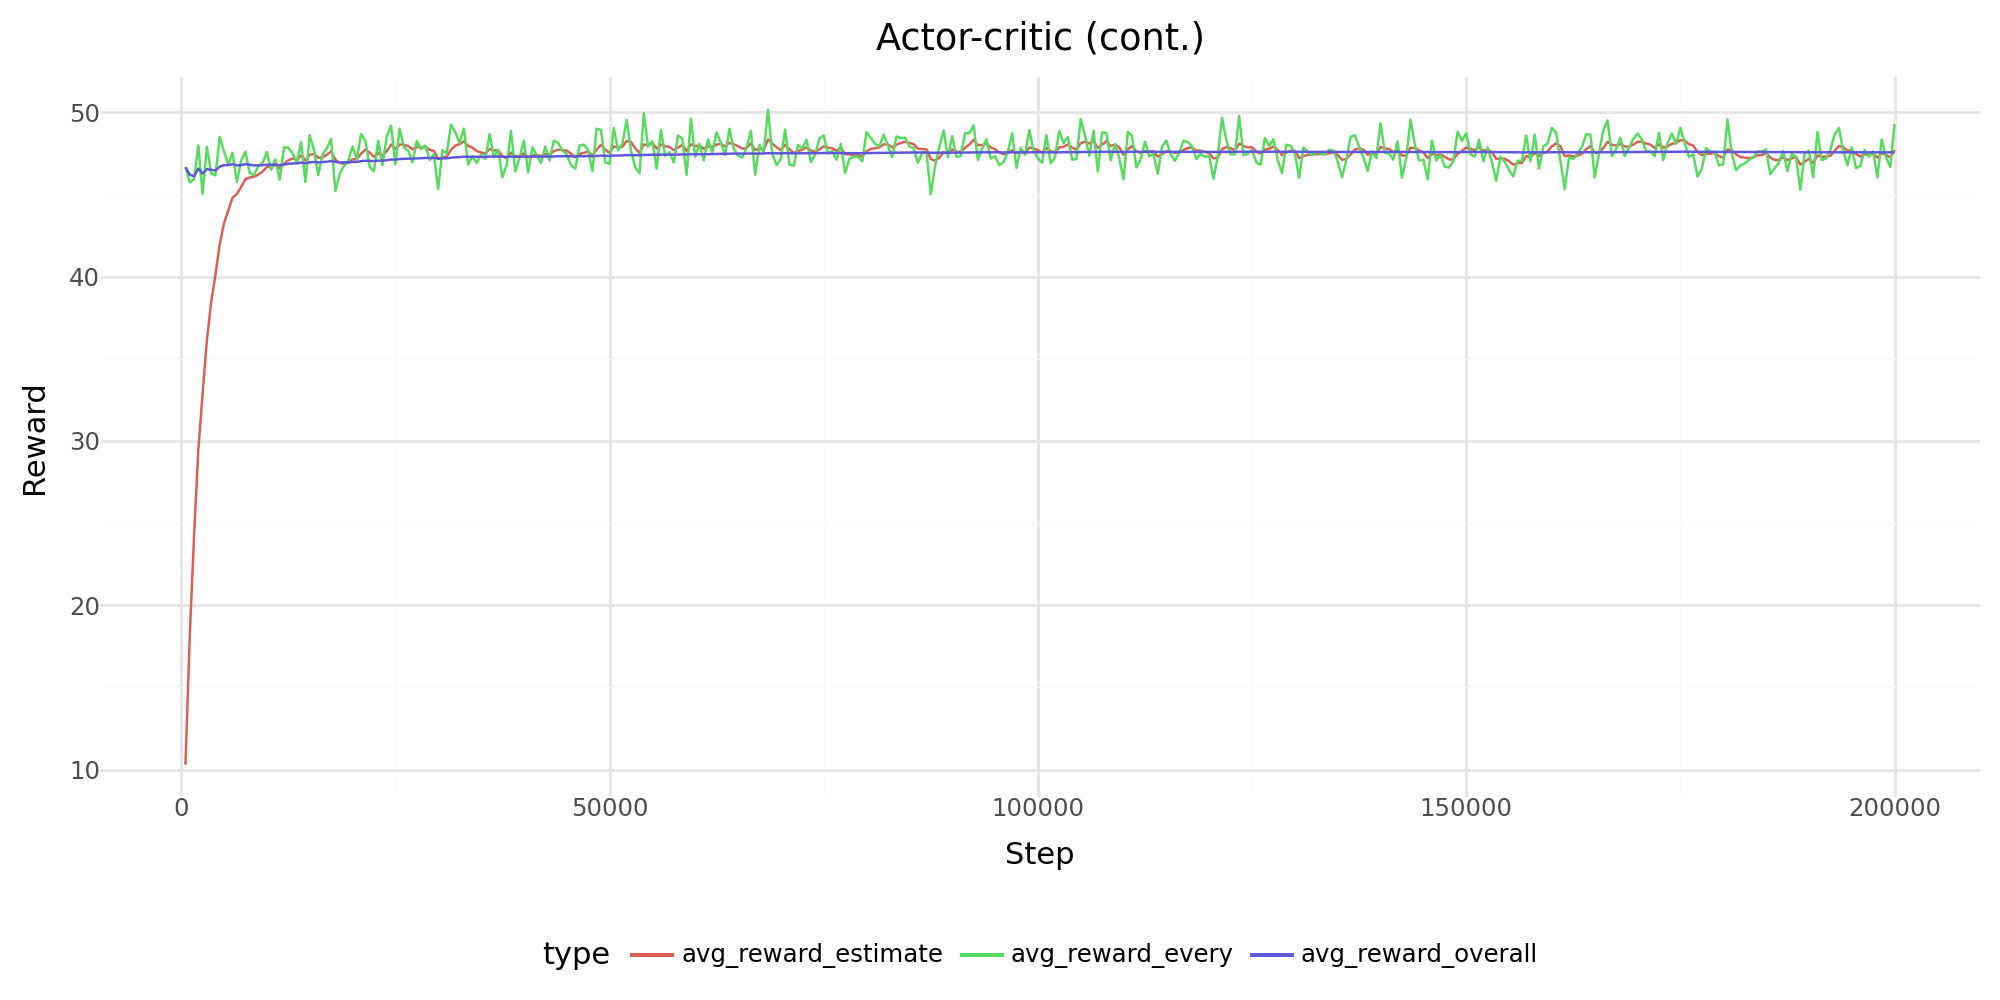

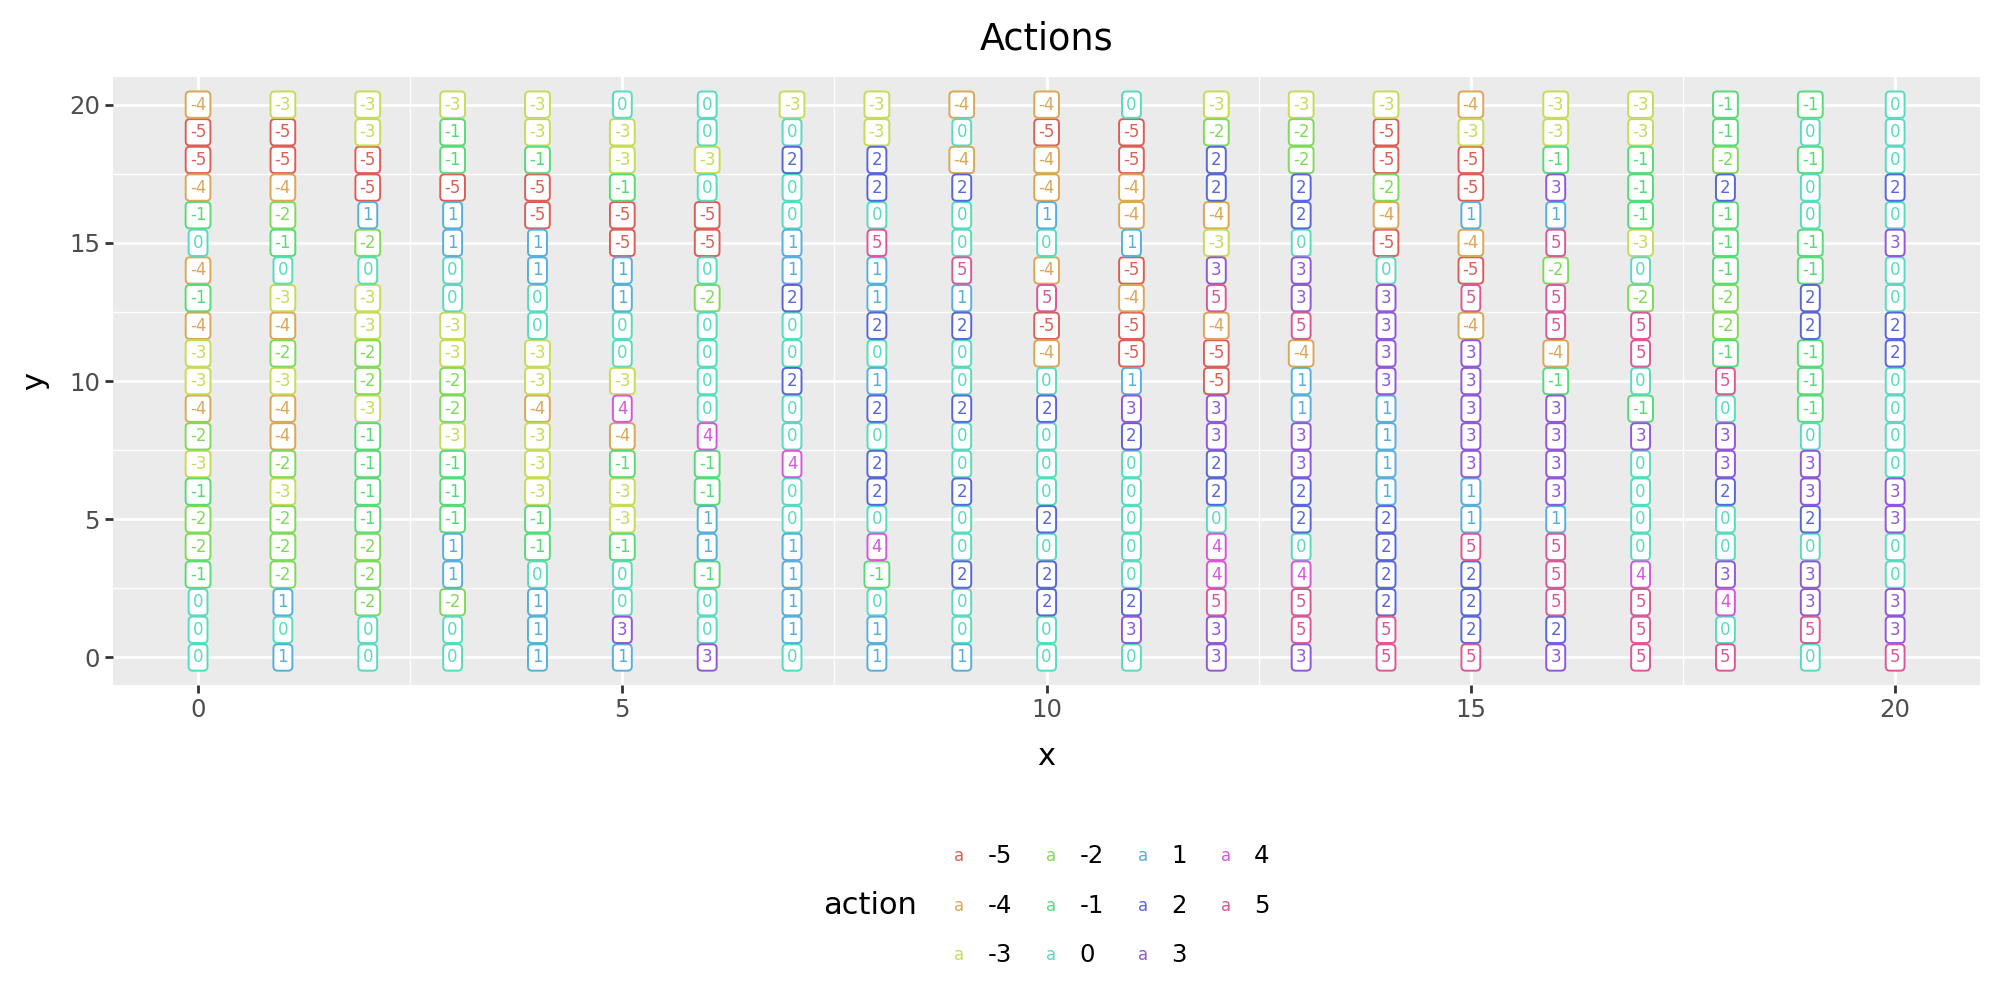

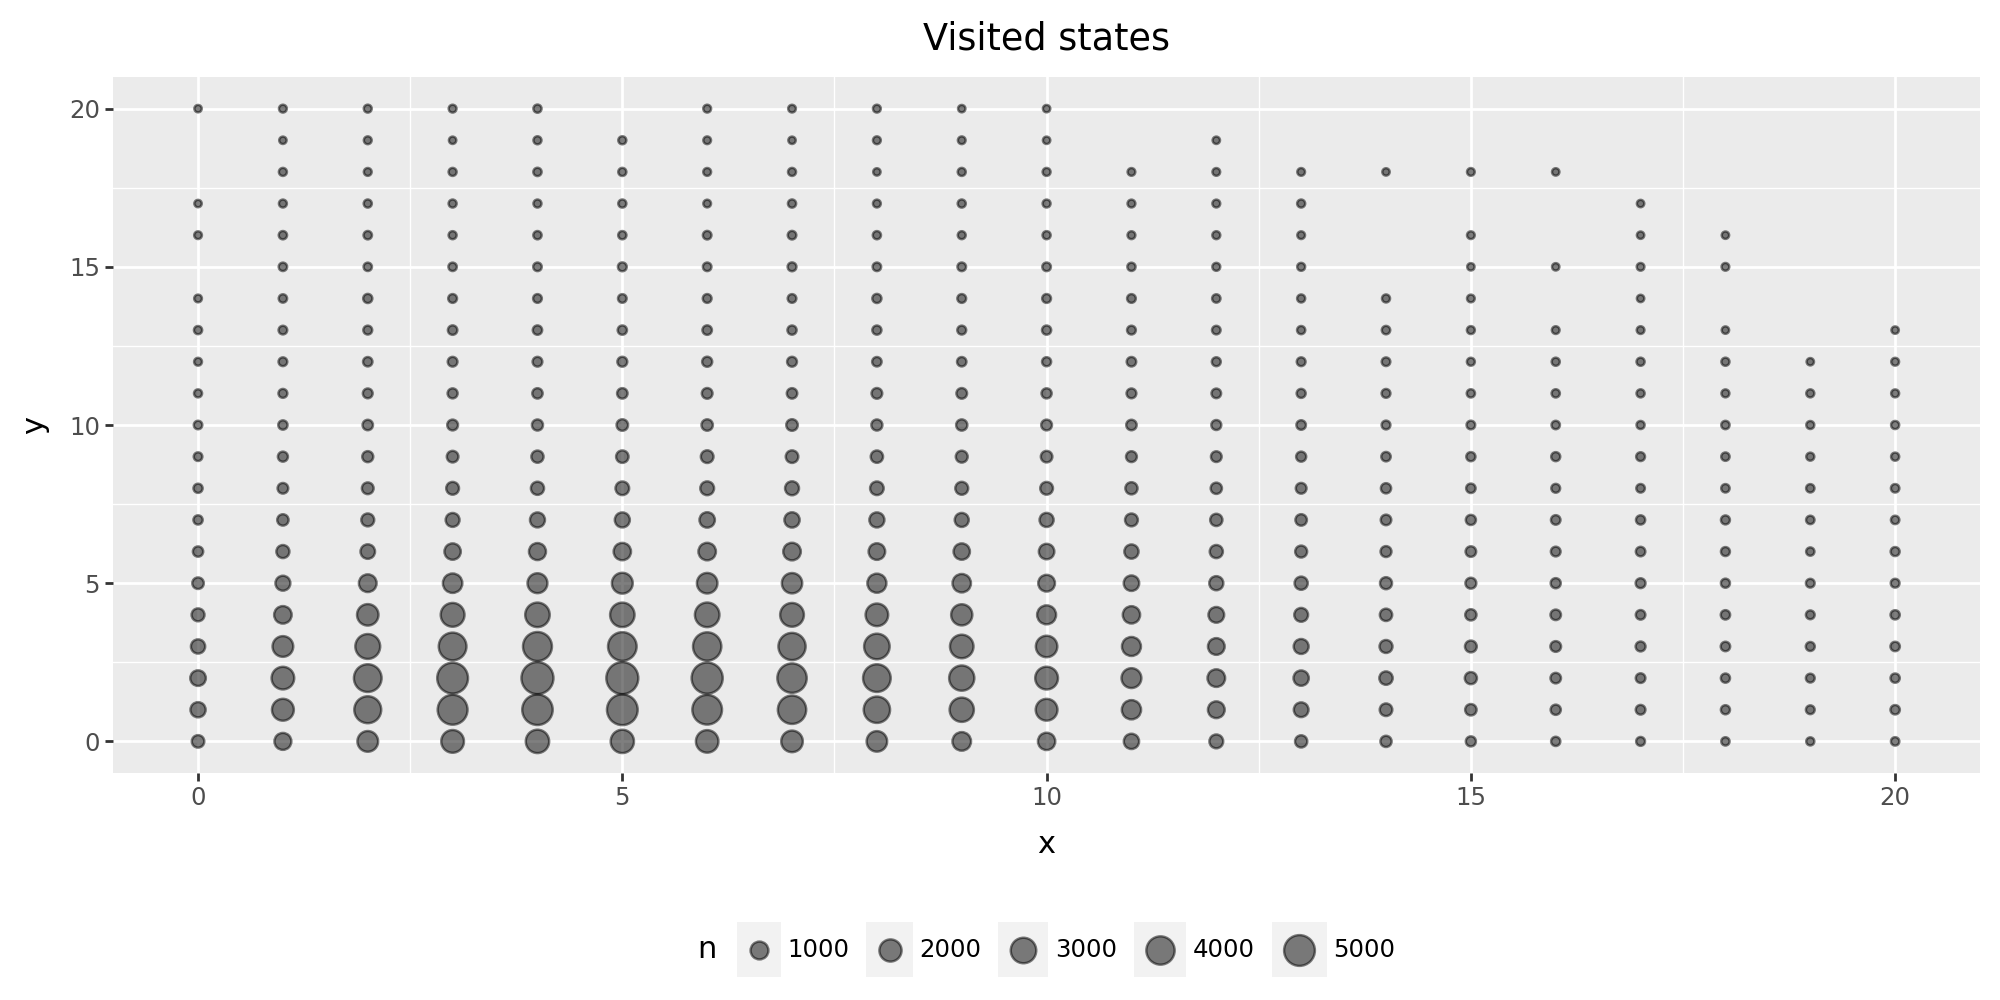

In [35]:
#@title Train - Fourier

import numpy as np

# --- environment ---
env = RLEnvCar(seed=345)

# --- hyperparameters ---
alpha_theta = 1e-3   # actor step size
alpha_v     = 0.1    # critic step size (before /n_tilings adjustment)
alpha_r     = 5e-4   # average-reward step size
f_order     = 15
total_steps = 200000
callback_every = min(total_steps / 100, 500)

# --- actor: tabular softmax over state–action pairs ---
pi_hat = SoftmaxPolicyFourier(
    env=env,
    step_size=alpha_theta,
    order = f_order,
    rng_seed=878,
)

# --- critic: value function with tile coding over states ---
v_hat = ValueFunctionTileCoding(
    env=env,
    step_size=alpha_v,
    n_tilings=n_tilings,
    tiles_per_dim=tiles_per_dim,
    init_val=0.0,
    seed=249
)

# --- run ---
trace = []
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=total_steps,
    alpha_r=alpha_r,
    callback=callback,
    callback_every=callback_every,
    trace=trace,
)
plot_results_cont(pi_hat, trace, title_r = "Actor-critic (cont.)")

#### Your turn

Explain the results.

1. What is the objective value approximately?

    *The average reward estimate (red curve) is approx. 47.7 which is the same a before.*

2. Comment on the policy and visited states.

    *Here we approximate using a smooth surface and not tabular values. That is, states visited rarely is now affected by the states we visit much. However, since Fourier, the shape may be arbitrary. We still visit states in the same regions as before.*

100%|██████████| 50000/50000 [00:39<00:00, 1253.71it/s]


Final average reward estimate: 44.19


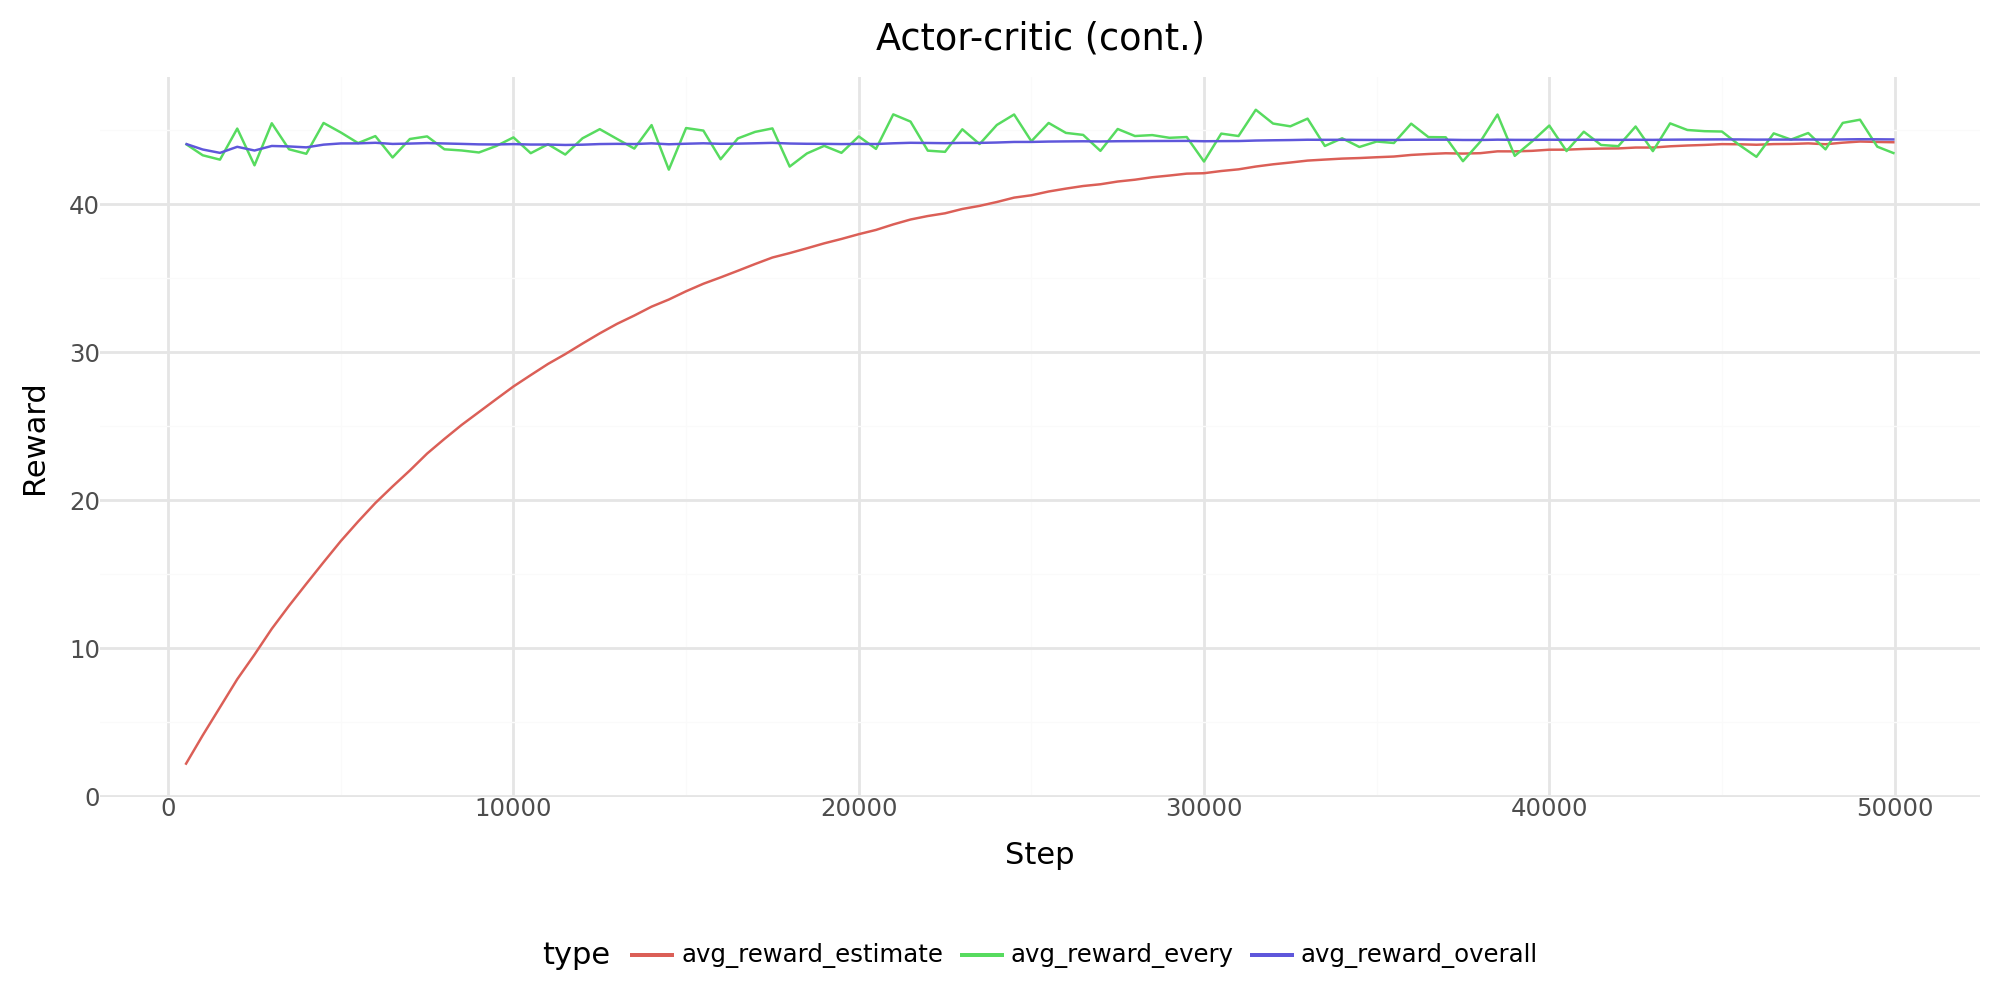

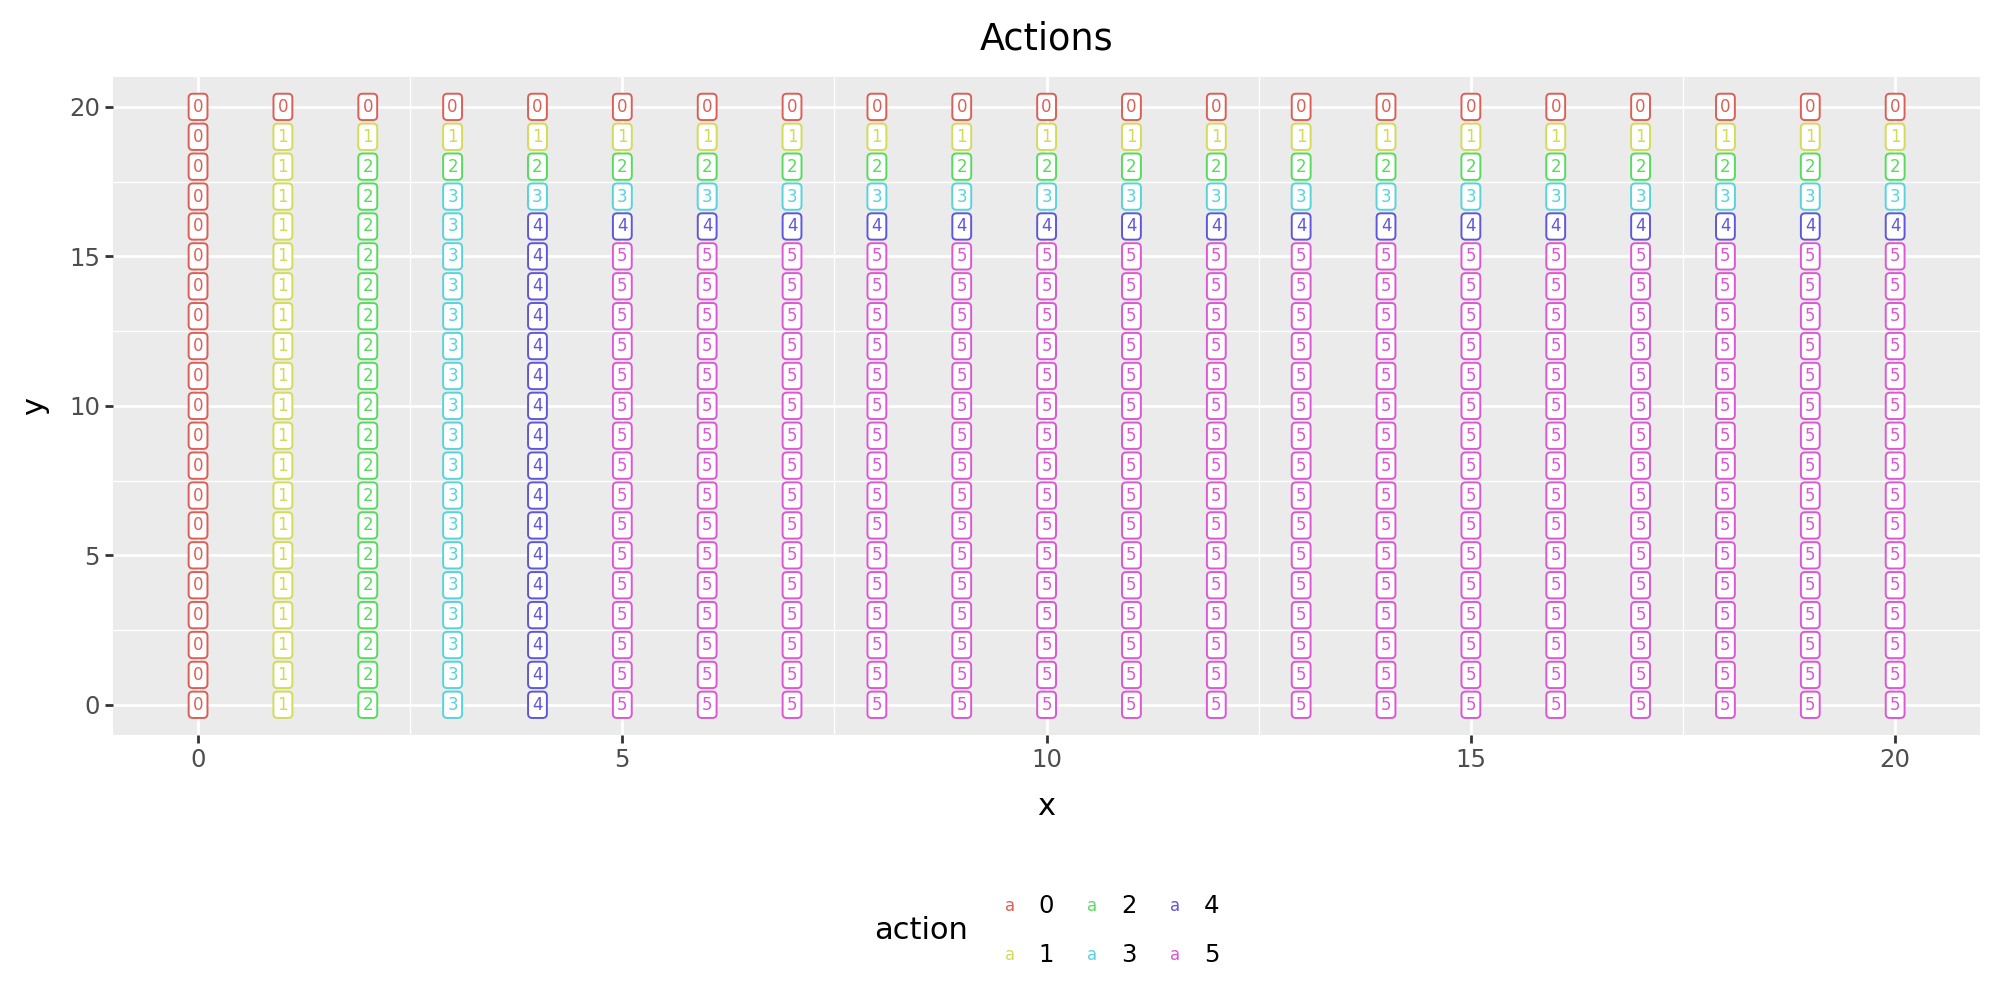

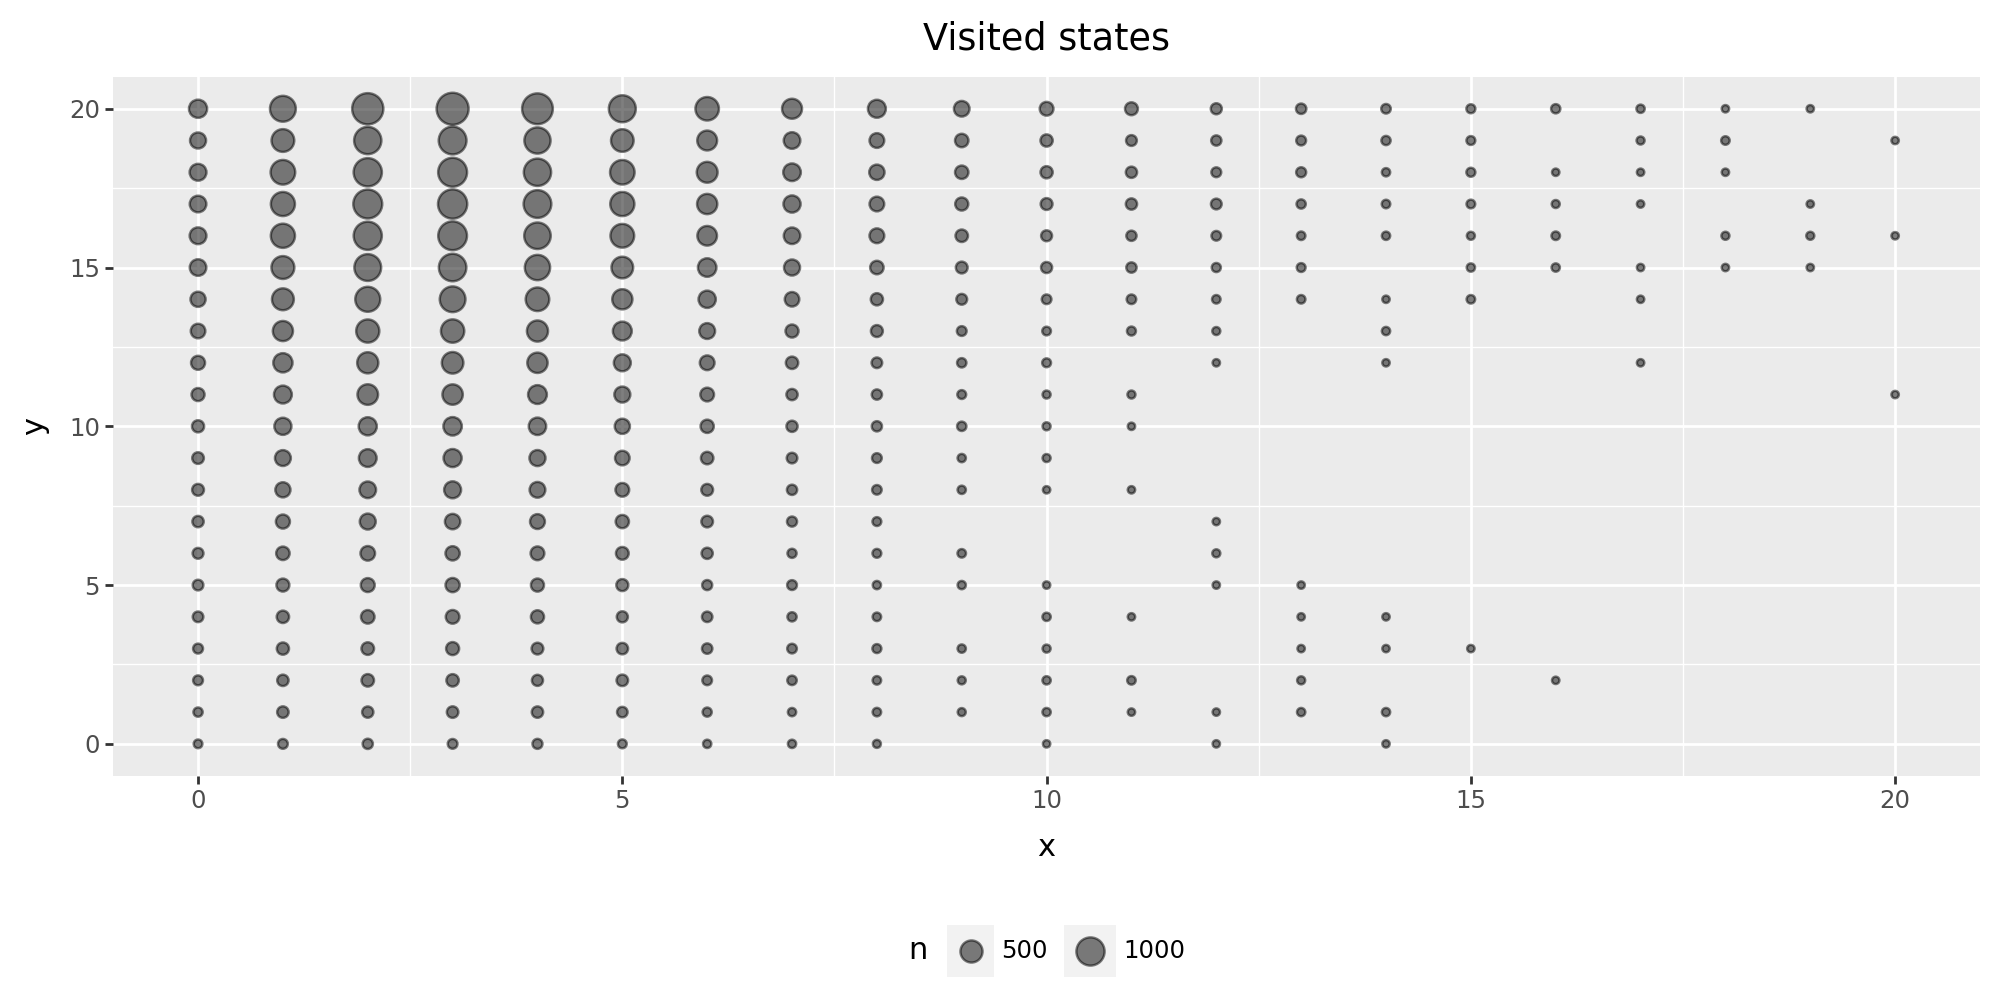

In [39]:
#@title Train - Monotone

import numpy as np

# --- environment ---
env = RLEnvCar(seed=345)

# --- hyperparameters ---
alpha_theta = 1e-3   # actor step size
alpha_v     = 0.1    # critic step size (before /n_tilings adjustment)
alpha_r     = 1e-4   # average-reward step size
total_steps = 50000
callback_every = min(total_steps / 100, 500)

# --- actor: tabular softmax over state–action pairs ---
pi_hat = SoftmaxPolicyMonotoneXY(
    env=env,
    step_size=alpha_theta,
    rng_seed=878,
)

# --- critic: value function with tile coding over states ---
v_hat = ValueFunctionTileCoding(
    env=env,
    step_size=alpha_v,
    n_tilings=n_tilings,
    tiles_per_dim=tiles_per_dim,
    init_val=0.0,
    seed=249
)

# --- run ---
trace = []
actor_critic_continuing(
    pi_hat=pi_hat,
    v_hat=v_hat,
    steps=total_steps,
    alpha_r=alpha_r,
    callback=callback,
    callback_every=callback_every,
    trace=trace,
)
plot_results_cont(pi_hat, trace, title_r = "Actor-critic (cont.)")

#### Your turn

Explain the results.

1. What is the objective value approximately?

    *The average reward estimate (red curve) is approx. 44.2 which is lower than before.*

2. Comment on the policy and visited states.

    *Here we approximate using 3 parameters. That is, the approximation becomes a plane in (x,y) with the specified restrictions on the gradients. This gives us a different policy with visits in states with a high number of cars at Location 2.*

# Exercises

### Exercise (seasonal inventory)

Consider the seasonal inventory and sales planning problem using the environment:

```
env = RLEnvSeasonal(
    max_inv=65,
    max_t=15,
    scrap_price=25.0,
    purchase_price=0,
    prices=[5, 25],
    start_q=65,
    seed=876
)
```

1. How do you expect the optimal policy to look? Solve the problem.

Now change the enviroment to

```
env = RLEnvSeasonal(
    max_inv=10,
    max_t=15,
    scrap_price=-25.0,
    purchase_price=0,
    prices=[5, 25],
    start_q=10,
    seed=876
)
```

2. How do you expect the optimal policy to look? Solve the problem.

### Exercise (car rental)

Modify the car rental environment so that we change the demand rates to `lD =[4, 1]` and the return rates to `lH = [1, 4]` and let the maximum number of cars be 10.

1. How do you expect the optimal policy to look? Solve the problem.

Modify the car rental environment so that we change the demand rates to `lD =[2, 2]` and the return rates to `lH = [0, 4]` and let the maximum number of cars be 10.

2. How do you expect the optimal policy to look? Solve the problem.

